# Finding Best XGBoost Regressor for Store Item Demand Forecasting

## Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [ ]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/train.csv', parse_dates = ['date'])
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/test.csv', parse_dates = ['date'])

In [ ]:
# # jupyter
# train_data = pd.read_csv('train.csv', parse_dates = ['date'])
# test_data = pd.read_csv('test.csv', parse_dates = ['date'])

In [ ]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
test_data.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [ ]:
data = pd.concat([train_data, test_data],sort= False)

data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


## Data preprocessing

### Feature engineering

#### Datetime features

In [ ]:
def create_date_time_features(df):
    df = df.copy()

    df['day_of_week'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.isocalendar().week.astype("int64")

    return df

In [ ]:
df1 = create_date_time_features(data)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year
0,2013-01-01,1,1,13.0,NaN,1,1,1,1
1,2013-01-02,1,1,11.0,NaN,2,1,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,1,1
3,2013-01-04,1,1,13.0,NaN,4,1,1,1
4,2013-01-05,1,1,10.0,NaN,5,1,1,1


#### Lag features

In [ ]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
        
    return df

In [ ]:
df1 = lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Rolling mean features

In [ ]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return df

In [ ]:
df1 = roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exponentially weighted mean features

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
                
    return dataframe

In [ ]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [ ]:
df1 = ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Summary

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   day_of_week                  958000 non-null  int64         
 6   quarter                      958000 non-null  int64         
 7   month                        958000 non-null  int64         
 8   week_of_year                 958000 non-null  int64         
 9   sales_lag_91                 912500 non-null  float64       
 10  sales_lag_98                 909000 non-null  float64       
 11  sales_lag_105              

### One-Hot encoding

In [ ]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'month', 'week_of_year' , 'day_of_week', "quarter"])

df2.shape

(958000, 196)

### Logarithmic transformation for sales data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0de954f790>]],
      dtype=object)

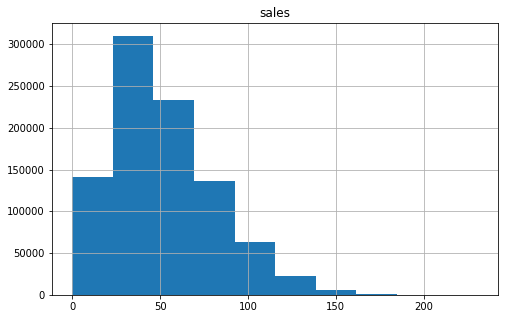

In [ ]:
# original
df2.hist('sales',figsize=(8,5))

In [ ]:
df2['sales']= np.log1p(df2["sales"].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0de7541e10>]],
      dtype=object)

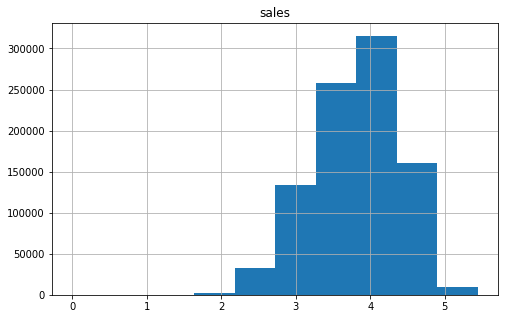

In [ ]:
# transformed
df2.hist('sales',figsize=(8,5))

### Split into train val test

* train: 2013 to 2016 (4 years) - 80%
* val: 2017 (1 year) - 20%
* test: 2018 onwards

In [ ]:
df_model = df2.copy()

In [ ]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [ ]:
train = df_model.loc[(df_model["date"] < "2017-01-01"), :]

val = df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [ ]:
train.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,2013-01-01,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
val.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
730500,2017-01-01,3.663562,NaN,49.0,59.0,43.0,50.0,45.0,62.0,78.0,...,0,0,0,0,0,1,1,0,0,0
730501,2017-01-01,4.682131,NaN,131.0,167.0,142.0,145.0,159.0,171.0,189.0,...,0,0,0,0,0,1,1,0,0,0
730502,2017-01-01,4.077537,NaN,69.0,84.0,92.0,86.0,109.0,90.0,110.0,...,0,0,0,0,0,1,1,0,0,0
730503,2017-01-01,3.295837,NaN,40.0,34.0,33.0,33.0,34.0,44.0,39.0,...,0,0,0,0,0,1,1,0,0,0
730504,2017-01-01,3.367296,NaN,38.0,37.0,55.0,42.0,41.0,52.0,43.0,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

In [ ]:
X_train = train[cols]
Y_train = train['sales']

X_train.shape, Y_train.shape

((730500, 193), (730500,))

In [ ]:
X_val = val[cols]
Y_val = val['sales']

X_val.shape, Y_val.shape

((45000, 193), (45000,))

## Hyperparameter tuning XGBoost regressor

In [ ]:
model = xgb.XGBRegressor()

In [ ]:
# google colab
params = {}

params['max_depth'] = [3, 4, 5]
params['subsample'] = [0.5, 0.7, 1.0]
params['colsample_bytree'] = [0.5, 0.7, 1.0]
params['learning_rate'] = [0.001, 0.01, 0.1]

grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=3, scoring='r2', verbose=50)
grid_result = grid_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_val, Y_val)])

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

[CV 2/3; 1/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25013
[CV 3/3; 1/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25011
[CV 1/3; 1/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25019
[CV 1/3; 2/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25019
[1]	validation_0-rmse:3.24675
[1]	validation_0-rmse:3.24675
[1]	validation_0-rmse:3.24688
[1]	validation_0-rmse:3.24689
[2]	validation_0-rmse:3.24361
[2]	validation_0-rmse:3.24345
[2]	validation_0-rmse:3.24346
[2]	validation_0-rmse:3.24362
[3]	validation_0-rmse:3.24035
[3]	validation_0-rmse:3.24010
[3]	validation_0-rmse:3.24010
[3]	validation_0-rmse:3.24034
[4]	validation_0-rmse:3.23705
[4]	validation_0-rmse:3.23675
[4]	validation_0-rmse:3.23679
[4]	validation_0-rmse:3.23705
[5]	validation_0-rmse:3.23378
[5]	va

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[91]	validation_0-rmse:2.95850
[89]	validation_0-rmse:2.96537
[91]	validation_0-rmse:2.96444
[92]	validation_0-rmse:2.95549
[90]	validation_0-rmse:2.96225
[92]	validation_0-rmse:2.96144
[93]	validation_0-rmse:2.95244
[91]	validation_0-rmse:2.95920
[93]	validation_0-rmse:2.95846
[94]	validation_0-rmse:2.94939
[92]	validation_0-rmse:2.95621
[94]	validation_0-rmse:2.95546
[CV 1/3; 1/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-25.600 total time= 8.9min
[CV 2/3; 2/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25013
[95]	validation_0-rmse:2.94640
[93]	validation_0-rmse:2.95317
[95]	validation_0-rmse:2.95247
[96]	validation_0-rmse:2.94326
[96]	validation_0-rmse:2.94946
[94]	validation_0-rmse:2.95010
[1]	validation_0-rmse:3.24675
[97]	validation_0-rmse:2.94022
[97]	validation_0-rmse:2.94649
[95]	validation_0-rmse:2.94713
[2]	validation_0-rmse:3.24346
[98]	validation_0-rmse:2.93718
[98]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[6]	validation_0-rmse:3.23016
[7]	validation_0-rmse:3.22685


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[8]	validation_0-rmse:3.22348
[9]	validation_0-rmse:3.22017
[CV 3/3; 1/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.921 total time= 9.9min
[CV 3/3; 2/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25011
[10]	validation_0-rmse:3.21687
[CV 1/3; 2/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-25.601 total time= 9.9min
[CV 1/3; 3/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25019
[1]	validation_0-rmse:3.24675
[11]	validation_0-rmse:3.21357
[1]	validation_0-rmse:3.24690
[2]	validation_0-rmse:3.24345
[12]	validation_0-rmse:3.21022
[CV 2/3; 1/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.653 total time=10.0min
[CV 2/3; 3/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25013
[2]	validation_0-rmse:

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[76]	validation_0-rmse:3.00536
[94]	validation_0-rmse:2.95553
[95]	validation_0-rmse:2.94639
[95]	validation_0-rmse:2.95254
[77]	validation_0-rmse:3.00224
[96]	validation_0-rmse:2.94326
[96]	validation_0-rmse:2.94957
[97]	validation_0-rmse:2.94021
[78]	validation_0-rmse:2.99915
[97]	validation_0-rmse:2.94659
[98]	validation_0-rmse:2.93717
[CV 2/3; 2/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.653 total time=10.7min
[CV 3/3; 3/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25011
[79]	validation_0-rmse:2.99607
[98]	validation_0-rmse:2.94361
[99]	validation_0-rmse:2.93414
[1]	validation_0-rmse:3.24677
[80]	validation_0-rmse:2.99300
[99]	validation_0-rmse:2.94063
[2]	validation_0-rmse:3.24342
[81]	validation_0-rmse:2.98993


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-rmse:3.24007


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[82]	validation_0-rmse:2.98685
[4]	validation_0-rmse:3.23671
[83]	validation_0-rmse:2.98371
[5]	validation_0-rmse:3.23342
[84]	validation_0-rmse:2.98064
[6]	validation_0-rmse:3.23009
[CV 3/3; 2/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.920 total time=10.4min
[CV 1/3; 4/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25019
[85]	validation_0-rmse:2.97758
[CV 1/3; 3/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-25.602 total time=10.5min
[CV 2/3; 4/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25012
[7]	validation_0-rmse:3.22681
[1]	validation_0-rmse:3.24691
[86]	validation_0-rmse:2.97452
[1]	validation_0-rmse:3.24680
[8]	validation_0-rmse:3.22347
[2]	validation_0-rmse:3.24363
[87]	validation_0-rmse:2.97146
[9]	validation_0-rmse:3.22014
[2]	validation_0-rmse:3.24348
[3]	validation_0-rmse:3.

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-rmse:3.17404
[19]	validation_0-rmse:3.18838
[16]	validation_0-rmse:3.19721
[24]	validation_0-rmse:3.17076
[20]	validation_0-rmse:3.18516
[17]	validation_0-rmse:3.19394
[25]	validation_0-rmse:3.16750
[21]	validation_0-rmse:3.18194
[18]	validation_0-rmse:3.19065
[26]	validation_0-rmse:3.16422
[22]	validation_0-rmse:3.17873
[19]	validation_0-rmse:3.18738
[CV 2/3; 3/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.658 total time=12.6min
[CV 3/3; 4/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25011
[23]	validation_0-rmse:3.17552
[27]	validation_0-rmse:3.16096
[20]	validation_0-rmse:3.18408
[24]	validation_0-rmse:3.17232
[1]	validation_0-rmse:3.24676
[28]	validation_0-rmse:3.15770
[25]	validation_0-rmse:3.16912
[21]	validation_0-rmse:3.18082
[29]	validation_0-rmse:3.15444
[2]	validation_0-rmse:3.24344
[26]	validation_0-rmse:3.16592
[22]	validation_0-rmse:3.17755
[30]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[87]	validation_0-rmse:2.97238
[96]	validation_0-rmse:2.94349
[70]	validation_0-rmse:3.02363
[88]	validation_0-rmse:2.96933
[97]	validation_0-rmse:2.94044
[71]	validation_0-rmse:3.02050
[89]	validation_0-rmse:2.96628
[98]	validation_0-rmse:2.93744
[72]	validation_0-rmse:3.01739
[90]	validation_0-rmse:2.96322
[99]	validation_0-rmse:2.93441
[CV 1/3; 4/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-25.674 total time=10.6min
[CV 1/3; 5/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25019
[73]	validation_0-rmse:3.01427
[91]	validation_0-rmse:2.96016
[1]	validation_0-rmse:3.24691
[74]	validation_0-rmse:3.01117
[92]	validation_0-rmse:2.95716


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-rmse:3.24363
[75]	validation_0-rmse:3.00806
[93]	validation_0-rmse:2.95412
[3]	validation_0-rmse:3.24036
[76]	validation_0-rmse:3.00497
[94]	validation_0-rmse:2.95108
[77]	validation_0-rmse:3.00185
[4]	validation_0-rmse:3.23708
[95]	validation_0-rmse:2.94808
[78]	validation_0-rmse:2.99874
[5]	validation_0-rmse:3.23382
[96]	validation_0-rmse:2.94501
[CV 3/3; 3/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.925 total time=11.9min
[CV 2/3; 5/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25012
[79]	validation_0-rmse:2.99564
[6]	validation_0-rmse:3.23052
[97]	validation_0-rmse:2.94198
[80]	validation_0-rmse:2.99254
[1]	validation_0-rmse:3.24680
[98]	validation_0-rmse:2.93896
[7]	validation_0-rmse:3.22726
[81]	validation_0-rmse:2.98947
[8]	validation_0-rmse:3.22399
[2]	validation_0-rmse:3.24348
[99]	validation_0-rmse:2.93593
[82]	validation_0-rmse:2.98637
[9]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-rmse:3.23682
[84]	validation_0-rmse:2.98022
[11]	validation_0-rmse:3.21425
[5]	validation_0-rmse:3.23351
[85]	validation_0-rmse:2.97713
[12]	validation_0-rmse:3.21100
[86]	validation_0-rmse:2.97404
[6]	validation_0-rmse:3.23021
[13]	validation_0-rmse:3.20777
[87]	validation_0-rmse:2.97099
[7]	validation_0-rmse:3.22688
[14]	validation_0-rmse:3.20454
[CV 2/3; 4/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.646 total time=12.1min
[CV 3/3; 5/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25011
[88]	validation_0-rmse:2.96794
[15]	validation_0-rmse:3.20130
[8]	validation_0-rmse:3.22357
[1]	validation_0-rmse:3.24676
[89]	validation_0-rmse:2.96488
[16]	validation_0-rmse:3.19806
[9]	validation_0-rmse:3.22026
[90]	validation_0-rmse:2.96181
[2]	validation_0-rmse:3.24344
[17]	validation_0-rmse:3.19483
[10]	validation_0-rmse:3.21696
[91]	validation_0-rmse:2.95873
[3]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[28]	validation_0-rmse:3.15954
[12]	validation_0-rmse:3.21019
[19]	validation_0-rmse:3.18738
[29]	validation_0-rmse:3.15636
[13]	validation_0-rmse:3.20689
[20]	validation_0-rmse:3.18409
[30]	validation_0-rmse:3.15317
[14]	validation_0-rmse:3.20357
[21]	validation_0-rmse:3.18083
[31]	validation_0-rmse:3.14999
[15]	validation_0-rmse:3.20025
[CV 3/3; 4/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.900 total time=11.7min
[CV 1/3; 6/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25019
[22]	validation_0-rmse:3.17756
[32]	validation_0-rmse:3.14682
[16]	validation_0-rmse:3.19694
[1]	validation_0-rmse:3.24692
[23]	validation_0-rmse:3.17429
[33]	validation_0-rmse:3.14364
[17]	validation_0-rmse:3.19366
[2]	validation_0-rmse:3.24363
[24]	validation_0-rmse:3.17102
[34]	validation_0-rmse:3.14047
[18]	validation_0-rmse:3.19035
[35]	validation_0-rmse:3.13730
[25]	validation_0-rmse:3.16776
[3]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:3.05603
[76]	validation_0-rmse:3.00502
[82]	validation_0-rmse:2.98773
[77]	validation_0-rmse:3.00191
[62]	validation_0-rmse:3.05296
[83]	validation_0-rmse:2.98467
[78]	validation_0-rmse:2.99881
[63]	validation_0-rmse:3.04985
[84]	validation_0-rmse:2.98159
[CV 1/3; 5/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-25.669 total time=11.5min
[CV 2/3; 6/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25012
[79]	validation_0-rmse:2.99570
[64]	validation_0-rmse:3.04678
[85]	validation_0-rmse:2.97852
[80]	validation_0-rmse:2.99260
[65]	validation_0-rmse:3.04370
[1]	validation_0-rmse:3.24680
[86]	validation_0-rmse:2.97546
[81]	validation_0-rmse:2.98952
[66]	validation_0-rmse:3.04063
[2]	validation_0-rmse:3.24346
[87]	validation_0-rmse:2.97241
[82]	validation_0-rmse:2.98643
[67]	validation_0-rmse:3.03756
[88]	validation_0-rmse:2.96936
[3]	validation_0-rmse:3.24014
[83]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[96]	validation_0-rmse:2.94362
[14]	validation_0-rmse:3.20383
[80]	validation_0-rmse:2.99794
[97]	validation_0-rmse:2.94058
[81]	validation_0-rmse:2.99492
[15]	validation_0-rmse:3.20056
[98]	validation_0-rmse:2.93755
[82]	validation_0-rmse:2.99190
[16]	validation_0-rmse:3.19727
[99]	validation_0-rmse:2.93450
[CV 2/3; 5/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.646 total time=13.3min
[CV 3/3; 6/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25011
[83]	validation_0-rmse:2.98887
[17]	validation_0-rmse:3.19400
[84]	validation_0-rmse:2.98585
[1]	validation_0-rmse:3.24678


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18]	validation_0-rmse:3.19072
[85]	validation_0-rmse:2.98284
[2]	validation_0-rmse:3.24343
[19]	validation_0-rmse:3.18744
[86]	validation_0-rmse:2.97983
[3]	validation_0-rmse:3.24009
[87]	validation_0-rmse:2.97683
[20]	validation_0-rmse:3.18417
[4]	validation_0-rmse:3.23674
[CV 3/3; 5/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.901 total time=13.0min
[CV 1/3; 7/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25019
[88]	validation_0-rmse:2.97383
[21]	validation_0-rmse:3.18090
[5]	validation_0-rmse:3.23345
[1]	validation_0-rmse:3.24691
[89]	validation_0-rmse:2.97083
[22]	validation_0-rmse:3.17763
[2]	validation_0-rmse:3.24364
[6]	validation_0-rmse:3.23013
[90]	validation_0-rmse:2.96782
[3]	validation_0-rmse:3.24037
[23]	validation_0-rmse:3.17441
[91]	validation_0-rmse:2.96483
[7]	validation_0-rmse:3.22681
[4]	validation_0-rmse:3.23711
[24]	validation_0-rmse:3.17115
[92]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14516
[14]	validation_0-rmse:3.20454
[16]	validation_0-rmse:3.19698
[15]	validation_0-rmse:3.20131
[33]	validation_0-rmse:3.14195
[17]	validation_0-rmse:3.19369
[16]	validation_0-rmse:3.19808
[34]	validation_0-rmse:3.13872
[18]	validation_0-rmse:3.19040
[17]	validation_0-rmse:3.19486
[CV 1/3; 6/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-25.676 total time=13.1min
[CV 2/3; 7/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25013
[35]	validation_0-rmse:3.13552
[18]	validation_0-rmse:3.19162
[19]	validation_0-rmse:3.18711
[1]	validation_0-rmse:3.24681
[36]	validation_0-rmse:3.13230
[19]	validation_0-rmse:3.18841
[20]	validation_0-rmse:3.18382
[2]	validation_0-rmse:3.24353
[20]	validation_0-rmse:3.18518
[37]	validation_0-rmse:3.12909
[21]	validation_0-rmse:3.18055
[3]	validation_0-rmse:3.24021
[21]	validation_0-rmse:3.18197
[38]	validation_0-rmse:3.12588
[22]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[71]	validation_0-rmse:3.02258


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[88]	validation_0-rmse:2.96804
[72]	validation_0-rmse:3.01947
[89]	validation_0-rmse:2.96496
[73]	validation_0-rmse:3.01639
[CV 2/3; 6/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.649 total time=15.3min
[CV 3/3; 7/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25012
[90]	validation_0-rmse:2.96190
[74]	validation_0-rmse:3.01330
[CV 1/3; 7/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-25.718 total time=12.4min
[CV 1/3; 8/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25019
[91]	validation_0-rmse:2.95885
[75]	validation_0-rmse:3.01020
[1]	validation_0-rmse:3.24678
[1]	validation_0-rmse:3.24691
[76]	validation_0-rmse:3.00712
[92]	validation_0-rmse:2.95580
[2]	validation_0-rmse:3.24348
[2]	validation_0-rmse:3.24364
[77]	validation_0-rmse:3.00405
[3]	validation_0-rmse:3.24016
[93]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	validation_0-rmse:3.21426
[12]	validation_0-rmse:3.21031
[86]	validation_0-rmse:2.97651
[12]	validation_0-rmse:3.21101
[87]	validation_0-rmse:2.97345
[13]	validation_0-rmse:3.20701
[13]	validation_0-rmse:3.20777
[88]	validation_0-rmse:2.97041
[14]	validation_0-rmse:3.20372
[CV 3/3; 6/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.904 total time=14.8min
[CV 2/3; 8/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25012
[14]	validation_0-rmse:3.20454
[89]	validation_0-rmse:2.96736
[15]	validation_0-rmse:3.20042
[15]	validation_0-rmse:3.20131
[1]	validation_0-rmse:3.24681
[90]	validation_0-rmse:2.96432
[16]	validation_0-rmse:3.19714
[16]	validation_0-rmse:3.19807
[2]	validation_0-rmse:3.24352
[91]	validation_0-rmse:2.96128
[17]	validation_0-rmse:3.19387
[17]	validation_0-rmse:3.19484
[3]	validation_0-rmse:3.24021
[92]	validation_0-rmse:2.95829
[18]	validation_0-rmse:3.19061
[18]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[27]	validation_0-rmse:3.16275
[11]	validation_0-rmse:3.21378
[28]	validation_0-rmse:3.15803
[28]	validation_0-rmse:3.15956
[12]	validation_0-rmse:3.21050
[29]	validation_0-rmse:3.15477
[29]	validation_0-rmse:3.15637
[30]	validation_0-rmse:3.15154
[13]	validation_0-rmse:3.20722
[CV 2/3; 7/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.651 total time=14.3min
[CV 3/3; 8/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25012
[30]	validation_0-rmse:3.15320
[31]	validation_0-rmse:3.14831
[14]	validation_0-rmse:3.20395
[31]	validation_0-rmse:3.15002
[1]	validation_0-rmse:3.24677
[32]	validation_0-rmse:3.14508
[32]	validation_0-rmse:3.14684
[15]	validation_0-rmse:3.20067
[2]	validation_0-rmse:3.24346
[33]	validation_0-rmse:3.14185
[33]	validation_0-rmse:3.14367
[16]	validation_0-rmse:3.19741
[3]	validation_0-rmse:3.24013
[34]	validation_0-rmse:3.13862
[34]	validation_0-rmse:3.14049
[4]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:3.05289


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[73]	validation_0-rmse:3.01639
[62]	validation_0-rmse:3.04976
[74]	validation_0-rmse:3.01330
[63]	validation_0-rmse:3.04663
[75]	validation_0-rmse:3.01021
[64]	validation_0-rmse:3.04349
[CV 3/3; 7/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.913 total time=13.5min
[CV 1/3; 9/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25018
[CV 1/3; 8/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-25.713 total time=13.5min
[CV 2/3; 9/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25012
[76]	validation_0-rmse:3.00713
[65]	validation_0-rmse:3.04039
[1]	validation_0-rmse:3.24690
[77]	validation_0-rmse:3.00406
[1]	validation_0-rmse:3.24680
[66]	validation_0-rmse:3.03724
[2]	validation_0-rmse:3.24363
[78]	validation_0-rmse:3.00097
[67]	validation_0-rmse:3.03412
[2]	validation_0-rmse:3.24349
[3]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[25]	validation_0-rmse:3.16919
[90]	validation_0-rmse:2.96324
[21]	validation_0-rmse:3.18123
[26]	validation_0-rmse:3.16599
[91]	validation_0-rmse:2.96020
[27]	validation_0-rmse:3.16278
[22]	validation_0-rmse:3.17799
[92]	validation_0-rmse:2.95720
[28]	validation_0-rmse:3.15959
[CV 2/3; 8/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.650 total time=15.6min
[CV 3/3; 9/81] START colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25012
[23]	validation_0-rmse:3.17477
[93]	validation_0-rmse:2.95419
[29]	validation_0-rmse:3.15640
[1]	validation_0-rmse:3.24678
[24]	validation_0-rmse:3.17153
[94]	validation_0-rmse:2.95115
[30]	validation_0-rmse:3.15322
[2]	validation_0-rmse:3.24346
[25]	validation_0-rmse:3.16828
[95]	validation_0-rmse:2.94815
[31]	validation_0-rmse:3.15003
[3]	validation_0-rmse:3.24012
[96]	validation_0-rmse:2.94518
[26]	validation_0-rmse:3.16503
[32]	validation_0-rmse:3.14685
[97]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[7]	validation_0-rmse:3.22690
[30]	validation_0-rmse:3.15211
[37]	validation_0-rmse:3.13103
[8]	validation_0-rmse:3.22358
[31]	validation_0-rmse:3.14890
[38]	validation_0-rmse:3.12787
[9]	validation_0-rmse:3.22029
[CV 3/3; 8/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.913 total time=15.1min
[CV 1/3; 10/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22071
[32]	validation_0-rmse:3.14568
[39]	validation_0-rmse:3.12472
[1]	validation_0-rmse:3.18803
[10]	validation_0-rmse:3.21698
[2]	validation_0-rmse:3.15578
[33]	validation_0-rmse:3.14247
[3]	validation_0-rmse:3.12390
[40]	validation_0-rmse:3.12157
[4]	validation_0-rmse:3.09226
[11]	validation_0-rmse:3.21371
[34]	validation_0-rmse:3.13925
[5]	validation_0-rmse:3.06100
[41]	validation_0-rmse:3.11841
[6]	validation_0-rmse:3.02980
[12]	validation_0-rmse:3.21041
[7]	validation_0-rmse:2.99911
[42]	validation_0-rmse:3.11527
[35]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[51]	validation_0-rmse:3.08454
[72]	validation_0-rmse:3.01959
[87]	validation_0-rmse:2.97688
[52]	validation_0-rmse:3.08137
[88]	validation_0-rmse:2.97388
[73]	validation_0-rmse:3.01648
[CV 1/3; 10/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-6.632 total time= 7.6min
[CV 2/3; 10/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22010
[53]	validation_0-rmse:3.07821
[89]	validation_0-rmse:2.97088
[1]	validation_0-rmse:3.18662
[74]	validation_0-rmse:3.01339
[2]	validation_0-rmse:3.15434
[54]	validation_0-rmse:3.07506
[3]	validation_0-rmse:3.12159
[90]	validation_0-rmse:2.96789
[75]	validation_0-rmse:3.01030
[4]	validation_0-rmse:3.08955
[55]	validation_0-rmse:3.07189
[91]	validation_0-rmse:2.96489
[5]	validation_0-rmse:3.05779
[76]	validation_0-rmse:3.00726
[6]	validation_0-rmse:3.02663
[92]	validation_0-rmse:2.96190
[7]	validation_0-rmse:2.99555
[56]	validation_0-rmse:3.06873
[77]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22]	validation_0-rmse:2.56259
[23]	validation_0-rmse:2.53611
[64]	validation_0-rmse:3.04361
[84]	validation_0-rmse:2.98269
[24]	validation_0-rmse:2.50984
[25]	validation_0-rmse:2.48360
[65]	validation_0-rmse:3.04048
[26]	validation_0-rmse:2.45790
[85]	validation_0-rmse:2.97963
[CV 1/3; 9/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-25.714 total time=15.4min
[CV 3/3; 10/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.21995
[27]	validation_0-rmse:2.43268
[1]	validation_0-rmse:3.18665
[28]	validation_0-rmse:2.40753
[66]	validation_0-rmse:3.03736
[86]	validation_0-rmse:2.97658
[2]	validation_0-rmse:3.15414
[29]	validation_0-rmse:2.38269
[3]	validation_0-rmse:3.12157
[30]	validation_0-rmse:2.35766
[87]	validation_0-rmse:2.97354
[4]	validation_0-rmse:3.08934
[67]	validation_0-rmse:3.03426
[31]	validation_0-rmse:2.33336
[5]	validation_0-rmse:3.05745
[32]	validation_0-rmse:2.30914
[6]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:2.25909
[60]	validation_0-rmse:1.72325
[35]	validation_0-rmse:2.23579
[81]	validation_0-rmse:2.99095
[61]	validation_0-rmse:1.70527
[36]	validation_0-rmse:2.21275
[62]	validation_0-rmse:1.68751
[37]	validation_0-rmse:2.18968
[63]	validation_0-rmse:1.67009
[82]	validation_0-rmse:2.98787
[38]	validation_0-rmse:2.16681
[CV 2/3; 9/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.650 total time=18.3min
[CV 1/3; 11/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22071
[64]	validation_0-rmse:1.65231
[39]	validation_0-rmse:2.14418
[1]	validation_0-rmse:3.18802
[65]	validation_0-rmse:1.63531
[83]	validation_0-rmse:2.98480
[40]	validation_0-rmse:2.12180
[2]	validation_0-rmse:3.15577
[66]	validation_0-rmse:1.61788
[41]	validation_0-rmse:2.09962
[3]	validation_0-rmse:3.12389
[67]	validation_0-rmse:1.60085
[42]	validation_0-rmse:2.07773
[84]	validation_0-rmse:2.98173
[4]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-rmse:1.43545
[39]	validation_0-rmse:2.16614


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[78]	validation_0-rmse:1.42014
[40]	validation_0-rmse:2.14417
[79]	validation_0-rmse:1.40465
[41]	validation_0-rmse:2.12249
[80]	validation_0-rmse:1.38987
[42]	validation_0-rmse:2.10109
[81]	validation_0-rmse:1.37529
[CV 2/3; 10/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-4.227 total time= 8.5min
[CV 2/3; 11/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22011
[43]	validation_0-rmse:2.07985
[82]	validation_0-rmse:1.36082
[CV 3/3; 9/81] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.913 total time=17.7min
[CV 3/3; 11/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.21996
[44]	validation_0-rmse:2.05882
[1]	validation_0-rmse:3.18662
[83]	validation_0-rmse:1.34638
[1]	validation_0-rmse:3.18665
[45]	validation_0-rmse:2.03801
[84]	validation_0-rmse:1.33223
[2]	validation_0-rmse:3.15434
[46]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17]	validation_0-rmse:2.69996
[63]	validation_0-rmse:1.69698
[17]	validation_0-rmse:2.69773
[64]	validation_0-rmse:1.67973
[18]	validation_0-rmse:2.67220
[18]	validation_0-rmse:2.66981
[65]	validation_0-rmse:1.66278
[19]	validation_0-rmse:2.64433
[19]	validation_0-rmse:2.64211
[66]	validation_0-rmse:1.64582
[20]	validation_0-rmse:2.61701
[20]	validation_0-rmse:2.61452
[67]	validation_0-rmse:1.62916
[CV 3/3; 10/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-3.951 total time= 8.3min
[CV 1/3; 12/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22070
[21]	validation_0-rmse:2.58938
[21]	validation_0-rmse:2.58727
[68]	validation_0-rmse:1.61274
[1]	validation_0-rmse:3.18810
[69]	validation_0-rmse:1.59642
[22]	validation_0-rmse:2.56263
[22]	validation_0-rmse:2.56037
[70]	validation_0-rmse:1.58035
[2]	validation_0-rmse:3.15591
[23]	validation_0-rmse:2.53615
[23]	validation_0-rmse:2.53378
[71]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:1.91368
[30]	validation_0-rmse:2.37439
[51]	validation_0-rmse:1.89037
[51]	validation_0-rmse:1.89402
[31]	validation_0-rmse:2.35036
[52]	validation_0-rmse:1.87061
[32]	validation_0-rmse:2.32669
[52]	validation_0-rmse:1.87436
[53]	validation_0-rmse:1.85106
[33]	validation_0-rmse:2.30327
[53]	validation_0-rmse:1.85481
[54]	validation_0-rmse:1.83157
[CV 1/3; 11/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-6.642 total time= 8.5min
[CV 2/3; 12/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22009
[34]	validation_0-rmse:2.28008
[54]	validation_0-rmse:1.83484
[55]	validation_0-rmse:1.81248
[35]	validation_0-rmse:2.25704
[1]	validation_0-rmse:3.18699
[55]	validation_0-rmse:1.81624
[56]	validation_0-rmse:1.79364
[36]	validation_0-rmse:2.23416
[56]	validation_0-rmse:1.79739
[2]	validation_0-rmse:3.15391
[57]	validation_0-rmse:1.77479
[37]	validation_0-rmse:2.21159
[57]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[79]	validation_0-rmse:1.44194
[40]	validation_0-rmse:2.12619
[80]	validation_0-rmse:1.42736


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[81]	validation_0-rmse:1.41297
[41]	validation_0-rmse:2.10393
[82]	validation_0-rmse:1.39875
[42]	validation_0-rmse:2.08211
[83]	validation_0-rmse:1.38451
[CV 3/3; 11/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-3.946 total time= 9.6min
[CV 3/3; 12/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.21996
[43]	validation_0-rmse:2.06061
[84]	validation_0-rmse:1.37061
[1]	validation_0-rmse:3.18676
[44]	validation_0-rmse:2.03917
[85]	validation_0-rmse:1.35685
[CV 2/3; 11/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-4.217 total time= 9.8min
[CV 1/3; 13/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22069
[2]	validation_0-rmse:3.15386
[86]	validation_0-rmse:1.34318
[45]	validation_0-rmse:2.01801
[1]	validation_0-rmse:3.18813
[3]	validation_0-rmse:3.12121
[87]	validation_0-rmse:1.32958
[46]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[58]	validation_0-rmse:1.76018
[16]	validation_0-rmse:2.73748
[16]	validation_0-rmse:2.72807
[59]	validation_0-rmse:1.74208
[17]	validation_0-rmse:2.70980
[17]	validation_0-rmse:2.69977
[60]	validation_0-rmse:1.72406
[18]	validation_0-rmse:2.68246
[18]	validation_0-rmse:2.67176
[19]	validation_0-rmse:2.65532
[61]	validation_0-rmse:1.70625
[19]	validation_0-rmse:2.64410
[20]	validation_0-rmse:2.62848
[CV 1/3; 12/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-6.573 total time= 9.8min
[CV 2/3; 13/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22001
[62]	validation_0-rmse:1.68861
[21]	validation_0-rmse:2.60194
[20]	validation_0-rmse:2.61667
[1]	validation_0-rmse:3.18700
[63]	validation_0-rmse:1.67103
[22]	validation_0-rmse:2.57568
[21]	validation_0-rmse:2.58952
[2]	validation_0-rmse:3.15447
[64]	validation_0-rmse:1.65363
[23]	validation_0-rmse:2.54972
[22]	validation_0-rmse:2.56261
[3]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:1.70251
[68]	validation_0-rmse:1.61389
[41]	validation_0-rmse:2.10656
[62]	validation_0-rmse:1.68467
[69]	validation_0-rmse:1.59760
[42]	validation_0-rmse:2.08460
[63]	validation_0-rmse:1.66678
[70]	validation_0-rmse:1.58146
[64]	validation_0-rmse:1.64937
[43]	validation_0-rmse:2.06321
[CV 2/3; 12/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-4.227 total time=11.4min
[CV 3/3; 13/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.21996
[71]	validation_0-rmse:1.56537
[65]	validation_0-rmse:1.63217
[44]	validation_0-rmse:2.04193
[72]	validation_0-rmse:1.54951
[1]	validation_0-rmse:3.18676
[45]	validation_0-rmse:2.02085
[66]	validation_0-rmse:1.61508
[73]	validation_0-rmse:1.53386
[2]	validation_0-rmse:3.15405
[67]	validation_0-rmse:1.59810
[46]	validation_0-rmse:1.99987
[74]	validation_0-rmse:1.51837
[3]	validation_0-rmse:3.12162
[75]	validation_0-rmse:1.50303
[68]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[27]	validation_0-rmse:2.43210
[91]	validation_0-rmse:1.23792
[70]	validation_0-rmse:1.55801
[28]	validation_0-rmse:2.40685
[92]	validation_0-rmse:1.22489
[71]	validation_0-rmse:1.54177
[29]	validation_0-rmse:2.38184
[93]	validation_0-rmse:1.21178
[72]	validation_0-rmse:1.52602
[30]	validation_0-rmse:2.35723
[94]	validation_0-rmse:1.19863
[73]	validation_0-rmse:1.51018
[CV 1/3; 13/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-7.036 total time= 9.9min
[CV 1/3; 14/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22069
[95]	validation_0-rmse:1.18581
[31]	validation_0-rmse:2.33290
[74]	validation_0-rmse:1.49449
[1]	validation_0-rmse:3.18812
[96]	validation_0-rmse:1.17297
[32]	validation_0-rmse:2.30860
[75]	validation_0-rmse:1.47897
[2]	validation_0-rmse:3.15593
[33]	validation_0-rmse:2.28456
[97]	validation_0-rmse:1.16020
[76]	validation_0-rmse:1.46366
[3]	validation_0-rmse:3.12406
[98]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[80]	validation_0-rmse:1.40363
[7]	validation_0-rmse:2.99953
[38]	validation_0-rmse:2.16859
[81]	validation_0-rmse:1.38903
[8]	validation_0-rmse:2.96902
[39]	validation_0-rmse:2.14608
[82]	validation_0-rmse:1.37471
[9]	validation_0-rmse:2.93909
[40]	validation_0-rmse:2.12380
[83]	validation_0-rmse:1.36045
[10]	validation_0-rmse:2.90944
[CV 3/3; 12/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-3.951 total time=11.1min
[CV 2/3; 14/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22002
[41]	validation_0-rmse:2.10163
[84]	validation_0-rmse:1.34651
[11]	validation_0-rmse:2.88010
[1]	validation_0-rmse:3.18701
[42]	validation_0-rmse:2.07981
[85]	validation_0-rmse:1.33248
[12]	validation_0-rmse:2.85100
[2]	validation_0-rmse:3.15447
[86]	validation_0-rmse:1.31858
[43]	validation_0-rmse:2.05829
[13]	validation_0-rmse:2.82224
[44]	validation_0-rmse:2.03706
[87]	validation_0-rmse:1.30485
[3]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[58]	validation_0-rmse:1.75974
[29]	validation_0-rmse:2.39895
[59]	validation_0-rmse:1.74133
[16]	validation_0-rmse:2.72969
[30]	validation_0-rmse:2.37476
[60]	validation_0-rmse:1.72330
[17]	validation_0-rmse:2.70163
[31]	validation_0-rmse:2.35082
[61]	validation_0-rmse:1.70522
[18]	validation_0-rmse:2.67376
[CV 2/3; 13/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-4.179 total time=11.3min
[CV 3/3; 14/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.21996
[32]	validation_0-rmse:2.32706
[62]	validation_0-rmse:1.68736
[19]	validation_0-rmse:2.64637
[33]	validation_0-rmse:2.30360
[63]	validation_0-rmse:1.66989
[1]	validation_0-rmse:3.18674
[34]	validation_0-rmse:2.28021
[64]	validation_0-rmse:1.65229
[20]	validation_0-rmse:2.61911
[2]	validation_0-rmse:3.15402
[35]	validation_0-rmse:2.25723
[65]	validation_0-rmse:1.63527
[21]	validation_0-rmse:2.59217
[3]	validation_0-rmse:3.12160
[36]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[71]	validation_0-rmse:1.56531
[35]	validation_0-rmse:2.23745
[52]	validation_0-rmse:1.87870
[72]	validation_0-rmse:1.54946
[36]	validation_0-rmse:2.21428
[53]	validation_0-rmse:1.85929
[73]	validation_0-rmse:1.53381
[37]	validation_0-rmse:2.19133
[74]	validation_0-rmse:1.51829
[54]	validation_0-rmse:1.84011
[CV 3/3; 13/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-3.938 total time=11.0min
[CV 1/3; 15/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.22069
[38]	validation_0-rmse:2.16858
[75]	validation_0-rmse:1.50296
[55]	validation_0-rmse:1.82142
[76]	validation_0-rmse:1.48781
[1]	validation_0-rmse:3.18823
[39]	validation_0-rmse:2.14604
[56]	validation_0-rmse:1.80252
[77]	validation_0-rmse:1.47267
[2]	validation_0-rmse:3.15604
[40]	validation_0-rmse:2.12375
[57]	validation_0-rmse:1.78396
[78]	validation_0-rmse:1.45765
[3]	validation_0-rmse:3.12411
[41]	validation_0-rmse:2.10157
[79]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-rmse:1.44847
[23]	validation_0-rmse:2.55025
[61]	validation_0-rmse:1.70512
[78]	validation_0-rmse:1.43341
[24]	validation_0-rmse:2.52455
[62]	validation_0-rmse:1.68729
[79]	validation_0-rmse:1.41821
[25]	validation_0-rmse:2.49910
[63]	validation_0-rmse:1.66985
[80]	validation_0-rmse:1.40351
[26]	validation_0-rmse:2.47381
[CV 1/3; 14/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-7.045 total time=10.9min
[CV 2/3; 15/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.21999
[64]	validation_0-rmse:1.65223
[27]	validation_0-rmse:2.44882
[81]	validation_0-rmse:1.38886
[65]	validation_0-rmse:1.63520
[1]	validation_0-rmse:3.18701
[28]	validation_0-rmse:2.42414
[82]	validation_0-rmse:1.37444
[66]	validation_0-rmse:1.61794
[2]	validation_0-rmse:3.15431
[29]	validation_0-rmse:2.39966
[83]	validation_0-rmse:1.36024
[67]	validation_0-rmse:1.60125
[30]	validation_0-rmse:2.37539
[84]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[47]	validation_0-rmse:1.99873
[85]	validation_0-rmse:1.32650
[18]	validation_0-rmse:2.67416
[86]	validation_0-rmse:1.31262
[48]	validation_0-rmse:1.97858
[87]	validation_0-rmse:1.29883
[49]	validation_0-rmse:1.95851
[19]	validation_0-rmse:2.64659
[88]	validation_0-rmse:1.28527
[50]	validation_0-rmse:1.93863
[CV 2/3; 14/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-4.179 total time=12.7min
[CV 3/3; 15/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.21996
[20]	validation_0-rmse:2.61934
[89]	validation_0-rmse:1.27185
[51]	validation_0-rmse:1.91893
[1]	validation_0-rmse:3.18676
[21]	validation_0-rmse:2.59237
[90]	validation_0-rmse:1.25876
[52]	validation_0-rmse:1.89954
[2]	validation_0-rmse:3.15399
[91]	validation_0-rmse:1.24561
[22]	validation_0-rmse:2.56558
[53]	validation_0-rmse:1.88036
[3]	validation_0-rmse:3.12144
[92]	validation_0-rmse:1.23250
[23]	validation_0-rmse:2.53940
[54]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	validation_0-rmse:2.87336
[31]	validation_0-rmse:2.33742
[63]	validation_0-rmse:1.69810
[64]	validation_0-rmse:1.68095
[12]	validation_0-rmse:2.84354
[32]	validation_0-rmse:2.31337
[65]	validation_0-rmse:1.66393
[13]	validation_0-rmse:2.81411
[33]	validation_0-rmse:2.28952
[CV 3/3; 14/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-3.934 total time=12.3min
[CV 1/3; 16/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22067
[66]	validation_0-rmse:1.64715
[34]	validation_0-rmse:2.26593
[14]	validation_0-rmse:2.78501
[1]	validation_0-rmse:3.18820
[67]	validation_0-rmse:1.63051
[15]	validation_0-rmse:2.75632
[35]	validation_0-rmse:2.24269
[2]	validation_0-rmse:3.15605
[68]	validation_0-rmse:1.61390
[36]	validation_0-rmse:2.21971
[16]	validation_0-rmse:2.72778
[3]	validation_0-rmse:3.12425
[69]	validation_0-rmse:1.59763
[4]	validation_0-rmse:3.09278
[17]	validation_0-rmse:2.69962
[37]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[37]	validation_0-rmse:2.21198
[64]	validation_0-rmse:1.66023
[45]	validation_0-rmse:2.01683
[38]	validation_0-rmse:2.18959
[46]	validation_0-rmse:1.99584
[65]	validation_0-rmse:1.64299
[39]	validation_0-rmse:2.16743
[40]	validation_0-rmse:2.14553
[CV 1/3; 15/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-7.037 total time=12.4min
[CV 2/3; 16/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22009
[47]	validation_0-rmse:1.97524
[66]	validation_0-rmse:1.62600
[41]	validation_0-rmse:2.12381
[48]	validation_0-rmse:1.95492
[1]	validation_0-rmse:3.18715
[67]	validation_0-rmse:1.60925
[42]	validation_0-rmse:2.10232
[49]	validation_0-rmse:1.93451
[2]	validation_0-rmse:3.15490
[68]	validation_0-rmse:1.59244
[43]	validation_0-rmse:2.08108
[50]	validation_0-rmse:1.91439
[3]	validation_0-rmse:3.12271
[44]	validation_0-rmse:2.06005
[69]	validation_0-rmse:1.57579
[4]	validation_0-rmse:3.09059
[51]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[83]	validation_0-rmse:1.35458
[84]	validation_0-rmse:1.37081
[38]	validation_0-rmse:2.17708
[85]	validation_0-rmse:1.35698
[84]	validation_0-rmse:1.34033
[39]	validation_0-rmse:2.15463
[86]	validation_0-rmse:1.34325
[40]	validation_0-rmse:2.13241
[85]	validation_0-rmse:1.32646
[87]	validation_0-rmse:1.32964
[CV 2/3; 15/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-4.184 total time=15.6min
[CV 3/3; 16/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22001
[41]	validation_0-rmse:2.11040
[86]	validation_0-rmse:1.31274
[88]	validation_0-rmse:1.31621
[1]	validation_0-rmse:3.18692
[87]	validation_0-rmse:1.29909
[42]	validation_0-rmse:2.08865
[89]	validation_0-rmse:1.30294
[2]	validation_0-rmse:3.15450
[90]	validation_0-rmse:1.28969
[88]	validation_0-rmse:1.28549
[43]	validation_0-rmse:2.06719
[3]	validation_0-rmse:3.12214
[91]	validation_0-rmse:1.27664
[89]	validation_0-rmse:1.27207
[44]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:2.84517
[52]	validation_0-rmse:1.88331
[97]	validation_0-rmse:1.16882
[98]	validation_0-rmse:1.15658
[13]	validation_0-rmse:2.81584
[53]	validation_0-rmse:1.86395
[14]	validation_0-rmse:2.78697
[99]	validation_0-rmse:1.14439
[54]	validation_0-rmse:1.84465
[CV 1/3; 16/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-7.154 total time=13.5min
[CV 1/3; 17/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22066
[15]	validation_0-rmse:2.75829
[55]	validation_0-rmse:1.82587


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-rmse:3.18821
[16]	validation_0-rmse:2.72997
[56]	validation_0-rmse:1.80711
[2]	validation_0-rmse:3.15606
[17]	validation_0-rmse:2.70201
[57]	validation_0-rmse:1.78868
[3]	validation_0-rmse:3.12426
[18]	validation_0-rmse:2.67428
[58]	validation_0-rmse:1.77029
[4]	validation_0-rmse:3.09279
[19]	validation_0-rmse:2.64673
[CV 3/3; 15/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-3.934 total time=16.0min
[CV 2/3; 17/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22008
[59]	validation_0-rmse:1.75192
[5]	validation_0-rmse:3.06158
[20]	validation_0-rmse:2.61948
[60]	validation_0-rmse:1.73400
[1]	validation_0-rmse:3.18715
[6]	validation_0-rmse:3.03038
[21]	validation_0-rmse:2.59249
[61]	validation_0-rmse:1.71609
[2]	validation_0-rmse:3.15483
[7]	validation_0-rmse:2.99980
[22]	validation_0-rmse:2.56589
[62]	validation_0-rmse:1.69840
[3]	validation_0-rmse:3.12260
[8]	validation_0-rmse:

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.22239
[62]	validation_0-rmse:1.69572
[48]	validation_0-rmse:1.97784
[37]	validation_0-rmse:2.19947
[49]	validation_0-rmse:1.95778
[63]	validation_0-rmse:1.67824
[38]	validation_0-rmse:2.17692
[50]	validation_0-rmse:1.93801
[64]	validation_0-rmse:1.66077
[CV 2/3; 16/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-4.135 total time=17.4min
[CV 3/3; 17/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22001
[51]	validation_0-rmse:1.91843
[65]	validation_0-rmse:1.64387
[39]	validation_0-rmse:2.15445
[1]	validation_0-rmse:3.18687
[52]	validation_0-rmse:1.89903
[66]	validation_0-rmse:1.62671
[40]	validation_0-rmse:2.13224
[67]	validation_0-rmse:1.60995
[2]	validation_0-rmse:3.15445
[53]	validation_0-rmse:1.87980
[41]	validation_0-rmse:2.11033
[68]	validation_0-rmse:1.59327
[3]	validation_0-rmse:3.12209
[54]	validation_0-rmse:1.86073
[69]	validation_0-rmse:1.57693
[42]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[69]	validation_0-rmse:1.57961
[87]	validation_0-rmse:1.32963
[32]	validation_0-rmse:2.31387
[88]	validation_0-rmse:1.31619
[33]	validation_0-rmse:2.29020
[70]	validation_0-rmse:1.56322
[89]	validation_0-rmse:1.30292
[34]	validation_0-rmse:2.26658
[CV 3/3; 16/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-3.937 total time=17.4min
[CV 1/3; 18/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22062
[71]	validation_0-rmse:1.54709
[90]	validation_0-rmse:1.28968
[35]	validation_0-rmse:2.24319
[72]	validation_0-rmse:1.53122
[1]	validation_0-rmse:3.18813
[91]	validation_0-rmse:1.27663
[36]	validation_0-rmse:2.22032
[73]	validation_0-rmse:1.51545
[92]	validation_0-rmse:1.26372
[2]	validation_0-rmse:3.15602
[37]	validation_0-rmse:2.19734
[93]	validation_0-rmse:1.25096
[74]	validation_0-rmse:1.49984
[3]	validation_0-rmse:3.12418
[38]	validation_0-rmse:2.17468
[94]	validation_0-rmse:1.23834
[75]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10]	validation_0-rmse:2.91009
[81]	validation_0-rmse:1.39490
[44]	validation_0-rmse:2.04363
[11]	validation_0-rmse:2.88072
[82]	validation_0-rmse:1.38043
[45]	validation_0-rmse:2.02258
[83]	validation_0-rmse:1.36610
[12]	validation_0-rmse:2.85160
[46]	validation_0-rmse:2.00175
[CV 1/3; 17/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-7.152 total time=17.2min
[CV 2/3; 18/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22005
[84]	validation_0-rmse:1.35192
[13]	validation_0-rmse:2.82282
[47]	validation_0-rmse:1.98108
[1]	validation_0-rmse:3.18714
[14]	validation_0-rmse:2.79435
[85]	validation_0-rmse:1.33792
[48]	validation_0-rmse:1.96073
[2]	validation_0-rmse:3.15455
[86]	validation_0-rmse:1.32405
[49]	validation_0-rmse:1.94048
[15]	validation_0-rmse:2.76618
[50]	validation_0-rmse:1.92038
[87]	validation_0-rmse:1.31041
[16]	validation_0-rmse:2.73828
[3]	validation_0-rmse:3.12231
[88]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[64]	validation_0-rmse:1.66082
[31]	validation_0-rmse:2.35140
[15]	validation_0-rmse:2.76017
[65]	validation_0-rmse:1.64373
[32]	validation_0-rmse:2.32759
[16]	validation_0-rmse:2.73180
[66]	validation_0-rmse:1.62653
[33]	validation_0-rmse:2.30409
[CV 2/3; 17/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-4.138 total time=20.3min
[CV 3/3; 18/81] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22001
[67]	validation_0-rmse:1.60970
[17]	validation_0-rmse:2.70374
[34]	validation_0-rmse:2.28085
[1]	validation_0-rmse:3.18694
[68]	validation_0-rmse:1.59300
[18]	validation_0-rmse:2.67608
[35]	validation_0-rmse:2.25783
[69]	validation_0-rmse:1.57666
[2]	validation_0-rmse:3.15422
[36]	validation_0-rmse:2.23505
[19]	validation_0-rmse:2.64857
[70]	validation_0-rmse:1.56037
[3]	validation_0-rmse:3.12178
[37]	validation_0-rmse:2.21253
[20]	validation_0-rmse:2.62146
[71]	validation_0-rmse:1.54432
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[29]	validation_0-rmse:2.38712
[45]	validation_0-rmse:2.02557
[67]	validation_0-rmse:1.63085
[30]	validation_0-rmse:2.36251
[46]	validation_0-rmse:2.00466
[68]	validation_0-rmse:1.61427
[31]	validation_0-rmse:2.33826
[CV 3/3; 17/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-3.937 total time=19.0min
[CV 1/3; 19/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.92585
[47]	validation_0-rmse:1.98388
[69]	validation_0-rmse:1.59795
[1]	validation_0-rmse:2.62946
[2]	validation_0-rmse:2.36308
[32]	validation_0-rmse:2.31417
[48]	validation_0-rmse:1.96354
[3]	validation_0-rmse:2.12412
[70]	validation_0-rmse:1.58174
[4]	validation_0-rmse:1.90894
[33]	validation_0-rmse:2.29039
[49]	validation_0-rmse:1.94322
[5]	validation_0-rmse:1.71612
[71]	validation_0-rmse:1.56567
[6]	validation_0-rmse:1.54148
[34]	validation_0-rmse:2.26681
[7]	validation_0-rmse:1.38600
[50]	validation_0-rmse:1.92317
[72]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[68]	validation_0-rmse:1.59629
[53]	validation_0-rmse:1.86152
[94]	validation_0-rmse:1.23885
[69]	validation_0-rmse:1.57974
[95]	validation_0-rmse:1.22624
[54]	validation_0-rmse:1.84232
[CV 1/3; 19/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5;, score=-0.793 total time= 5.1min
[CV 2/3; 19/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91977
[96]	validation_0-rmse:1.21384
[1]	validation_0-rmse:2.61552
[70]	validation_0-rmse:1.56335
[55]	validation_0-rmse:1.82332
[2]	validation_0-rmse:2.34606
[97]	validation_0-rmse:1.20152
[3]	validation_0-rmse:2.10339
[71]	validation_0-rmse:1.54707
[56]	validation_0-rmse:1.80437
[4]	validation_0-rmse:1.88246
[98]	validation_0-rmse:1.18938
[5]	validation_0-rmse:1.68725
[57]	validation_0-rmse:1.78568
[72]	validation_0-rmse:1.53113
[6]	validation_0-rmse:1.50890
[99]	validation_0-rmse:1.17738
[7]	validation_0-rmse:1.35196
[58]	validation_0-rmse:1.76713
[8]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[59]	validation_0-rmse:1.74912
[10]	validation_0-rmse:0.97002
[74]	validation_0-rmse:1.49955
[11]	validation_0-rmse:0.86755
[60]	validation_0-rmse:1.73099
[12]	validation_0-rmse:0.77535
[75]	validation_0-rmse:1.48397
[13]	validation_0-rmse:0.69474
[CV 1/3; 18/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-7.155 total time=19.0min
[CV 3/3; 19/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91857
[61]	validation_0-rmse:1.71303
[14]	validation_0-rmse:0.61938
[76]	validation_0-rmse:1.46867
[1]	validation_0-rmse:2.61345
[15]	validation_0-rmse:0.55568
[62]	validation_0-rmse:1.69538
[2]	validation_0-rmse:2.34484
[16]	validation_0-rmse:0.49793
[77]	validation_0-rmse:1.45351
[3]	validation_0-rmse:2.10068
[17]	validation_0-rmse:0.44650
[4]	validation_0-rmse:1.87791
[63]	validation_0-rmse:1.67795
[18]	validation_0-rmse:0.40358
[5]	validation_0-rmse:1.68062
[78]	validation_0-rmse:1.43854
[19]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-rmse:1.45070
[37]	validation_0-rmse:0.19461
[92]	validation_0-rmse:1.24349
[38]	validation_0-rmse:0.19484
[78]	validation_0-rmse:1.43563
[39]	validation_0-rmse:0.19434
[93]	validation_0-rmse:1.23053
[40]	validation_0-rmse:0.19450
[79]	validation_0-rmse:1.42073
[CV 2/3; 19/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.842 total time= 5.3min
[CV 1/3; 20/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.92580
[41]	validation_0-rmse:0.19426
[94]	validation_0-rmse:1.21769
[1]	validation_0-rmse:2.62937
[42]	validation_0-rmse:0.19332
[80]	validation_0-rmse:1.40597
[2]	validation_0-rmse:2.36302
[43]	validation_0-rmse:0.19342
[95]	validation_0-rmse:1.20490
[3]	validation_0-rmse:2.12360
[44]	validation_0-rmse:0.19399
[4]	validation_0-rmse:1.90894
[81]	validation_0-rmse:1.39143
[45]	validation_0-rmse:0.19273
[5]	validation_0-rmse:1.71621
[96]	validation_0-rmse:1.19242
[46]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[86]	validation_0-rmse:1.32082
[56]	validation_0-rmse:0.18959
[16]	validation_0-rmse:0.53989
[57]	validation_0-rmse:0.18921
[17]	validation_0-rmse:0.48928
[87]	validation_0-rmse:1.30713
[18]	validation_0-rmse:0.44404
[58]	validation_0-rmse:0.18834
[19]	validation_0-rmse:0.40379
[59]	validation_0-rmse:0.18824
[88]	validation_0-rmse:1.29351
[CV 2/3; 18/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-4.137 total time=22.6min
[CV 2/3; 20/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91983
[20]	validation_0-rmse:0.36821
[60]	validation_0-rmse:0.18819
[21]	validation_0-rmse:0.33730
[61]	validation_0-rmse:0.18840
[1]	validation_0-rmse:2.61295
[22]	validation_0-rmse:0.31116
[62]	validation_0-rmse:0.18824
[89]	validation_0-rmse:1.28019
[2]	validation_0-rmse:2.34609
[23]	validation_0-rmse:0.28846
[63]	validation_0-rmse:0.18800
[3]	validation_0-rmse:2.10252
[24]	validation_0-rmse:0.26927
[64]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-rmse:0.26175
[47]	validation_0-rmse:0.18726
[88]	validation_0-rmse:0.18308
[24]	validation_0-rmse:0.24421
[48]	validation_0-rmse:0.18741
[89]	validation_0-rmse:0.18301
[49]	validation_0-rmse:0.18736
[25]	validation_0-rmse:0.23166
[90]	validation_0-rmse:0.18294
[50]	validation_0-rmse:0.18732
[91]	validation_0-rmse:0.18286
[26]	validation_0-rmse:0.22256
[51]	validation_0-rmse:0.18744
[CV 3/3; 18/81] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-3.933 total time=22.2min
[CV 3/3; 20/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91865
[27]	validation_0-rmse:0.21450
[92]	validation_0-rmse:0.18277
[52]	validation_0-rmse:0.18737
[93]	validation_0-rmse:0.18288
[1]	validation_0-rmse:2.61348
[28]	validation_0-rmse:0.20754
[53]	validation_0-rmse:0.18749
[94]	validation_0-rmse:0.18264
[29]	validation_0-rmse:0.20330
[2]	validation_0-rmse:2.34480
[95]	validation_0-rmse:0.18258
[3]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-rmse:1.68086
[32]	validation_0-rmse:0.19619
[98]	validation_0-rmse:0.18222
[6]	validation_0-rmse:1.50287
[99]	validation_0-rmse:0.18224
[33]	validation_0-rmse:0.19539
[7]	validation_0-rmse:1.34459
[34]	validation_0-rmse:0.19490
[8]	validation_0-rmse:1.19861
[35]	validation_0-rmse:0.19427


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[9]	validation_0-rmse:1.07221
[CV 1/3; 20/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7;, score=-0.910 total time= 6.2min
[CV 1/3; 21/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.92582
[36]	validation_0-rmse:0.19430
[10]	validation_0-rmse:0.95898
[1]	validation_0-rmse:2.62982
[37]	validation_0-rmse:0.19468
[11]	validation_0-rmse:0.85811
[38]	validation_0-rmse:0.19512
[2]	validation_0-rmse:2.36357
[12]	validation_0-rmse:0.76876
[39]	validation_0-rmse:0.19550
[3]	validation_0-rmse:2.12322
[CV 3/3; 19/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.912 total time=10.6min
[CV 2/3; 21/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.91965
[13]	validation_0-rmse:0.68776
[40]	validation_0-rmse:0.19568
[4]	validation_0-rmse:1.90986
[14]	validation_0-rmse:0.61858
[1]	validation_0-rmse:2.61891
[5]	validation_0-rmse:1.716

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:0.81621
[7]	validation_0-rmse:1.35092
[22]	validation_0-rmse:0.28490
[13]	validation_0-rmse:0.73527
[8]	validation_0-rmse:1.20897
[23]	validation_0-rmse:0.26399
[14]	validation_0-rmse:0.66346
[9]	validation_0-rmse:1.08222
[24]	validation_0-rmse:0.24810
[15]	validation_0-rmse:0.59892
[10]	validation_0-rmse:0.96648
[25]	validation_0-rmse:0.23521
[CV 2/3; 20/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.833 total time= 6.1min
[CV 3/3; 21/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.91863
[16]	validation_0-rmse:0.54130
[11]	validation_0-rmse:0.86785
[26]	validation_0-rmse:0.22699
[17]	validation_0-rmse:0.48864
[1]	validation_0-rmse:2.61721
[27]	validation_0-rmse:0.21842
[12]	validation_0-rmse:0.77682
[18]	validation_0-rmse:0.44369
[28]	validation_0-rmse:0.21092
[2]	validation_0-rmse:2.34523
[13]	validation_0-rmse:0.69595
[19]	validation_0-rmse:0.40419
[29]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:0.19410
[45]	validation_0-rmse:0.19679
[66]	validation_0-rmse:0.18835
[67]	validation_0-rmse:0.18739
[46]	validation_0-rmse:0.19719
[37]	validation_0-rmse:0.19380
[68]	validation_0-rmse:0.18657
[47]	validation_0-rmse:0.19741
[38]	validation_0-rmse:0.19286
[69]	validation_0-rmse:0.18640
[CV 1/3; 21/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0;, score=-0.768 total time= 6.8min
[CV 1/3; 22/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.92575
[39]	validation_0-rmse:0.19230
[70]	validation_0-rmse:0.18639
[1]	validation_0-rmse:2.62979
[40]	validation_0-rmse:0.19250
[71]	validation_0-rmse:0.18604
[2]	validation_0-rmse:2.36443


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[72]	validation_0-rmse:0.18540
[41]	validation_0-rmse:0.19219
[3]	validation_0-rmse:2.12519
[73]	validation_0-rmse:0.18544
[42]	validation_0-rmse:0.19204
[4]	validation_0-rmse:1.91101
[74]	validation_0-rmse:0.18534
[43]	validation_0-rmse:0.19241
[5]	validation_0-rmse:1.71802
[75]	validation_0-rmse:0.18526
[44]	validation_0-rmse:0.19222
[6]	validation_0-rmse:1.54332
[76]	validation_0-rmse:0.18516
[CV 2/3; 21/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.853 total time= 7.2min
[CV 2/3; 22/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.91909
[45]	validation_0-rmse:0.19217
[7]	validation_0-rmse:1.38782
[77]	validation_0-rmse:0.18479
[1]	validation_0-rmse:2.61893
[8]	validation_0-rmse:1.24569
[46]	validation_0-rmse:0.19230
[78]	validation_0-rmse:0.18464
[2]	validation_0-rmse:2.34859
[9]	validation_0-rmse:1.12026
[79]	validation_0-rmse:0.18438
[47]	validation_0-rmse:0.19196
[10]	validation_0-rmse:1

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:0.19881
[66]	validation_0-rmse:0.18680
[21]	validation_0-rmse:0.30761
[32]	validation_0-rmse:0.19504
[67]	validation_0-rmse:0.18673
[22]	validation_0-rmse:0.28460
[33]	validation_0-rmse:0.19189
[68]	validation_0-rmse:0.18653
[34]	validation_0-rmse:0.18986
[23]	validation_0-rmse:0.26337
[69]	validation_0-rmse:0.18643
[35]	validation_0-rmse:0.18835
[CV 3/3; 20/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.912 total time=12.0min
[CV 3/3; 22/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.91853
[24]	validation_0-rmse:0.24577
[36]	validation_0-rmse:0.18707
[70]	validation_0-rmse:0.18618
[1]	validation_0-rmse:2.61648
[25]	validation_0-rmse:0.23130
[37]	validation_0-rmse:0.18601
[71]	validation_0-rmse:0.18623
[2]	validation_0-rmse:2.34732
[26]	validation_0-rmse:0.22066
[38]	validation_0-rmse:0.18539
[72]	validation_0-rmse:0.18623
[3]	validation_0-rmse:2.10358
[27]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[87]	validation_0-rmse:0.18346
[18]	validation_0-rmse:0.41639
[42]	validation_0-rmse:0.18783
[88]	validation_0-rmse:0.18328
[19]	validation_0-rmse:0.37745
[43]	validation_0-rmse:0.18797
[89]	validation_0-rmse:0.18315
[20]	validation_0-rmse:0.34441
[44]	validation_0-rmse:0.18831
[90]	validation_0-rmse:0.18295
[21]	validation_0-rmse:0.31383
[CV 1/3; 22/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5;, score=-0.824 total time= 7.1min
[CV 1/3; 23/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.92573
[45]	validation_0-rmse:0.18822
[91]	validation_0-rmse:0.18270
[22]	validation_0-rmse:0.29041
[46]	validation_0-rmse:0.18877
[1]	validation_0-rmse:2.62987
[92]	validation_0-rmse:0.18272
[23]	validation_0-rmse:0.26947
[2]	validation_0-rmse:2.36447
[93]	validation_0-rmse:0.18258
[24]	validation_0-rmse:0.25147
[3]	validation_0-rmse:2.12517


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[94]	validation_0-rmse:0.18246
[25]	validation_0-rmse:0.23645
[4]	validation_0-rmse:1.91058
[95]	validation_0-rmse:0.18243
[26]	validation_0-rmse:0.22482
[5]	validation_0-rmse:1.71770
[96]	validation_0-rmse:0.18238
[27]	validation_0-rmse:0.21675
[6]	validation_0-rmse:1.54292
[28]	validation_0-rmse:0.20823
[97]	validation_0-rmse:0.18239
[CV 2/3; 22/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.859 total time= 7.3min
[CV 2/3; 23/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.91915
[29]	validation_0-rmse:0.20204
[7]	validation_0-rmse:1.38748
[98]	validation_0-rmse:0.18238
[1]	validation_0-rmse:2.61810
[8]	validation_0-rmse:1.24614
[30]	validation_0-rmse:0.19725
[99]	validation_0-rmse:0.18218
[9]	validation_0-rmse:1.12052
[2]	validation_0-rmse:2.34764
[31]	validation_0-rmse:0.19372
[10]	validation_0-rmse:1.00798
[32]	validation_0-rmse:0.19092
[3]	validation_0-rmse:2.10600


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	validation_0-rmse:0.90692
[33]	validation_0-rmse:0.18870
[4]	validation_0-rmse:1.88642
[12]	validation_0-rmse:0.81567
[34]	validation_0-rmse:0.18759
[5]	validation_0-rmse:1.69246
[13]	validation_0-rmse:0.73462
[35]	validation_0-rmse:0.18671
[14]	validation_0-rmse:0.66204
[6]	validation_0-rmse:1.51586
[36]	validation_0-rmse:0.18615
[CV 3/3; 21/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.912 total time=14.0min
[CV 3/3; 23/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.91853
[15]	validation_0-rmse:0.59724
[37]	validation_0-rmse:0.18567
[7]	validation_0-rmse:1.35926
[1]	validation_0-rmse:2.61656
[16]	validation_0-rmse:0.53924
[38]	validation_0-rmse:0.18530
[8]	validation_0-rmse:1.21426
[2]	validation_0-rmse:2.34649
[17]	validation_0-rmse:0.48821
[39]	validation_0-rmse:0.18497
[9]	validation_0-rmse:1.08744
[3]	validation_0-rmse:2.10283
[18]	validation_0-rmse:0.44271
[40]	validation_0-rmse:0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[27]	validation_0-rmse:0.21024
[39]	validation_0-rmse:0.18485
[21]	validation_0-rmse:0.31180
[40]	validation_0-rmse:0.18444
[28]	validation_0-rmse:0.20281
[22]	validation_0-rmse:0.28779
[41]	validation_0-rmse:0.18432
[29]	validation_0-rmse:0.19756
[23]	validation_0-rmse:0.26715
[42]	validation_0-rmse:0.18427
[24]	validation_0-rmse:0.24972
[CV 3/3; 22/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.909 total time= 8.6min
[CV 1/3; 24/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.92574
[30]	validation_0-rmse:0.19330
[43]	validation_0-rmse:0.18425
[25]	validation_0-rmse:0.23578
[31]	validation_0-rmse:0.19101
[1]	validation_0-rmse:2.63061
[44]	validation_0-rmse:0.18421
[26]	validation_0-rmse:0.22420
[32]	validation_0-rmse:0.18933
[2]	validation_0-rmse:2.36462
[45]	validation_0-rmse:0.18427
[27]	validation_0-rmse:0.21605
[33]	validation_0-rmse:0.18798
[46]	validation_0-rmse:0.18435
[3]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:0.81619
[42]	validation_0-rmse:0.18757
[37]	validation_0-rmse:0.18613
[13]	validation_0-rmse:0.73494
[38]	validation_0-rmse:0.18563
[43]	validation_0-rmse:0.18781
[14]	validation_0-rmse:0.66232
[39]	validation_0-rmse:0.18549
[44]	validation_0-rmse:0.18843
[15]	validation_0-rmse:0.59778
[CV 1/3; 23/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7;, score=-0.814 total time= 8.1min
[CV 2/3; 24/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91884
[45]	validation_0-rmse:0.18834
[40]	validation_0-rmse:0.18535
[16]	validation_0-rmse:0.53997
[1]	validation_0-rmse:2.61912
[41]	validation_0-rmse:0.18526
[46]	validation_0-rmse:0.18884
[17]	validation_0-rmse:0.48857
[2]	validation_0-rmse:2.34950
[42]	validation_0-rmse:0.18483
[18]	validation_0-rmse:0.44352


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19]	validation_0-rmse:0.40315
[43]	validation_0-rmse:0.18482
[3]	validation_0-rmse:2.10682
[20]	validation_0-rmse:0.36787
[44]	validation_0-rmse:0.18463
[4]	validation_0-rmse:1.89005
[21]	validation_0-rmse:0.33736
[45]	validation_0-rmse:0.18441
[5]	validation_0-rmse:1.69692
[22]	validation_0-rmse:0.31082
[46]	validation_0-rmse:0.18459
[CV 2/3; 23/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.855 total time= 8.1min
[CV 3/3; 24/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91849
[6]	validation_0-rmse:1.52346
[23]	validation_0-rmse:0.28788
[47]	validation_0-rmse:0.18461
[1]	validation_0-rmse:2.61587
[7]	validation_0-rmse:1.36654
[24]	validation_0-rmse:0.26869
[48]	validation_0-rmse:0.18474
[25]	validation_0-rmse:0.25320
[2]	validation_0-rmse:2.34523
[8]	validation_0-rmse:1.22389
[49]	validation_0-rmse:0.18460
[26]	validation_0-rmse:0.23899
[50]	validation_0-rmse:0.18454
[3]	validation_0-rmse:2

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:0.19048
[15]	validation_0-rmse:0.57221
[10]	validation_0-rmse:0.97463
[35]	validation_0-rmse:0.18883
[16]	validation_0-rmse:0.51443
[11]	validation_0-rmse:0.87348
[36]	validation_0-rmse:0.18729
[12]	validation_0-rmse:0.78266
[17]	validation_0-rmse:0.46190
[37]	validation_0-rmse:0.18604
[CV 3/3; 23/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.908 total time= 9.2min
[CV 1/3; 25/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.92549
[13]	validation_0-rmse:0.70217
[18]	validation_0-rmse:0.41723
[38]	validation_0-rmse:0.18538
[1]	validation_0-rmse:2.63044
[39]	validation_0-rmse:0.18482
[14]	validation_0-rmse:0.63216
[19]	validation_0-rmse:0.37687
[2]	validation_0-rmse:2.36516
[40]	validation_0-rmse:0.18435
[3]	validation_0-rmse:2.12657
[20]	validation_0-rmse:0.34524
[15]	validation_0-rmse:0.56649
[4]	validation_0-rmse:1.91200
[41]	validation_0-rmse:0.18409
[21]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[33]	validation_0-rmse:0.18834
[28]	validation_0-rmse:0.20834
[19]	validation_0-rmse:0.40088
[34]	validation_0-rmse:0.18703
[29]	validation_0-rmse:0.20203
[20]	validation_0-rmse:0.36607
[30]	validation_0-rmse:0.19851
[35]	validation_0-rmse:0.18640
[21]	validation_0-rmse:0.33572
[CV 1/3; 24/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0;, score=-1.078 total time= 8.7min
[CV 2/3; 25/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.91964
[22]	validation_0-rmse:0.30923
[31]	validation_0-rmse:0.19551
[36]	validation_0-rmse:0.18562
[23]	validation_0-rmse:0.28632
[1]	validation_0-rmse:2.61991
[32]	validation_0-rmse:0.19234
[37]	validation_0-rmse:0.18529
[24]	validation_0-rmse:0.26678
[2]	validation_0-rmse:2.35459
[33]	validation_0-rmse:0.19081
[38]	validation_0-rmse:0.18475
[25]	validation_0-rmse:0.25022
[3]	validation_0-rmse:2.11250
[34]	validation_0-rmse:0.18924
[26]	validation_0-rmse:0.23716
[39]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15]	validation_0-rmse:0.57173
[40]	validation_0-rmse:0.18315
[46]	validation_0-rmse:0.18483
[16]	validation_0-rmse:0.51432
[41]	validation_0-rmse:0.18301
[47]	validation_0-rmse:0.18486
[17]	validation_0-rmse:0.46337
[42]	validation_0-rmse:0.18286
[CV 2/3; 24/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.870 total time= 9.3min
[CV 3/3; 25/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.91900
[48]	validation_0-rmse:0.18482
[18]	validation_0-rmse:0.41904
[43]	validation_0-rmse:0.18283
[1]	validation_0-rmse:2.61787
[49]	validation_0-rmse:0.18461
[19]	validation_0-rmse:0.38036
[44]	validation_0-rmse:0.18274
[2]	validation_0-rmse:2.35151
[50]	validation_0-rmse:0.18436
[45]	validation_0-rmse:0.18276
[20]	validation_0-rmse:0.34630
[3]	validation_0-rmse:2.10885
[51]	validation_0-rmse:0.18434
[46]	validation_0-rmse:0.18273
[21]	validation_0-rmse:0.31609
[4]	validation_0-rmse:1.89128
[47]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:0.18359
[14]	validation_0-rmse:0.64516
[32]	validation_0-rmse:0.18766
[62]	validation_0-rmse:0.18356
[15]	validation_0-rmse:0.58035
[33]	validation_0-rmse:0.18576
[63]	validation_0-rmse:0.18345
[16]	validation_0-rmse:0.52264
[34]	validation_0-rmse:0.18435
[CV 1/3; 25/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5;, score=-0.676 total time= 9.1min
[CV 1/3; 26/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.92554
[64]	validation_0-rmse:0.18330
[17]	validation_0-rmse:0.47364
[35]	validation_0-rmse:0.18338
[1]	validation_0-rmse:2.63055
[65]	validation_0-rmse:0.18308
[18]	validation_0-rmse:0.42935
[36]	validation_0-rmse:0.18283
[2]	validation_0-rmse:2.36524
[19]	validation_0-rmse:0.38934
[66]	validation_0-rmse:0.18302
[37]	validation_0-rmse:0.18248
[3]	validation_0-rmse:2.12667
[20]	validation_0-rmse:0.35618
[67]	validation_0-rmse:0.18304
[38]	validation_0-rmse:0.18254
[4]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:0.19184
[78]	validation_0-rmse:0.18234
[16]	validation_0-rmse:0.53756
[33]	validation_0-rmse:0.18966
[79]	validation_0-rmse:0.18233
[17]	validation_0-rmse:0.48690
[34]	validation_0-rmse:0.18753
[80]	validation_0-rmse:0.18222
[18]	validation_0-rmse:0.44142
[35]	validation_0-rmse:0.18595
[CV 2/3; 25/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.874 total time= 8.9min
[CV 2/3; 26/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.91959
[81]	validation_0-rmse:0.18224
[19]	validation_0-rmse:0.40132
[36]	validation_0-rmse:0.18488
[1]	validation_0-rmse:2.61972
[82]	validation_0-rmse:0.18221
[20]	validation_0-rmse:0.36618
[37]	validation_0-rmse:0.18399
[83]	validation_0-rmse:0.18213
[21]	validation_0-rmse:0.33599
[2]	validation_0-rmse:2.35472
[38]	validation_0-rmse:0.18351
[22]	validation_0-rmse:0.30969
[3]	validation_0-rmse:2.11261
[84]	validation_0-rmse:0.18210
[39]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[39]	validation_0-rmse:0.18346
[17]	validation_0-rmse:0.46527


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[40]	validation_0-rmse:0.18305
[18]	validation_0-rmse:0.42097
[41]	validation_0-rmse:0.18279
[19]	validation_0-rmse:0.38108
[CV 3/3; 25/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.910 total time= 9.6min
[CV 3/3; 26/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.91904
[42]	validation_0-rmse:0.18261
[20]	validation_0-rmse:0.34711
[CV 3/3; 24/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.915 total time=18.1min
[CV 1/3; 27/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.92497
[1]	validation_0-rmse:2.61788
[43]	validation_0-rmse:0.18256
[21]	validation_0-rmse:0.31731
[1]	validation_0-rmse:2.63005
[2]	validation_0-rmse:2.35140
[44]	validation_0-rmse:0.18247
[22]	validation_0-rmse:0.29280
[3]	validation_0-rmse:2.10866
[2]	validation_0-rmse:2.36494
[45]	validation_0-rmse:0.18249
[23]	validation_0-rmse:0.27

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:0.81614
[32]	validation_0-rmse:0.18836
[13]	validation_0-rmse:0.71537
[13]	validation_0-rmse:0.73493
[33]	validation_0-rmse:0.18632
[14]	validation_0-rmse:0.64306
[14]	validation_0-rmse:0.66220
[34]	validation_0-rmse:0.18483
[15]	validation_0-rmse:0.57778
[CV 1/3; 26/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7;, score=-0.806 total time= 9.7min
[CV 2/3; 27/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.91935
[15]	validation_0-rmse:0.59756
[35]	validation_0-rmse:0.18385
[16]	validation_0-rmse:0.52081
[1]	validation_0-rmse:2.62097
[16]	validation_0-rmse:0.53982
[36]	validation_0-rmse:0.18324
[17]	validation_0-rmse:0.47066
[17]	validation_0-rmse:0.48854
[37]	validation_0-rmse:0.18295
[2]	validation_0-rmse:2.35133
[18]	validation_0-rmse:0.42602
[18]	validation_0-rmse:0.44337
[38]	validation_0-rmse:0.18287
[19]	validation_0-rmse:0.38618
[3]	validation_0-rmse:2.10924
[19]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:0.19820
[13]	validation_0-rmse:0.71483
[32]	validation_0-rmse:0.19131
[32]	validation_0-rmse:0.19452
[14]	validation_0-rmse:0.64268
[33]	validation_0-rmse:0.18902
[33]	validation_0-rmse:0.19147
[15]	validation_0-rmse:0.57747
[34]	validation_0-rmse:0.18692
[34]	validation_0-rmse:0.18912
[CV 2/3; 26/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7;, score=0.878 total time=10.1min
[CV 3/3; 27/81] START colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.91900
[35]	validation_0-rmse:0.18551
[16]	validation_0-rmse:0.52033
[35]	validation_0-rmse:0.18738
[1]	validation_0-rmse:2.61902
[36]	validation_0-rmse:0.18447
[36]	validation_0-rmse:0.18581
[17]	validation_0-rmse:0.46826
[2]	validation_0-rmse:2.34896
[37]	validation_0-rmse:0.18361
[37]	validation_0-rmse:0.18462
[18]	validation_0-rmse:0.42337
[38]	validation_0-rmse:0.18306
[3]	validation_0-rmse:2.10577
[38]	validation_0-rmse:0.18383
[19]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:0.18463
[19]	validation_0-rmse:0.38638


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20]	validation_0-rmse:0.35476
[35]	validation_0-rmse:0.18362
[CV 1/3; 27/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0;, score=-1.070 total time=10.6min
[CV 1/3; 28/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25018
[21]	validation_0-rmse:0.32494
[36]	validation_0-rmse:0.18273
[1]	validation_0-rmse:3.24686
[2]	validation_0-rmse:3.24360
[CV 3/3; 26/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=0.7;, score=0.912 total time=10.9min
[CV 2/3; 28/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25014
[22]	validation_0-rmse:0.29839
[37]	validation_0-rmse:0.18222
[3]	validation_0-rmse:3.24034
[1]	validation_0-rmse:3.24674
[4]	validation_0-rmse:3.23705
[23]	validation_0-rmse:0.27646
[2]	validation_0-rmse:3.24342
[38]	validation_0-rmse:0.18192
[5]	validation_0-rmse:3.23377
[3]	validation_0-rmse:3.24005
[6]	validation_0-rmse:3.2

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[29]	validation_0-rmse:3.15620
[23]	validation_0-rmse:3.17405
[37]	validation_0-rmse:0.18396
[30]	validation_0-rmse:3.15301
[24]	validation_0-rmse:3.17080
[31]	validation_0-rmse:3.14983
[38]	validation_0-rmse:0.18316
[25]	validation_0-rmse:3.16750
[32]	validation_0-rmse:3.14663
[CV 2/3; 27/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0;, score=0.885 total time=11.7min
[CV 3/3; 28/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25010
[26]	validation_0-rmse:3.16425
[33]	validation_0-rmse:3.14345
[39]	validation_0-rmse:0.18270
[1]	validation_0-rmse:3.24673
[34]	validation_0-rmse:3.14027
[27]	validation_0-rmse:3.16101
[2]	validation_0-rmse:3.24341
[35]	validation_0-rmse:3.13711
[40]	validation_0-rmse:0.18241
[28]	validation_0-rmse:3.15776
[36]	validation_0-rmse:3.13393
[3]	validation_0-rmse:3.24007
[29]	validation_0-rmse:3.15452
[37]	validation_0-rmse:3.13076
[4]	validation_0-rmse:3.23672
[41]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[63]	validation_0-rmse:3.04944
[27]	validation_0-rmse:3.16078
[52]	validation_0-rmse:3.08066
[64]	validation_0-rmse:3.04637
[28]	validation_0-rmse:3.15753
[53]	validation_0-rmse:3.07749
[65]	validation_0-rmse:3.04329
[29]	validation_0-rmse:3.15427
[66]	validation_0-rmse:3.04021
[54]	validation_0-rmse:3.07434
[CV 3/3; 27/81] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, subsample=1.0;, score=0.910 total time=12.4min
[CV 1/3; 29/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25018
[30]	validation_0-rmse:3.15102
[67]	validation_0-rmse:3.03713
[55]	validation_0-rmse:3.07118
[1]	validation_0-rmse:3.24687
[68]	validation_0-rmse:3.03406
[31]	validation_0-rmse:3.14776
[56]	validation_0-rmse:3.06803
[2]	validation_0-rmse:3.24361
[69]	validation_0-rmse:3.03099
[32]	validation_0-rmse:3.14453
[57]	validation_0-rmse:3.06484
[70]	validation_0-rmse:3.02792
[3]	validation_0-rmse:3.24033
[33]	validation_0-rmse:3.14128
[58]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:3.15302
[60]	validation_0-rmse:3.05479
[85]	validation_0-rmse:2.97765
[31]	validation_0-rmse:3.14983
[61]	validation_0-rmse:3.05162
[86]	validation_0-rmse:2.97459
[32]	validation_0-rmse:3.14664
[62]	validation_0-rmse:3.04846
[87]	validation_0-rmse:2.97157
[33]	validation_0-rmse:3.14345
[63]	validation_0-rmse:3.04531
[CV 1/3; 28/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-25.689 total time=13.7min
[CV 2/3; 29/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25014
[88]	validation_0-rmse:2.96852
[34]	validation_0-rmse:3.14028
[64]	validation_0-rmse:3.04216
[89]	validation_0-rmse:2.96547
[1]	validation_0-rmse:3.24675
[35]	validation_0-rmse:3.13711
[65]	validation_0-rmse:3.03903
[90]	validation_0-rmse:2.96242
[2]	validation_0-rmse:3.24342
[66]	validation_0-rmse:3.03587
[36]	validation_0-rmse:3.13393
[91]	validation_0-rmse:2.95938
[3]	validation_0-rmse:3.24006
[67]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-rmse:3.00154
[47]	validation_0-rmse:3.09922
[12]	validation_0-rmse:3.21012
[78]	validation_0-rmse:2.99843
[48]	validation_0-rmse:3.09608
[13]	validation_0-rmse:3.20685
[79]	validation_0-rmse:2.99532
[49]	validation_0-rmse:3.09297
[14]	validation_0-rmse:3.20355
[80]	validation_0-rmse:2.99221
[50]	validation_0-rmse:3.08984
[CV 2/3; 28/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.642 total time=16.1min
[CV 3/3; 29/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25010
[81]	validation_0-rmse:2.98912
[15]	validation_0-rmse:3.20026
[51]	validation_0-rmse:3.08672
[1]	validation_0-rmse:3.24673
[82]	validation_0-rmse:2.98604
[16]	validation_0-rmse:3.19696
[52]	validation_0-rmse:3.08359
[83]	validation_0-rmse:2.98295
[2]	validation_0-rmse:3.24341
[53]	validation_0-rmse:3.08046
[17]	validation_0-rmse:3.19368
[84]	validation_0-rmse:2.97988
[3]	validation_0-rmse:3.24007
[54]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14477
[18]	validation_0-rmse:3.19028
[71]	validation_0-rmse:3.02488
[33]	validation_0-rmse:3.14153
[19]	validation_0-rmse:3.18698
[72]	validation_0-rmse:3.02182
[34]	validation_0-rmse:3.13832
[20]	validation_0-rmse:3.18369
[73]	validation_0-rmse:3.01876
[35]	validation_0-rmse:3.13510
[74]	validation_0-rmse:3.01570
[21]	validation_0-rmse:3.18041
[CV 3/3; 28/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.927 total time=16.1min
[CV 1/3; 30/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25018
[75]	validation_0-rmse:3.01265
[36]	validation_0-rmse:3.13188
[22]	validation_0-rmse:3.17713
[1]	validation_0-rmse:3.24688
[76]	validation_0-rmse:3.00960
[37]	validation_0-rmse:3.12862
[23]	validation_0-rmse:3.17385
[2]	validation_0-rmse:3.24360
[77]	validation_0-rmse:3.00657
[38]	validation_0-rmse:3.12541
[24]	validation_0-rmse:3.17058
[3]	validation_0-rmse:3.24032
[78]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[58]	validation_0-rmse:3.06166
[24]	validation_0-rmse:3.17224
[45]	validation_0-rmse:3.10257
[59]	validation_0-rmse:3.05851
[25]	validation_0-rmse:3.16904
[46]	validation_0-rmse:3.09937
[60]	validation_0-rmse:3.05537
[26]	validation_0-rmse:3.16584
[47]	validation_0-rmse:3.09617
[61]	validation_0-rmse:3.05223
[27]	validation_0-rmse:3.16263
[CV 1/3; 29/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-25.680 total time=16.7min
[CV 2/3; 30/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25013
[48]	validation_0-rmse:3.09296
[62]	validation_0-rmse:3.04909
[28]	validation_0-rmse:3.15943
[1]	validation_0-rmse:3.24679
[49]	validation_0-rmse:3.08976
[63]	validation_0-rmse:3.04596
[29]	validation_0-rmse:3.15623
[2]	validation_0-rmse:3.24346
[50]	validation_0-rmse:3.08657
[64]	validation_0-rmse:3.04283
[30]	validation_0-rmse:3.15304
[65]	validation_0-rmse:3.03971
[51]	validation_0-rmse:3.08339
[3]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[68]	validation_0-rmse:3.03414
[89]	validation_0-rmse:2.96461
[35]	validation_0-rmse:3.13528
[69]	validation_0-rmse:3.03107
[90]	validation_0-rmse:2.96153
[36]	validation_0-rmse:3.13206
[70]	validation_0-rmse:3.02800
[91]	validation_0-rmse:2.95848
[CV 2/3; 29/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.643 total time=18.7min
[CV 3/3; 30/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25010
[37]	validation_0-rmse:3.12881
[71]	validation_0-rmse:3.02496
[92]	validation_0-rmse:2.95542
[1]	validation_0-rmse:3.24675
[38]	validation_0-rmse:3.12560
[72]	validation_0-rmse:3.02189
[93]	validation_0-rmse:2.95237
[73]	validation_0-rmse:3.01884
[2]	validation_0-rmse:3.24341
[39]	validation_0-rmse:3.12238
[94]	validation_0-rmse:2.94932
[74]	validation_0-rmse:3.01578
[95]	validation_0-rmse:2.94627
[3]	validation_0-rmse:3.24007
[40]	validation_0-rmse:3.11918
[75]	validation_0-rmse:3.01273
[96]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[8]	validation_0-rmse:3.22349
[45]	validation_0-rmse:3.10308
[81]	validation_0-rmse:2.99452
[9]	validation_0-rmse:3.22017
[46]	validation_0-rmse:3.09985
[82]	validation_0-rmse:2.99149
[10]	validation_0-rmse:3.21685
[47]	validation_0-rmse:3.09668
[83]	validation_0-rmse:2.98847
[CV 3/3; 29/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.927 total time=18.1min
[CV 1/3; 31/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25018
[84]	validation_0-rmse:2.98544
[11]	validation_0-rmse:3.21353
[48]	validation_0-rmse:3.09350
[1]	validation_0-rmse:3.24690
[85]	validation_0-rmse:2.98242
[12]	validation_0-rmse:3.21022
[49]	validation_0-rmse:3.09030
[2]	validation_0-rmse:3.24362
[86]	validation_0-rmse:2.97941
[13]	validation_0-rmse:3.20690
[50]	validation_0-rmse:3.08708
[3]	validation_0-rmse:3.24036
[87]	validation_0-rmse:2.97640
[14]	validation_0-rmse:3.20359
[51]	validation_0-rmse:3.08391
[4]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17]	validation_0-rmse:3.19489
[26]	validation_0-rmse:3.16415
[63]	validation_0-rmse:3.04604
[18]	validation_0-rmse:3.19167
[27]	validation_0-rmse:3.16089
[64]	validation_0-rmse:3.04291
[19]	validation_0-rmse:3.18845
[28]	validation_0-rmse:3.15762
[CV 1/3; 30/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-25.675 total time=17.8min
[CV 2/3; 31/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25015
[20]	validation_0-rmse:3.18524
[65]	validation_0-rmse:3.03974
[29]	validation_0-rmse:3.15437
[1]	validation_0-rmse:3.24682
[21]	validation_0-rmse:3.18203
[66]	validation_0-rmse:3.03662
[30]	validation_0-rmse:3.15112
[22]	validation_0-rmse:3.17882
[2]	validation_0-rmse:3.24349
[67]	validation_0-rmse:3.03350
[31]	validation_0-rmse:3.14787
[23]	validation_0-rmse:3.17562
[3]	validation_0-rmse:3.24017
[68]	validation_0-rmse:3.03037
[32]	validation_0-rmse:3.14462
[24]	validation_0-rmse:3.17242
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[66]	validation_0-rmse:3.03615
[62]	validation_0-rmse:3.05307
[36]	validation_0-rmse:3.13214
[63]	validation_0-rmse:3.05000
[67]	validation_0-rmse:3.03301
[37]	validation_0-rmse:3.12893
[64]	validation_0-rmse:3.04691
[68]	validation_0-rmse:3.02987
[65]	validation_0-rmse:3.04384
[38]	validation_0-rmse:3.12570
[CV 2/3; 30/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.642 total time=21.0min
[CV 3/3; 31/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25011
[69]	validation_0-rmse:3.02675
[66]	validation_0-rmse:3.04076
[39]	validation_0-rmse:3.12249
[1]	validation_0-rmse:3.24676
[70]	validation_0-rmse:3.02359
[67]	validation_0-rmse:3.03770
[2]	validation_0-rmse:3.24343
[40]	validation_0-rmse:3.11928
[71]	validation_0-rmse:3.02045
[68]	validation_0-rmse:3.03463
[3]	validation_0-rmse:3.24010
[41]	validation_0-rmse:3.11607
[72]	validation_0-rmse:3.01733
[69]	validation_0-rmse:3.03157
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:3.14771
[69]	validation_0-rmse:3.02767


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14445
[70]	validation_0-rmse:3.02455
[33]	validation_0-rmse:3.14119
[71]	validation_0-rmse:3.02144
[34]	validation_0-rmse:3.13793
[CV 1/3; 31/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-25.747 total time=18.3min
[CV 1/3; 32/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25018
[72]	validation_0-rmse:3.01834
[CV 3/3; 30/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.929 total time=20.4min
[CV 2/3; 32/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25015
[1]	validation_0-rmse:3.24689
[35]	validation_0-rmse:3.13468
[73]	validation_0-rmse:3.01524
[1]	validation_0-rmse:3.24682
[2]	validation_0-rmse:3.24362
[36]	validation_0-rmse:3.13145
[74]	validation_0-rmse:3.01213
[2]	validation_0-rmse:3.24349
[3]	validation_0-rmse:3.24035
[37]	validation_0-rmse:3.12823
[75]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[25]	validation_0-rmse:3.16775
[64]	validation_0-rmse:3.04210
[30]	validation_0-rmse:3.15325
[65]	validation_0-rmse:3.03896
[26]	validation_0-rmse:3.16450
[31]	validation_0-rmse:3.15006
[32]	validation_0-rmse:3.14689
[66]	validation_0-rmse:3.03582
[27]	validation_0-rmse:3.16126
[CV 2/3; 31/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.635 total time=21.4min
[CV 3/3; 32/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25011
[67]	validation_0-rmse:3.03267
[33]	validation_0-rmse:3.14371
[28]	validation_0-rmse:3.15801
[1]	validation_0-rmse:3.24676
[68]	validation_0-rmse:3.02955
[34]	validation_0-rmse:3.14054
[29]	validation_0-rmse:3.15477
[2]	validation_0-rmse:3.24342
[69]	validation_0-rmse:3.02643
[35]	validation_0-rmse:3.13737
[30]	validation_0-rmse:3.15153
[70]	validation_0-rmse:3.02329
[3]	validation_0-rmse:3.24009
[36]	validation_0-rmse:3.13421
[37]	validation_0-rmse:3.13105
[71]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[56]	validation_0-rmse:3.06839
[67]	validation_0-rmse:3.03768
[30]	validation_0-rmse:3.15092
[68]	validation_0-rmse:3.03462
[57]	validation_0-rmse:3.06524
[31]	validation_0-rmse:3.14769
[69]	validation_0-rmse:3.03156
[58]	validation_0-rmse:3.06210
[32]	validation_0-rmse:3.14442
[CV 3/3; 31/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.897 total time=20.8min
[CV 1/3; 33/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25018
[70]	validation_0-rmse:3.02850
[59]	validation_0-rmse:3.05896
[33]	validation_0-rmse:3.14117
[1]	validation_0-rmse:3.24691
[71]	validation_0-rmse:3.02545
[60]	validation_0-rmse:3.05582
[34]	validation_0-rmse:3.13791
[72]	validation_0-rmse:3.02240
[2]	validation_0-rmse:3.24363
[61]	validation_0-rmse:3.05267
[73]	validation_0-rmse:3.01935
[35]	validation_0-rmse:3.13465
[3]	validation_0-rmse:3.24037
[62]	validation_0-rmse:3.04953
[74]	validation_0-rmse:3.01631
[36]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[85]	validation_0-rmse:2.97826
[27]	validation_0-rmse:3.16286
[59]	validation_0-rmse:3.05788
[86]	validation_0-rmse:2.97520
[28]	validation_0-rmse:3.15968
[60]	validation_0-rmse:3.05472
[87]	validation_0-rmse:2.97215
[29]	validation_0-rmse:3.15648
[61]	validation_0-rmse:3.05155
[CV 1/3; 32/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-25.729 total time=20.6min
[CV 2/3; 33/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25012
[88]	validation_0-rmse:2.96909
[30]	validation_0-rmse:3.15330
[62]	validation_0-rmse:3.04838
[1]	validation_0-rmse:3.24680
[89]	validation_0-rmse:2.96604
[31]	validation_0-rmse:3.15013
[63]	validation_0-rmse:3.04524
[90]	validation_0-rmse:2.96298
[32]	validation_0-rmse:3.14695
[2]	validation_0-rmse:3.24346
[64]	validation_0-rmse:3.04208
[91]	validation_0-rmse:2.95992
[33]	validation_0-rmse:3.14377
[65]	validation_0-rmse:3.03894
[3]	validation_0-rmse:3.24012
[92]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	validation_0-rmse:3.21363
[75]	validation_0-rmse:3.00766
[43]	validation_0-rmse:3.11219
[12]	validation_0-rmse:3.21033
[76]	validation_0-rmse:3.00457
[44]	validation_0-rmse:3.10906
[77]	validation_0-rmse:3.00145
[45]	validation_0-rmse:3.10591
[13]	validation_0-rmse:3.20704
[CV 2/3; 32/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.634 total time=24.0min
[CV 3/3; 33/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25011
[78]	validation_0-rmse:2.99836
[46]	validation_0-rmse:3.10277
[14]	validation_0-rmse:3.20375
[1]	validation_0-rmse:3.24678
[79]	validation_0-rmse:2.99526
[47]	validation_0-rmse:3.09964
[15]	validation_0-rmse:3.20045
[2]	validation_0-rmse:3.24340
[80]	validation_0-rmse:2.99215
[48]	validation_0-rmse:3.09652
[16]	validation_0-rmse:3.19717
[81]	validation_0-rmse:2.98906
[49]	validation_0-rmse:3.09339
[3]	validation_0-rmse:3.24005
[17]	validation_0-rmse:3.19389
[82]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[33]	validation_0-rmse:3.14179
[69]	validation_0-rmse:3.03159
[20]	validation_0-rmse:3.18367
[70]	validation_0-rmse:3.02853
[34]	validation_0-rmse:3.13856
[21]	validation_0-rmse:3.18039
[71]	validation_0-rmse:3.02548
[22]	validation_0-rmse:3.17710
[35]	validation_0-rmse:3.13533
[CV 3/3; 32/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.897 total time=23.0min
[CV 1/3; 34/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25019
[72]	validation_0-rmse:3.02242
[23]	validation_0-rmse:3.17380
[36]	validation_0-rmse:3.13212
[1]	validation_0-rmse:3.24692
[73]	validation_0-rmse:3.01937
[2]	validation_0-rmse:3.24365
[24]	validation_0-rmse:3.17052
[37]	validation_0-rmse:3.12890
[74]	validation_0-rmse:3.01633
[3]	validation_0-rmse:3.24038
[25]	validation_0-rmse:3.16725
[75]	validation_0-rmse:3.01328
[38]	validation_0-rmse:3.12568
[4]	validation_0-rmse:3.23712
[26]	validation_0-rmse:3.16399
[76]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:3.15329
[48]	validation_0-rmse:3.09294
[60]	validation_0-rmse:3.05577
[31]	validation_0-rmse:3.15012
[49]	validation_0-rmse:3.08976
[32]	validation_0-rmse:3.14695
[61]	validation_0-rmse:3.05263
[CV 1/3; 33/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-25.724 total time=22.5min
[CV 2/3; 34/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25012
[50]	validation_0-rmse:3.08657
[33]	validation_0-rmse:3.14377
[62]	validation_0-rmse:3.04950
[1]	validation_0-rmse:3.24681
[34]	validation_0-rmse:3.14060
[51]	validation_0-rmse:3.08337
[63]	validation_0-rmse:3.04636
[35]	validation_0-rmse:3.13743
[2]	validation_0-rmse:3.24349
[52]	validation_0-rmse:3.08019
[64]	validation_0-rmse:3.04323
[36]	validation_0-rmse:3.13427
[3]	validation_0-rmse:3.24017
[53]	validation_0-rmse:3.07700
[65]	validation_0-rmse:3.04011
[37]	validation_0-rmse:3.13111
[4]	validation_0-rmse:3.23685
[54]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[81]	validation_0-rmse:2.99514
[41]	validation_0-rmse:3.11664
[90]	validation_0-rmse:2.96139
[82]	validation_0-rmse:2.99212
[91]	validation_0-rmse:2.95833
[42]	validation_0-rmse:3.11346
[83]	validation_0-rmse:2.98910
[92]	validation_0-rmse:2.95528
[43]	validation_0-rmse:3.11027
[CV 2/3; 33/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.630 total time=26.7min
[CV 3/3; 34/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25012
[84]	validation_0-rmse:2.98609
[44]	validation_0-rmse:3.10709
[93]	validation_0-rmse:2.95223
[85]	validation_0-rmse:2.98307
[1]	validation_0-rmse:3.24678
[45]	validation_0-rmse:3.10390
[94]	validation_0-rmse:2.94917
[86]	validation_0-rmse:2.98007
[2]	validation_0-rmse:3.24345
[87]	validation_0-rmse:2.97706
[46]	validation_0-rmse:3.10071
[95]	validation_0-rmse:2.94611
[3]	validation_0-rmse:3.24012
[88]	validation_0-rmse:2.97406
[96]	validation_0-rmse:2.94307
[47]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[94]	validation_0-rmse:2.95611
[52]	validation_0-rmse:3.08173
[9]	validation_0-rmse:3.22021
[95]	validation_0-rmse:2.95312
[53]	validation_0-rmse:3.07858
[10]	validation_0-rmse:3.21690
[96]	validation_0-rmse:2.95016
[CV 3/3; 33/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.898 total time=25.9min
[CV 1/3; 35/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25020
[11]	validation_0-rmse:3.21360
[54]	validation_0-rmse:3.07544
[97]	validation_0-rmse:2.94718
[1]	validation_0-rmse:3.24691
[12]	validation_0-rmse:3.21030
[55]	validation_0-rmse:3.07228
[98]	validation_0-rmse:2.94421
[2]	validation_0-rmse:3.24364
[13]	validation_0-rmse:3.20701
[56]	validation_0-rmse:3.06914
[99]	validation_0-rmse:2.94123
[3]	validation_0-rmse:3.24037
[14]	validation_0-rmse:3.20371
[57]	validation_0-rmse:3.06599


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-rmse:3.23711
[15]	validation_0-rmse:3.20042
[58]	validation_0-rmse:3.06285
[5]	validation_0-rmse:3.23385
[16]	validation_0-rmse:3.19714
[59]	validation_0-rmse:3.05971
[6]	validation_0-rmse:3.23058
[17]	validation_0-rmse:3.19386
[CV 1/3; 34/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-25.796 total time=21.9min
[CV 2/3; 35/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25013
[60]	validation_0-rmse:3.05659
[7]	validation_0-rmse:3.22732
[18]	validation_0-rmse:3.19057
[61]	validation_0-rmse:3.05347
[1]	validation_0-rmse:3.24681
[8]	validation_0-rmse:3.22407
[19]	validation_0-rmse:3.18730
[62]	validation_0-rmse:3.05034
[2]	validation_0-rmse:3.24348
[20]	validation_0-rmse:3.18402
[9]	validation_0-rmse:3.22082
[63]	validation_0-rmse:3.04725
[3]	validation_0-rmse:3.24017
[10]	validation_0-rmse:3.21757
[21]	validation_0-rmse:3.18075
[64]	validation_0-rmse:3.04413
[11]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[58]	validation_0-rmse:3.06203
[35]	validation_0-rmse:3.13583
[48]	validation_0-rmse:3.09653
[59]	validation_0-rmse:3.05888
[49]	validation_0-rmse:3.09341
[36]	validation_0-rmse:3.13262
[60]	validation_0-rmse:3.05574
[50]	validation_0-rmse:3.09030
[CV 2/3; 34/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.634 total time=25.9min
[CV 3/3; 35/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25011
[37]	validation_0-rmse:3.12942
[61]	validation_0-rmse:3.05261
[51]	validation_0-rmse:3.08718
[1]	validation_0-rmse:3.24678
[62]	validation_0-rmse:3.04947
[38]	validation_0-rmse:3.12622
[52]	validation_0-rmse:3.08406
[63]	validation_0-rmse:3.04636
[2]	validation_0-rmse:3.24345
[39]	validation_0-rmse:3.12302
[53]	validation_0-rmse:3.08095
[64]	validation_0-rmse:3.04323
[3]	validation_0-rmse:3.24011
[40]	validation_0-rmse:3.11982
[54]	validation_0-rmse:3.07784
[65]	validation_0-rmse:3.04010
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[90]	validation_0-rmse:2.96804
[35]	validation_0-rmse:3.13530
[71]	validation_0-rmse:3.02241
[91]	validation_0-rmse:2.96505
[36]	validation_0-rmse:3.13207
[72]	validation_0-rmse:3.01931
[92]	validation_0-rmse:2.96205
[CV 3/3; 34/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.914 total time=25.0min
[CV 1/3; 36/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25019
[37]	validation_0-rmse:3.12886
[93]	validation_0-rmse:2.95907
[73]	validation_0-rmse:3.01622
[1]	validation_0-rmse:3.24691
[94]	validation_0-rmse:2.95609
[38]	validation_0-rmse:3.12564
[74]	validation_0-rmse:3.01313
[2]	validation_0-rmse:3.24364
[95]	validation_0-rmse:2.95311
[75]	validation_0-rmse:3.01004
[39]	validation_0-rmse:3.12242
[3]	validation_0-rmse:3.24037
[96]	validation_0-rmse:2.95013
[76]	validation_0-rmse:3.00695
[40]	validation_0-rmse:3.11920
[4]	validation_0-rmse:3.23710
[97]	validation_0-rmse:2.94716
[77]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[7]	validation_0-rmse:3.22731
[80]	validation_0-rmse:2.99467
[44]	validation_0-rmse:3.10639
[8]	validation_0-rmse:3.22405
[81]	validation_0-rmse:2.99159
[45]	validation_0-rmse:3.10320
[9]	validation_0-rmse:3.22080
[CV 1/3; 35/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-25.786 total time=24.9min
[CV 2/3; 36/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25012
[82]	validation_0-rmse:2.98853
[46]	validation_0-rmse:3.10001
[10]	validation_0-rmse:3.21755
[83]	validation_0-rmse:2.98546
[1]	validation_0-rmse:3.24680
[47]	validation_0-rmse:3.09681
[11]	validation_0-rmse:3.21431
[84]	validation_0-rmse:2.98240
[48]	validation_0-rmse:3.09363
[2]	validation_0-rmse:3.24349
[12]	validation_0-rmse:3.21106
[85]	validation_0-rmse:2.97935
[49]	validation_0-rmse:3.09045
[13]	validation_0-rmse:3.20782
[3]	validation_0-rmse:3.24017
[50]	validation_0-rmse:3.08728
[86]	validation_0-rmse:2.97631
[14]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[65]	validation_0-rmse:3.04007
[29]	validation_0-rmse:3.15644
[16]	validation_0-rmse:3.19745
[66]	validation_0-rmse:3.03694
[30]	validation_0-rmse:3.15326
[17]	validation_0-rmse:3.19418
[67]	validation_0-rmse:3.03382
[31]	validation_0-rmse:3.15008
[CV 2/3; 35/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.633 total time=29.0min
[CV 3/3; 36/81] START colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25011
[18]	validation_0-rmse:3.19092
[68]	validation_0-rmse:3.03070
[32]	validation_0-rmse:3.14690
[1]	validation_0-rmse:3.24678
[69]	validation_0-rmse:3.02758
[19]	validation_0-rmse:3.18766
[33]	validation_0-rmse:3.14373
[2]	validation_0-rmse:3.24345
[70]	validation_0-rmse:3.02447
[34]	validation_0-rmse:3.14057
[20]	validation_0-rmse:3.18440
[3]	validation_0-rmse:3.24012
[71]	validation_0-rmse:3.02136
[35]	validation_0-rmse:3.13739
[21]	validation_0-rmse:3.18115
[72]	validation_0-rmse:3.01825
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[64]	validation_0-rmse:3.04691
[46]	validation_0-rmse:3.10083
[29]	validation_0-rmse:3.15475
[65]	validation_0-rmse:3.04384
[CV 3/3; 35/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.914 total time=27.3min
[CV 1/3; 37/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22054
[30]	validation_0-rmse:3.15151
[47]	validation_0-rmse:3.09766
[66]	validation_0-rmse:3.04078
[1]	validation_0-rmse:3.18788
[2]	validation_0-rmse:3.15562
[31]	validation_0-rmse:3.14827
[67]	validation_0-rmse:3.03771
[3]	validation_0-rmse:3.12379
[48]	validation_0-rmse:3.09450
[4]	validation_0-rmse:3.09224
[68]	validation_0-rmse:3.03463
[5]	validation_0-rmse:3.06099
[32]	validation_0-rmse:3.14504
[49]	validation_0-rmse:3.09133
[6]	validation_0-rmse:3.03002
[7]	validation_0-rmse:2.99940
[69]	validation_0-rmse:3.03157
[33]	validation_0-rmse:3.14185
[50]	validation_0-rmse:3.08817
[8]	validation_0-rmse:2.96909
[9]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[74]	validation_0-rmse:1.51812
[60]	validation_0-rmse:3.05584
[75]	validation_0-rmse:1.50279
[76]	validation_0-rmse:3.00707
[76]	validation_0-rmse:1.48760
[77]	validation_0-rmse:1.47258
[61]	validation_0-rmse:3.05270
[78]	validation_0-rmse:1.45763
[CV 1/3; 36/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-25.798 total time=27.3min
[CV 2/3; 37/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22010
[77]	validation_0-rmse:3.00400
[79]	validation_0-rmse:1.44291
[1]	validation_0-rmse:3.18662
[62]	validation_0-rmse:3.04955
[80]	validation_0-rmse:1.42839
[2]	validation_0-rmse:3.15388
[81]	validation_0-rmse:1.41402
[78]	validation_0-rmse:3.00092
[3]	validation_0-rmse:3.12113
[82]	validation_0-rmse:1.39976
[63]	validation_0-rmse:3.04641
[4]	validation_0-rmse:3.08913
[83]	validation_0-rmse:1.38567
[79]	validation_0-rmse:2.99785
[84]	validation_0-rmse:1.37175
[5]	validation_0-rmse:3.05743
[64]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20]	validation_0-rmse:2.61655
[86]	validation_0-rmse:2.97644
[21]	validation_0-rmse:2.58945
[71]	validation_0-rmse:3.02145
[22]	validation_0-rmse:2.56270
[87]	validation_0-rmse:2.97339
[CV 1/3; 37/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-6.873 total time=13.8min
[CV 3/3; 37/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.21987
[23]	validation_0-rmse:2.53622
[72]	validation_0-rmse:3.01834
[1]	validation_0-rmse:3.18657
[24]	validation_0-rmse:2.50996
[88]	validation_0-rmse:2.97035
[2]	validation_0-rmse:3.15369
[25]	validation_0-rmse:2.48369
[73]	validation_0-rmse:3.01524
[3]	validation_0-rmse:3.12113
[26]	validation_0-rmse:2.45796
[89]	validation_0-rmse:2.96731
[4]	validation_0-rmse:3.08889
[27]	validation_0-rmse:2.43263
[74]	validation_0-rmse:3.01214
[5]	validation_0-rmse:3.05702
[28]	validation_0-rmse:2.40743
[29]	validation_0-rmse:2.38259
[6]	validation_0-rmse:3.02535
[90]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[29]	validation_0-rmse:2.38059
[52]	validation_0-rmse:1.87301
[30]	validation_0-rmse:2.35584
[86]	validation_0-rmse:2.97522
[53]	validation_0-rmse:1.85345
[31]	validation_0-rmse:2.33139
[54]	validation_0-rmse:1.83417
[32]	validation_0-rmse:2.30708
[CV 2/3; 36/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.631 total time=33.0min
[CV 1/3; 38/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22053
[87]	validation_0-rmse:2.97216
[55]	validation_0-rmse:1.81505
[33]	validation_0-rmse:2.28308
[1]	validation_0-rmse:3.18787
[56]	validation_0-rmse:1.79609
[34]	validation_0-rmse:2.25930
[2]	validation_0-rmse:3.15560
[57]	validation_0-rmse:1.77737
[35]	validation_0-rmse:2.23570
[88]	validation_0-rmse:2.96910
[3]	validation_0-rmse:3.12378
[58]	validation_0-rmse:1.75830
[36]	validation_0-rmse:2.21238
[4]	validation_0-rmse:3.09212
[37]	validation_0-rmse:2.18928
[59]	validation_0-rmse:1.74011
[89]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[62]	validation_0-rmse:1.68313
[84]	validation_0-rmse:1.33739
[30]	validation_0-rmse:2.37393
[63]	validation_0-rmse:1.66550
[85]	validation_0-rmse:1.32353
[31]	validation_0-rmse:2.34992
[64]	validation_0-rmse:1.64800
[86]	validation_0-rmse:1.30952
[32]	validation_0-rmse:2.32610
[65]	validation_0-rmse:1.63076
[87]	validation_0-rmse:1.29600
[CV 3/3; 36/81] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.912 total time=32.4min
[CV 2/3; 38/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22012
[33]	validation_0-rmse:2.30265
[66]	validation_0-rmse:1.61300
[88]	validation_0-rmse:1.28221
[34]	validation_0-rmse:2.27931
[67]	validation_0-rmse:1.59612
[1]	validation_0-rmse:3.18663
[89]	validation_0-rmse:1.26843
[35]	validation_0-rmse:2.25624
[68]	validation_0-rmse:1.57946
[2]	validation_0-rmse:3.15389
[90]	validation_0-rmse:1.25506
[36]	validation_0-rmse:2.23348
[69]	validation_0-rmse:1.56281
[3]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[80]	validation_0-rmse:1.39006
[47]	validation_0-rmse:1.99703
[12]	validation_0-rmse:2.84299
[81]	validation_0-rmse:1.37547
[48]	validation_0-rmse:1.97685
[13]	validation_0-rmse:2.81368
[49]	validation_0-rmse:1.95692
[82]	validation_0-rmse:1.36104
[14]	validation_0-rmse:2.78473
[83]	validation_0-rmse:1.34658
[50]	validation_0-rmse:1.93708
[CV 2/3; 37/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-4.211 total time=15.8min
[CV 3/3; 38/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.21988
[15]	validation_0-rmse:2.75600
[84]	validation_0-rmse:1.33245
[51]	validation_0-rmse:1.91750
[1]	validation_0-rmse:3.18658
[85]	validation_0-rmse:1.31850
[16]	validation_0-rmse:2.72728
[52]	validation_0-rmse:1.89816
[2]	validation_0-rmse:3.15368
[86]	validation_0-rmse:1.30442
[53]	validation_0-rmse:1.87905
[17]	validation_0-rmse:2.69924
[3]	validation_0-rmse:3.12113
[87]	validation_0-rmse:1.29099
[54]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15]	validation_0-rmse:2.75481
[68]	validation_0-rmse:1.61349
[30]	validation_0-rmse:2.35731
[69]	validation_0-rmse:1.59718
[16]	validation_0-rmse:2.72626
[31]	validation_0-rmse:2.33265
[70]	validation_0-rmse:1.58103
[17]	validation_0-rmse:2.69814
[32]	validation_0-rmse:2.30842
[71]	validation_0-rmse:1.56505
[18]	validation_0-rmse:2.67018
[CV 3/3; 37/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-3.966 total time=15.5min
[CV 1/3; 39/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22054
[72]	validation_0-rmse:1.54920
[33]	validation_0-rmse:2.28450
[19]	validation_0-rmse:2.64253
[1]	validation_0-rmse:3.18793
[73]	validation_0-rmse:1.53352
[34]	validation_0-rmse:2.26076
[20]	validation_0-rmse:2.61494
[2]	validation_0-rmse:3.15567
[74]	validation_0-rmse:1.51808
[35]	validation_0-rmse:2.23729
[21]	validation_0-rmse:2.58786
[75]	validation_0-rmse:1.50272
[3]	validation_0-rmse:3.12372
[36]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[43]	validation_0-rmse:2.05579
[57]	validation_0-rmse:1.77786
[26]	validation_0-rmse:2.47269
[44]	validation_0-rmse:2.03441
[58]	validation_0-rmse:1.75879
[27]	validation_0-rmse:2.44764
[45]	validation_0-rmse:2.01319
[59]	validation_0-rmse:1.74060
[28]	validation_0-rmse:2.42290
[46]	validation_0-rmse:1.99204
[60]	validation_0-rmse:1.72259
[CV 1/3; 38/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-6.862 total time=16.1min
[CV 2/3; 39/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22010
[29]	validation_0-rmse:2.39843
[61]	validation_0-rmse:1.70465
[47]	validation_0-rmse:1.97129
[30]	validation_0-rmse:2.37424
[1]	validation_0-rmse:3.18701
[62]	validation_0-rmse:1.68683
[48]	validation_0-rmse:1.95066
[31]	validation_0-rmse:2.35027
[2]	validation_0-rmse:3.15431
[49]	validation_0-rmse:1.93023
[63]	validation_0-rmse:1.66946
[32]	validation_0-rmse:2.32649
[50]	validation_0-rmse:1.91002
[3]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[88]	validation_0-rmse:1.27736
[35]	validation_0-rmse:2.23884
[71]	validation_0-rmse:1.56510
[89]	validation_0-rmse:1.26351
[36]	validation_0-rmse:2.21571
[72]	validation_0-rmse:1.54929
[90]	validation_0-rmse:1.25025
[73]	validation_0-rmse:1.53363
[37]	validation_0-rmse:2.19277
[91]	validation_0-rmse:1.23668
[74]	validation_0-rmse:1.51817
[CV 2/3; 38/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-4.212 total time=18.8min
[CV 3/3; 39/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.21988
[38]	validation_0-rmse:2.16997
[92]	validation_0-rmse:1.22347
[75]	validation_0-rmse:1.50282
[1]	validation_0-rmse:3.18668
[39]	validation_0-rmse:2.14753
[93]	validation_0-rmse:1.21072
[76]	validation_0-rmse:1.48768
[2]	validation_0-rmse:3.15383
[94]	validation_0-rmse:1.19758
[40]	validation_0-rmse:2.12527
[77]	validation_0-rmse:1.47277
[3]	validation_0-rmse:3.12116
[95]	validation_0-rmse:1.18492
[78]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[84]	validation_0-rmse:1.37184
[46]	validation_0-rmse:1.99522
[9]	validation_0-rmse:2.93327
[85]	validation_0-rmse:1.35807
[47]	validation_0-rmse:1.97445
[10]	validation_0-rmse:2.90295
[86]	validation_0-rmse:1.34441
[48]	validation_0-rmse:1.95391
[87]	validation_0-rmse:1.33084
[11]	validation_0-rmse:2.87284
[CV 3/3; 38/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-3.967 total time=18.3min
[CV 1/3; 40/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22060
[49]	validation_0-rmse:1.93361
[88]	validation_0-rmse:1.31740
[12]	validation_0-rmse:2.84311
[1]	validation_0-rmse:3.18807
[89]	validation_0-rmse:1.30415
[50]	validation_0-rmse:1.91352
[2]	validation_0-rmse:3.15588
[13]	validation_0-rmse:2.81372
[90]	validation_0-rmse:1.29097
[51]	validation_0-rmse:1.89364
[3]	validation_0-rmse:3.12405
[14]	validation_0-rmse:2.78463
[91]	validation_0-rmse:1.27797
[52]	validation_0-rmse:1.87396
[4]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[60]	validation_0-rmse:1.72308
[13]	validation_0-rmse:2.82274
[23]	validation_0-rmse:2.53514
[14]	validation_0-rmse:2.79424
[61]	validation_0-rmse:1.70522
[24]	validation_0-rmse:2.50884
[15]	validation_0-rmse:2.76606
[62]	validation_0-rmse:1.68719
[25]	validation_0-rmse:2.48285
[CV 1/3; 39/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-6.779 total time=17.9min
[CV 2/3; 40/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22023
[16]	validation_0-rmse:2.73813
[63]	validation_0-rmse:1.66962
[26]	validation_0-rmse:2.45704
[17]	validation_0-rmse:2.71047
[1]	validation_0-rmse:3.18728
[64]	validation_0-rmse:1.65232
[27]	validation_0-rmse:2.43153
[18]	validation_0-rmse:2.68311
[2]	validation_0-rmse:3.15462
[65]	validation_0-rmse:1.63478
[28]	validation_0-rmse:2.40621
[19]	validation_0-rmse:2.65598
[3]	validation_0-rmse:3.12231
[29]	validation_0-rmse:2.38112
[66]	validation_0-rmse:1.61791
[20]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[60]	validation_0-rmse:1.75200
[38]	validation_0-rmse:2.17232
[66]	validation_0-rmse:1.61432
[61]	validation_0-rmse:1.73425
[39]	validation_0-rmse:2.14995
[62]	validation_0-rmse:1.71672
[67]	validation_0-rmse:1.59744
[40]	validation_0-rmse:2.12766
[63]	validation_0-rmse:1.69940
[68]	validation_0-rmse:1.58058
[CV 2/3; 39/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-4.198 total time=21.0min
[CV 3/3; 40/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.21995
[64]	validation_0-rmse:1.68224
[41]	validation_0-rmse:2.10578
[69]	validation_0-rmse:1.56404
[1]	validation_0-rmse:3.18683
[65]	validation_0-rmse:1.66522
[42]	validation_0-rmse:2.08407
[70]	validation_0-rmse:1.54739
[2]	validation_0-rmse:3.15396
[66]	validation_0-rmse:1.64835
[43]	validation_0-rmse:2.06243
[71]	validation_0-rmse:1.53116
[3]	validation_0-rmse:3.12154
[67]	validation_0-rmse:1.63171
[44]	validation_0-rmse:2.04114
[72]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[72]	validation_0-rmse:1.52578


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[33]	validation_0-rmse:2.28396
[73]	validation_0-rmse:1.50994
[34]	validation_0-rmse:2.26025
[74]	validation_0-rmse:1.49417
[35]	validation_0-rmse:2.23670
[CV 3/3; 39/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-3.966 total time=20.5min
[CV 1/3; 41/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22059
[75]	validation_0-rmse:1.47865
[CV 1/3; 40/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-7.306 total time=18.3min
[CV 2/3; 41/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22027
[36]	validation_0-rmse:2.21349
[76]	validation_0-rmse:1.46331
[1]	validation_0-rmse:3.18807
[1]	validation_0-rmse:3.18726
[37]	validation_0-rmse:2.19055
[2]	validation_0-rmse:3.15588
[77]	validation_0-rmse:1.44804
[2]	validation_0-rmse:3.15458
[38]	validation_0-rmse:2.16767
[3]	validation_0-rmse:3.12401
[78]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22]	validation_0-rmse:2.56518
[27]	validation_0-rmse:2.44903
[62]	validation_0-rmse:1.68605
[23]	validation_0-rmse:2.53870
[28]	validation_0-rmse:2.42431
[63]	validation_0-rmse:1.66834
[29]	validation_0-rmse:2.39986
[24]	validation_0-rmse:2.51248
[64]	validation_0-rmse:1.65099
[CV 2/3; 40/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-4.144 total time=21.2min
[CV 3/3; 41/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.21993
[30]	validation_0-rmse:2.37563
[25]	validation_0-rmse:2.48660
[65]	validation_0-rmse:1.63395
[1]	validation_0-rmse:3.18673
[31]	validation_0-rmse:2.35162
[66]	validation_0-rmse:1.61679
[26]	validation_0-rmse:2.46101
[2]	validation_0-rmse:3.15386
[32]	validation_0-rmse:2.32788
[67]	validation_0-rmse:1.59990
[27]	validation_0-rmse:2.43573
[3]	validation_0-rmse:3.12144
[33]	validation_0-rmse:2.30437
[68]	validation_0-rmse:1.58338
[28]	validation_0-rmse:2.41054
[34]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:2.30779
[55]	validation_0-rmse:1.82086
[66]	validation_0-rmse:1.64838
[67]	validation_0-rmse:1.63173
[33]	validation_0-rmse:2.28384
[56]	validation_0-rmse:1.80203
[68]	validation_0-rmse:1.61524
[34]	validation_0-rmse:2.26010
[57]	validation_0-rmse:1.78337
[CV 3/3; 40/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-3.937 total time=20.8min
[CV 1/3; 42/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.22059
[69]	validation_0-rmse:1.59893
[35]	validation_0-rmse:2.23655
[58]	validation_0-rmse:1.76496
[1]	validation_0-rmse:3.18814
[70]	validation_0-rmse:1.58280
[36]	validation_0-rmse:2.21331
[59]	validation_0-rmse:1.74670
[2]	validation_0-rmse:3.15600
[71]	validation_0-rmse:1.56676
[37]	validation_0-rmse:2.19033
[60]	validation_0-rmse:1.72869
[72]	validation_0-rmse:1.55096
[3]	validation_0-rmse:3.12419
[38]	validation_0-rmse:2.16752
[61]	validation_0-rmse:1.71095
[73]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[28]	validation_0-rmse:2.42464
[62]	validation_0-rmse:1.68613
[85]	validation_0-rmse:1.33227
[29]	validation_0-rmse:2.40016
[63]	validation_0-rmse:1.66854
[86]	validation_0-rmse:1.31846
[30]	validation_0-rmse:2.37593
[64]	validation_0-rmse:1.65119
[CV 1/3; 41/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-7.303 total time=20.4min
[CV 2/3; 42/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.22001
[87]	validation_0-rmse:1.30475
[31]	validation_0-rmse:2.35199
[65]	validation_0-rmse:1.63414
[88]	validation_0-rmse:1.29131
[32]	validation_0-rmse:2.32819
[1]	validation_0-rmse:3.18704
[66]	validation_0-rmse:1.61700
[89]	validation_0-rmse:1.27803
[33]	validation_0-rmse:2.30473
[67]	validation_0-rmse:1.60007
[2]	validation_0-rmse:3.15422
[34]	validation_0-rmse:2.28146
[90]	validation_0-rmse:1.26473
[68]	validation_0-rmse:1.58356
[3]	validation_0-rmse:3.12179
[91]	validation_0-rmse:1.25148
[35]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[45]	validation_0-rmse:2.04029
[79]	validation_0-rmse:1.41061
[12]	validation_0-rmse:2.84456
[46]	validation_0-rmse:2.01963
[80]	validation_0-rmse:1.39590
[13]	validation_0-rmse:2.81531
[47]	validation_0-rmse:1.99925
[81]	validation_0-rmse:1.38142
[CV 2/3; 41/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-4.146 total time=24.0min
[CV 3/3; 42/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.21994
[14]	validation_0-rmse:2.78634
[82]	validation_0-rmse:1.36694
[48]	validation_0-rmse:1.97910
[1]	validation_0-rmse:3.18674
[83]	validation_0-rmse:1.35286
[49]	validation_0-rmse:1.95908
[15]	validation_0-rmse:2.75757
[2]	validation_0-rmse:3.15372
[50]	validation_0-rmse:1.93928
[84]	validation_0-rmse:1.33897
[16]	validation_0-rmse:2.72923
[51]	validation_0-rmse:1.91970
[85]	validation_0-rmse:1.32511
[3]	validation_0-rmse:3.12102
[17]	validation_0-rmse:2.70108
[52]	validation_0-rmse:1.90030
[86]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:2.36041
[67]	validation_0-rmse:1.63197
[17]	validation_0-rmse:2.69816
[31]	validation_0-rmse:2.33596
[68]	validation_0-rmse:1.61535
[18]	validation_0-rmse:2.67018
[69]	validation_0-rmse:1.59908
[32]	validation_0-rmse:2.31186
[CV 3/3; 41/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-3.939 total time=22.8min
[CV 1/3; 43/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22070
[19]	validation_0-rmse:2.64249
[70]	validation_0-rmse:1.58275
[33]	validation_0-rmse:2.28797
[1]	validation_0-rmse:3.18827
[20]	validation_0-rmse:2.61521
[71]	validation_0-rmse:1.56678
[34]	validation_0-rmse:2.26428
[2]	validation_0-rmse:3.15612
[72]	validation_0-rmse:1.55097
[21]	validation_0-rmse:2.58818
[3]	validation_0-rmse:3.12431
[35]	validation_0-rmse:2.24098
[73]	validation_0-rmse:1.53528
[4]	validation_0-rmse:3.09281
[22]	validation_0-rmse:2.56128
[36]	validation_0-rmse:2.21791
[74]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[58]	validation_0-rmse:1.76507
[32]	validation_0-rmse:2.32811
[46]	validation_0-rmse:1.99409
[59]	validation_0-rmse:1.74694
[33]	validation_0-rmse:2.30461
[47]	validation_0-rmse:1.97330
[34]	validation_0-rmse:2.28135
[60]	validation_0-rmse:1.72886
[CV 1/3; 42/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-7.302 total time=22.4min
[CV 2/3; 43/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22006
[48]	validation_0-rmse:1.95274
[35]	validation_0-rmse:2.25827
[61]	validation_0-rmse:1.71104
[1]	validation_0-rmse:3.18717
[49]	validation_0-rmse:1.93247
[36]	validation_0-rmse:2.23548
[62]	validation_0-rmse:1.69329
[2]	validation_0-rmse:3.15449
[50]	validation_0-rmse:1.91223
[37]	validation_0-rmse:2.21295
[63]	validation_0-rmse:1.67578
[3]	validation_0-rmse:3.12231
[51]	validation_0-rmse:1.89239
[38]	validation_0-rmse:2.19059
[64]	validation_0-rmse:1.65837
[39]	validation_0-rmse:2.16848
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[42]	validation_0-rmse:2.08792
[84]	validation_0-rmse:1.37288
[90]	validation_0-rmse:1.25825
[85]	validation_0-rmse:1.35901
[43]	validation_0-rmse:2.06642
[91]	validation_0-rmse:1.24499
[86]	validation_0-rmse:1.34527
[44]	validation_0-rmse:2.04531
[CV 2/3; 42/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-4.139 total time=26.9min
[CV 3/3; 43/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22001
[87]	validation_0-rmse:1.33164
[92]	validation_0-rmse:1.23192
[45]	validation_0-rmse:2.02416
[1]	validation_0-rmse:3.18699
[88]	validation_0-rmse:1.31822
[93]	validation_0-rmse:1.21896
[46]	validation_0-rmse:2.00323
[2]	validation_0-rmse:3.15419
[89]	validation_0-rmse:1.30494
[94]	validation_0-rmse:1.20625
[47]	validation_0-rmse:1.98249
[90]	validation_0-rmse:1.29175
[3]	validation_0-rmse:3.12183
[95]	validation_0-rmse:1.19342
[48]	validation_0-rmse:1.96218
[91]	validation_0-rmse:1.27872
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[9]	validation_0-rmse:2.93418
[97]	validation_0-rmse:1.20324
[98]	validation_0-rmse:1.19108
[54]	validation_0-rmse:1.84431
[10]	validation_0-rmse:2.90392
[99]	validation_0-rmse:1.17905
[55]	validation_0-rmse:1.82515
[11]	validation_0-rmse:2.87419
[CV 3/3; 42/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-3.944 total time=26.1min
[CV 1/3; 44/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22069
[56]	validation_0-rmse:1.80642


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:2.84461
[1]	validation_0-rmse:3.18821
[57]	validation_0-rmse:1.78790
[13]	validation_0-rmse:2.81539
[2]	validation_0-rmse:3.15607
[14]	validation_0-rmse:2.78648
[58]	validation_0-rmse:1.76951
[3]	validation_0-rmse:3.12426
[CV 1/3; 43/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-7.389 total time=22.2min
[CV 2/3; 44/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22010
[15]	validation_0-rmse:2.75784
[59]	validation_0-rmse:1.75120
[4]	validation_0-rmse:3.09279
[1]	validation_0-rmse:3.18720
[16]	validation_0-rmse:2.72942
[60]	validation_0-rmse:1.73316
[5]	validation_0-rmse:3.06159
[61]	validation_0-rmse:1.71540
[2]	validation_0-rmse:3.15449
[17]	validation_0-rmse:2.70134
[6]	validation_0-rmse:3.03073
[18]	validation_0-rmse:2.67349
[62]	validation_0-rmse:1.69780
[3]	validation_0-rmse:3.12227
[7]	validation_0-rmse:3.00015
[63]	validation_0-rmse:1.68047
[19]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.22189
[57]	validation_0-rmse:1.78524
[46]	validation_0-rmse:2.01975
[58]	validation_0-rmse:1.76673
[37]	validation_0-rmse:2.19900
[47]	validation_0-rmse:1.99934
[CV 2/3; 43/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-4.096 total time=25.6min
[CV 3/3; 44/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22000
[59]	validation_0-rmse:1.74842
[48]	validation_0-rmse:1.97914
[38]	validation_0-rmse:2.17639
[60]	validation_0-rmse:1.73036
[49]	validation_0-rmse:1.95911
[1]	validation_0-rmse:3.18690
[39]	validation_0-rmse:2.15395
[61]	validation_0-rmse:1.71249
[50]	validation_0-rmse:1.93935
[2]	validation_0-rmse:3.15408
[40]	validation_0-rmse:2.13180
[62]	validation_0-rmse:1.69479
[51]	validation_0-rmse:1.91979
[3]	validation_0-rmse:3.12174
[63]	validation_0-rmse:1.67742
[41]	validation_0-rmse:2.10996
[52]	validation_0-rmse:1.90038
[4]	validation_0-rmse:3.08969
[64]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.21960
[90]	validation_0-rmse:1.29182
[73]	validation_0-rmse:1.51509
[37]	validation_0-rmse:2.19669
[91]	validation_0-rmse:1.27878
[74]	validation_0-rmse:1.49947
[92]	validation_0-rmse:1.26587
[CV 3/3; 43/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-3.939 total time=25.1min
[CV 1/3; 45/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22069
[38]	validation_0-rmse:2.17405
[75]	validation_0-rmse:1.48388
[93]	validation_0-rmse:1.25309
[39]	validation_0-rmse:2.15170
[1]	validation_0-rmse:3.18821
[76]	validation_0-rmse:1.46854
[94]	validation_0-rmse:1.24048
[2]	validation_0-rmse:3.15606
[40]	validation_0-rmse:2.12949
[77]	validation_0-rmse:1.45337
[95]	validation_0-rmse:1.22794
[41]	validation_0-rmse:2.10732
[3]	validation_0-rmse:3.12422
[78]	validation_0-rmse:1.43835
[96]	validation_0-rmse:1.21559
[4]	validation_0-rmse:3.09269
[42]	validation_0-rmse:2.08556
[79]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[82]	validation_0-rmse:1.37967
[8]	validation_0-rmse:2.96970
[46]	validation_0-rmse:2.00100
[83]	validation_0-rmse:1.36545
[9]	validation_0-rmse:2.93971
[47]	validation_0-rmse:1.98032
[84]	validation_0-rmse:1.35125
[CV 1/3; 44/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-7.484 total time=24.9min
[CV 2/3; 45/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22005
[10]	validation_0-rmse:2.91006
[48]	validation_0-rmse:1.95997
[85]	validation_0-rmse:1.33725
[11]	validation_0-rmse:2.88072
[1]	validation_0-rmse:3.18717
[49]	validation_0-rmse:1.93965
[86]	validation_0-rmse:1.32342
[12]	validation_0-rmse:2.85161
[50]	validation_0-rmse:1.91958
[2]	validation_0-rmse:3.15460
[87]	validation_0-rmse:1.30957
[13]	validation_0-rmse:2.82284
[51]	validation_0-rmse:1.89980
[3]	validation_0-rmse:3.12236
[88]	validation_0-rmse:1.29606
[14]	validation_0-rmse:2.79435
[52]	validation_0-rmse:1.88023
[89]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[64]	validation_0-rmse:1.66004
[27]	validation_0-rmse:2.44913
[14]	validation_0-rmse:2.78837
[65]	validation_0-rmse:1.64297
[28]	validation_0-rmse:2.42441
[15]	validation_0-rmse:2.75985
[66]	validation_0-rmse:1.62593
[CV 2/3; 44/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-4.099 total time=29.1min
[CV 3/3; 45/81] START colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22000
[29]	validation_0-rmse:2.39993
[67]	validation_0-rmse:1.60922
[16]	validation_0-rmse:2.73144
[1]	validation_0-rmse:3.18694
[30]	validation_0-rmse:2.37568
[68]	validation_0-rmse:1.59271
[17]	validation_0-rmse:2.70345
[31]	validation_0-rmse:2.35163
[2]	validation_0-rmse:3.15418
[69]	validation_0-rmse:1.57621
[18]	validation_0-rmse:2.67573
[32]	validation_0-rmse:2.32792
[3]	validation_0-rmse:3.12174
[70]	validation_0-rmse:1.55990
[33]	validation_0-rmse:2.30443
[19]	validation_0-rmse:2.64820
[4]	validation_0-rmse:3.08969
[71]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[29]	validation_0-rmse:2.38614
[44]	validation_0-rmse:2.04522
[63]	validation_0-rmse:1.69925
[30]	validation_0-rmse:2.36161
[64]	validation_0-rmse:1.68210
[45]	validation_0-rmse:2.02410
[CV 3/3; 44/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-3.937 total time=27.6min
[CV 1/3; 46/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.92427
[31]	validation_0-rmse:2.33743
[1]	validation_0-rmse:2.62918
[65]	validation_0-rmse:1.66512
[46]	validation_0-rmse:2.00321
[2]	validation_0-rmse:2.36300
[3]	validation_0-rmse:2.12441
[32]	validation_0-rmse:2.31327
[66]	validation_0-rmse:1.64828
[47]	validation_0-rmse:1.98252
[4]	validation_0-rmse:1.90901
[5]	validation_0-rmse:1.71607
[67]	validation_0-rmse:1.63165
[33]	validation_0-rmse:2.28970
[6]	validation_0-rmse:1.54175
[48]	validation_0-rmse:1.96208
[7]	validation_0-rmse:1.38581
[68]	validation_0-rmse:1.61504
[8]	validation_0-rmse:1.24518
[34]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[92]	validation_0-rmse:1.26561
[68]	validation_0-rmse:1.59457
[54]	validation_0-rmse:1.84142
[93]	validation_0-rmse:1.25280
[55]	validation_0-rmse:1.82230
[69]	validation_0-rmse:1.57811
[CV 1/3; 46/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5;, score=-0.774 total time= 7.8min
[CV 2/3; 46/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91973
[94]	validation_0-rmse:1.24016
[1]	validation_0-rmse:2.61550
[56]	validation_0-rmse:1.80357
[2]	validation_0-rmse:2.34598
[70]	validation_0-rmse:1.56178
[95]	validation_0-rmse:1.22764
[3]	validation_0-rmse:2.10245
[57]	validation_0-rmse:1.78488
[4]	validation_0-rmse:1.88075
[71]	validation_0-rmse:1.54557
[96]	validation_0-rmse:1.21529
[5]	validation_0-rmse:1.68657
[58]	validation_0-rmse:1.76637
[6]	validation_0-rmse:1.50848
[97]	validation_0-rmse:1.20306
[72]	validation_0-rmse:1.52958
[7]	validation_0-rmse:1.35068
[98]	validation_0-rmse:1.19089
[59]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:0.76962
[75]	validation_0-rmse:1.48250
[13]	validation_0-rmse:0.68754
[62]	validation_0-rmse:1.69468
[14]	validation_0-rmse:0.61703
[76]	validation_0-rmse:1.46729
[15]	validation_0-rmse:0.55332
[CV 1/3; 45/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-7.458 total time=26.8min
[CV 3/3; 46/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91781
[63]	validation_0-rmse:1.67728
[16]	validation_0-rmse:0.49951
[1]	validation_0-rmse:2.61273
[77]	validation_0-rmse:1.45213
[17]	validation_0-rmse:0.44953
[2]	validation_0-rmse:2.34139
[18]	validation_0-rmse:0.40521
[64]	validation_0-rmse:1.65979
[3]	validation_0-rmse:2.09746
[19]	validation_0-rmse:0.36576
[78]	validation_0-rmse:1.43709
[4]	validation_0-rmse:1.87542
[20]	validation_0-rmse:0.33102
[5]	validation_0-rmse:1.67855
[65]	validation_0-rmse:1.64252
[21]	validation_0-rmse:0.30623
[6]	validation_0-rmse:1.50255
[79]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-rmse:1.44963
[32]	validation_0-rmse:0.19674
[33]	validation_0-rmse:0.19563
[91]	validation_0-rmse:1.25531
[78]	validation_0-rmse:1.43463
[34]	validation_0-rmse:0.19466
[35]	validation_0-rmse:0.19329
[CV 2/3; 46/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.822 total time= 7.2min
[CV 1/3; 47/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.92419
[92]	validation_0-rmse:1.24235
[79]	validation_0-rmse:1.41977
[36]	validation_0-rmse:0.19275
[1]	validation_0-rmse:2.62915
[37]	validation_0-rmse:0.19262
[2]	validation_0-rmse:2.36292
[93]	validation_0-rmse:1.22954
[80]	validation_0-rmse:1.40511
[38]	validation_0-rmse:0.19216
[3]	validation_0-rmse:2.12428
[39]	validation_0-rmse:0.19163
[4]	validation_0-rmse:1.90889
[94]	validation_0-rmse:1.21683
[40]	validation_0-rmse:0.19183
[81]	validation_0-rmse:1.39065
[5]	validation_0-rmse:1.71589
[41]	validation_0-rmse:0.19158
[6]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[54]	validation_0-rmse:0.18823
[19]	validation_0-rmse:0.40477
[55]	validation_0-rmse:0.18794
[20]	validation_0-rmse:0.36978
[88]	validation_0-rmse:1.29331
[56]	validation_0-rmse:0.18759
[21]	validation_0-rmse:0.33921
[57]	validation_0-rmse:0.18740
[22]	validation_0-rmse:0.31247
[CV 2/3; 45/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-4.097 total time=32.3min
[CV 2/3; 47/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91994
[89]	validation_0-rmse:1.28001
[58]	validation_0-rmse:0.18716
[23]	validation_0-rmse:0.29023
[1]	validation_0-rmse:2.61307
[59]	validation_0-rmse:0.18700
[24]	validation_0-rmse:0.27014
[2]	validation_0-rmse:2.34253
[90]	validation_0-rmse:1.26664
[60]	validation_0-rmse:0.18638
[25]	validation_0-rmse:0.25364
[3]	validation_0-rmse:2.09915
[61]	validation_0-rmse:0.18649
[26]	validation_0-rmse:0.24053
[91]	validation_0-rmse:1.25344
[62]	validation_0-rmse:0.18637
[27]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21]	validation_0-rmse:0.30677
[48]	validation_0-rmse:0.18654
[84]	validation_0-rmse:0.18177
[22]	validation_0-rmse:0.28250
[49]	validation_0-rmse:0.18666
[85]	validation_0-rmse:0.18176
[23]	validation_0-rmse:0.26173
[50]	validation_0-rmse:0.18680
[86]	validation_0-rmse:0.18179
[24]	validation_0-rmse:0.24610
[CV 3/3; 45/81] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-3.935 total time=31.6min
[CV 3/3; 47/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91788
[51]	validation_0-rmse:0.18667
[87]	validation_0-rmse:0.18170
[25]	validation_0-rmse:0.23352
[1]	validation_0-rmse:2.61275
[88]	validation_0-rmse:0.18174


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[89]	validation_0-rmse:0.18149
[26]	validation_0-rmse:0.22206
[2]	validation_0-rmse:2.34155
[90]	validation_0-rmse:0.18142
[27]	validation_0-rmse:0.21391
[3]	validation_0-rmse:2.09734
[91]	validation_0-rmse:0.18149
[28]	validation_0-rmse:0.20683
[4]	validation_0-rmse:1.87532
[92]	validation_0-rmse:0.18149
[CV 1/3; 47/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7;, score=-0.771 total time= 8.0min
[CV 1/3; 48/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.92417
[29]	validation_0-rmse:0.20248
[5]	validation_0-rmse:1.67842
[93]	validation_0-rmse:0.18145
[30]	validation_0-rmse:0.19926
[1]	validation_0-rmse:2.62871
[6]	validation_0-rmse:1.50250
[94]	validation_0-rmse:0.18137
[2]	validation_0-rmse:2.36237
[31]	validation_0-rmse:0.19739
[7]	validation_0-rmse:1.34510
[95]	validation_0-rmse:0.18116
[32]	validation_0-rmse:0.19553
[3]	validation_0-rmse:2.12410
[96]	validation_0-rmse:0.18112
[8]	validation_0-rmse:1

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[8]	validation_0-rmse:1.24742
[13]	validation_0-rmse:0.68096
[37]	validation_0-rmse:0.19370
[9]	validation_0-rmse:1.12243
[14]	validation_0-rmse:0.61119
[38]	validation_0-rmse:0.19401
[10]	validation_0-rmse:1.00965
[15]	validation_0-rmse:0.54685
[39]	validation_0-rmse:0.19333
[11]	validation_0-rmse:0.90775
[CV 3/3; 46/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.913 total time=14.9min
[CV 2/3; 48/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.91985
[16]	validation_0-rmse:0.49353
[40]	validation_0-rmse:0.19361
[12]	validation_0-rmse:0.81706
[1]	validation_0-rmse:2.61886
[17]	validation_0-rmse:0.44443
[41]	validation_0-rmse:0.19433
[13]	validation_0-rmse:0.73605
[18]	validation_0-rmse:0.40191
[2]	validation_0-rmse:2.34771
[42]	validation_0-rmse:0.19447
[14]	validation_0-rmse:0.66405
[19]	validation_0-rmse:0.36371
[3]	validation_0-rmse:2.10454
[43]	validation_0-rmse:0.19456
[15]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-rmse:0.28984
[10]	validation_0-rmse:0.97047
[28]	validation_0-rmse:0.21310
[24]	validation_0-rmse:0.27034
[11]	validation_0-rmse:0.86841
[29]	validation_0-rmse:0.20838
[25]	validation_0-rmse:0.25413
[30]	validation_0-rmse:0.20467
[12]	validation_0-rmse:0.77634
[26]	validation_0-rmse:0.24100
[CV 2/3; 47/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.859 total time= 9.3min
[CV 3/3; 48/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.91785
[31]	validation_0-rmse:0.20228
[27]	validation_0-rmse:0.22927
[13]	validation_0-rmse:0.69312
[1]	validation_0-rmse:2.61644
[32]	validation_0-rmse:0.19966
[28]	validation_0-rmse:0.21946
[14]	validation_0-rmse:0.62161
[33]	validation_0-rmse:0.19817
[2]	validation_0-rmse:2.34394
[29]	validation_0-rmse:0.21191
[15]	validation_0-rmse:0.55459
[34]	validation_0-rmse:0.19727
[30]	validation_0-rmse:0.20563
[3]	validation_0-rmse:2.09945
[16]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[38]	validation_0-rmse:0.19681
[26]	validation_0-rmse:0.22825
[61]	validation_0-rmse:0.18725
[27]	validation_0-rmse:0.21976
[39]	validation_0-rmse:0.19706
[62]	validation_0-rmse:0.18724
[28]	validation_0-rmse:0.21372
[40]	validation_0-rmse:0.19767
[63]	validation_0-rmse:0.18699
[CV 1/3; 48/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0;, score=-0.813 total time= 9.8min
[CV 1/3; 49/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.92485
[64]	validation_0-rmse:0.18671
[29]	validation_0-rmse:0.20872
[41]	validation_0-rmse:0.19783
[65]	validation_0-rmse:0.18662
[1]	validation_0-rmse:2.62979
[30]	validation_0-rmse:0.20496
[42]	validation_0-rmse:0.19806
[66]	validation_0-rmse:0.18619
[2]	validation_0-rmse:2.36448
[31]	validation_0-rmse:0.20263
[43]	validation_0-rmse:0.19832
[67]	validation_0-rmse:0.18554
[3]	validation_0-rmse:2.12537
[32]	validation_0-rmse:0.20013
[68]	validation_0-rmse:0.18568
[4]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:0.19745
[70]	validation_0-rmse:0.18540
[6]	validation_0-rmse:1.54424
[35]	validation_0-rmse:0.19721
[71]	validation_0-rmse:0.18493
[7]	validation_0-rmse:1.38870
[36]	validation_0-rmse:0.19689
[72]	validation_0-rmse:0.18476
[8]	validation_0-rmse:1.24742
[CV 2/3; 48/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.822 total time= 9.4min
[CV 2/3; 49/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.92143
[73]	validation_0-rmse:0.18428
[37]	validation_0-rmse:0.19692
[9]	validation_0-rmse:1.12216
[74]	validation_0-rmse:0.18392
[1]	validation_0-rmse:2.62059
[38]	validation_0-rmse:0.19516
[10]	validation_0-rmse:1.00947
[75]	validation_0-rmse:0.18398
[2]	validation_0-rmse:2.35113
[11]	validation_0-rmse:0.90818
[39]	validation_0-rmse:0.19492
[76]	validation_0-rmse:0.18393
[3]	validation_0-rmse:2.10832
[12]	validation_0-rmse:0.81746
[40]	validation_0-rmse:0.19435
[77]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:0.18871
[36]	validation_0-rmse:0.18587
[24]	validation_0-rmse:0.24637
[62]	validation_0-rmse:0.18804
[37]	validation_0-rmse:0.18482
[25]	validation_0-rmse:0.23284
[63]	validation_0-rmse:0.18769
[38]	validation_0-rmse:0.18408
[CV 3/3; 47/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.913 total time=17.3min
[CV 3/3; 49/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.91829
[26]	validation_0-rmse:0.22186
[39]	validation_0-rmse:0.18361
[64]	validation_0-rmse:0.18749
[27]	validation_0-rmse:0.21294
[1]	validation_0-rmse:2.61764
[40]	validation_0-rmse:0.18318
[65]	validation_0-rmse:0.18738
[41]	validation_0-rmse:0.18296
[2]	validation_0-rmse:2.34596
[28]	validation_0-rmse:0.20518
[66]	validation_0-rmse:0.18746
[42]	validation_0-rmse:0.18276
[3]	validation_0-rmse:2.10221
[29]	validation_0-rmse:0.19918
[67]	validation_0-rmse:0.18733
[43]	validation_0-rmse:0.18271
[4]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[41]	validation_0-rmse:0.18567
[16]	validation_0-rmse:0.50909
[80]	validation_0-rmse:0.18520
[42]	validation_0-rmse:0.18619
[17]	validation_0-rmse:0.46169
[81]	validation_0-rmse:0.18496
[18]	validation_0-rmse:0.41730
[43]	validation_0-rmse:0.18672
[82]	validation_0-rmse:0.18465
[CV 1/3; 49/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5;, score=-0.919 total time=10.5min
[CV 1/3; 50/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.92481
[19]	validation_0-rmse:0.38083
[44]	validation_0-rmse:0.18654
[83]	validation_0-rmse:0.18449
[1]	validation_0-rmse:2.62989
[20]	validation_0-rmse:0.34778
[45]	validation_0-rmse:0.18692
[84]	validation_0-rmse:0.18439
[2]	validation_0-rmse:2.36451
[21]	validation_0-rmse:0.31978
[46]	validation_0-rmse:0.18703
[85]	validation_0-rmse:0.18430
[3]	validation_0-rmse:2.12606
[22]	validation_0-rmse:0.29500
[86]	validation_0-rmse:0.18421
[47]	validation_0-rmse:0.18714
[4]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-rmse:1.71846
[24]	validation_0-rmse:0.25411
[88]	validation_0-rmse:0.18404
[6]	validation_0-rmse:1.54435
[89]	validation_0-rmse:0.18395
[25]	validation_0-rmse:0.23931
[7]	validation_0-rmse:1.38866
[26]	validation_0-rmse:0.22713
[90]	validation_0-rmse:0.18386
[CV 2/3; 49/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.868 total time=10.6min
[CV 2/3; 50/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.92165
[8]	validation_0-rmse:1.24737
[91]	validation_0-rmse:0.18383
[27]	validation_0-rmse:0.21720
[9]	validation_0-rmse:1.12193
[28]	validation_0-rmse:0.20951
[92]	validation_0-rmse:0.18363
[1]	validation_0-rmse:2.62107
[10]	validation_0-rmse:1.00900
[29]	validation_0-rmse:0.20320
[93]	validation_0-rmse:0.18350
[2]	validation_0-rmse:2.35143
[11]	validation_0-rmse:0.90759
[94]	validation_0-rmse:0.18351
[30]	validation_0-rmse:0.19789
[3]	validation_0-rmse:2.10827
[12]	validation_0-rmse:

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18]	validation_0-rmse:0.44398
[8]	validation_0-rmse:1.21887
[37]	validation_0-rmse:0.18489
[19]	validation_0-rmse:0.40387
[9]	validation_0-rmse:1.09100
[38]	validation_0-rmse:0.18434
[20]	validation_0-rmse:0.36894
[10]	validation_0-rmse:0.97772
[39]	validation_0-rmse:0.18404
[CV 3/3; 48/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.912 total time=19.9min
[CV 3/3; 50/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.91831
[21]	validation_0-rmse:0.33819
[40]	validation_0-rmse:0.18389
[11]	validation_0-rmse:0.87538
[22]	validation_0-rmse:0.31096
[1]	validation_0-rmse:2.61651
[41]	validation_0-rmse:0.18367
[12]	validation_0-rmse:0.78347
[23]	validation_0-rmse:0.28831
[2]	validation_0-rmse:2.34565
[42]	validation_0-rmse:0.18388
[13]	validation_0-rmse:0.70152
[24]	validation_0-rmse:0.26871
[3]	validation_0-rmse:2.10207
[43]	validation_0-rmse:0.18380
[14]	validation_0-rmse:0.62926
[25]	validation_0-rm

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[29]	validation_0-rmse:0.20565
[39]	validation_0-rmse:0.18456
[73]	validation_0-rmse:0.18186
[30]	validation_0-rmse:0.19991
[74]	validation_0-rmse:0.18177
[40]	validation_0-rmse:0.18485
[31]	validation_0-rmse:0.19625
[75]	validation_0-rmse:0.18166
[CV 1/3; 50/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7;, score=-0.864 total time=11.0min
[CV 1/3; 51/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.92480
[41]	validation_0-rmse:0.18467
[32]	validation_0-rmse:0.19320
[76]	validation_0-rmse:0.18171
[1]	validation_0-rmse:2.63002
[42]	validation_0-rmse:0.18514
[77]	validation_0-rmse:0.18168
[33]	validation_0-rmse:0.19106
[2]	validation_0-rmse:2.36479
[43]	validation_0-rmse:0.18532
[78]	validation_0-rmse:0.18166
[34]	validation_0-rmse:0.18909
[3]	validation_0-rmse:2.12625
[79]	validation_0-rmse:0.18160
[44]	validation_0-rmse:0.18528
[35]	validation_0-rmse:0.18749
[80]	validation_0-rmse:0.18155
[4]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[9]	validation_0-rmse:1.12238
[40]	validation_0-rmse:0.18432
[86]	validation_0-rmse:0.18122
[10]	validation_0-rmse:1.00942
[41]	validation_0-rmse:0.18437
[87]	validation_0-rmse:0.18122
[11]	validation_0-rmse:0.90840
[88]	validation_0-rmse:0.18120
[42]	validation_0-rmse:0.18450
[CV 2/3; 50/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.870 total time=12.1min
[CV 2/3; 51/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91909
[89]	validation_0-rmse:0.18119
[12]	validation_0-rmse:0.81727
[43]	validation_0-rmse:0.18426
[90]	validation_0-rmse:0.18113
[1]	validation_0-rmse:2.61936
[13]	validation_0-rmse:0.73614
[44]	validation_0-rmse:0.18395
[91]	validation_0-rmse:0.18104
[14]	validation_0-rmse:0.66376
[45]	validation_0-rmse:0.18383
[2]	validation_0-rmse:2.34871
[92]	validation_0-rmse:0.18103
[15]	validation_0-rmse:0.59865
[46]	validation_0-rmse:0.18367
[93]	validation_0-rmse:0.18110
[3]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[53]	validation_0-rmse:0.18336
[9]	validation_0-rmse:1.09025
[23]	validation_0-rmse:0.28932
[54]	validation_0-rmse:0.18319
[24]	validation_0-rmse:0.26995
[10]	validation_0-rmse:0.97525
[55]	validation_0-rmse:0.18318
[25]	validation_0-rmse:0.25404
[CV 3/3; 49/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.916 total time=20.3min
[CV 3/3; 51/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91827
[11]	validation_0-rmse:0.87300
[56]	validation_0-rmse:0.18306
[26]	validation_0-rmse:0.24071
[1]	validation_0-rmse:2.61565
[12]	validation_0-rmse:0.78229
[57]	validation_0-rmse:0.18297
[27]	validation_0-rmse:0.22890
[2]	validation_0-rmse:2.34399
[58]	validation_0-rmse:0.18302
[28]	validation_0-rmse:0.21930
[13]	validation_0-rmse:0.70123
[59]	validation_0-rmse:0.18293
[3]	validation_0-rmse:2.10008
[29]	validation_0-rmse:0.21152
[14]	validation_0-rmse:0.63028
[60]	validation_0-rmse:0.18267
[30]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[86]	validation_0-rmse:0.18116
[37]	validation_0-rmse:0.18584
[87]	validation_0-rmse:0.18114
[27]	validation_0-rmse:0.21684
[88]	validation_0-rmse:0.18098
[38]	validation_0-rmse:0.18564
[28]	validation_0-rmse:0.20928
[CV 1/3; 51/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0;, score=-0.940 total time=12.3min
[CV 1/3; 52/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.92582
[89]	validation_0-rmse:0.18090
[39]	validation_0-rmse:0.18592
[29]	validation_0-rmse:0.20323
[1]	validation_0-rmse:2.63041
[90]	validation_0-rmse:0.18084
[40]	validation_0-rmse:0.18592
[2]	validation_0-rmse:2.36509
[30]	validation_0-rmse:0.19789
[91]	validation_0-rmse:0.18080
[3]	validation_0-rmse:2.12693
[31]	validation_0-rmse:0.19420
[41]	validation_0-rmse:0.18626
[92]	validation_0-rmse:0.18078
[4]	validation_0-rmse:1.91269
[32]	validation_0-rmse:0.19107
[42]	validation_0-rmse:0.18657
[93]	validation_0-rmse:0.18078
[5]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	validation_0-rmse:0.81721
[39]	validation_0-rmse:0.18575
[13]	validation_0-rmse:0.73573


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[40]	validation_0-rmse:0.18564
[14]	validation_0-rmse:0.66266
[41]	validation_0-rmse:0.18531
[CV 3/3; 50/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.916 total time=22.5min
[CV 2/3; 52/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.91942
[15]	validation_0-rmse:0.59790
[16]	validation_0-rmse:0.53993
[42]	validation_0-rmse:0.18524
[CV 2/3; 51/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.872 total time=13.0min
[CV 3/3; 52/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.91906
[1]	validation_0-rmse:2.62018
[17]	validation_0-rmse:0.48831
[43]	validation_0-rmse:0.18531
[1]	validation_0-rmse:2.61896
[2]	validation_0-rmse:2.35045
[18]	validation_0-rmse:0.44288
[44]	validation_0-rmse:0.18537
[2]	validation_0-rmse:2.34958
[3]	validation_0-rmse:2.10932
[19]	validation_0-rmse:0.40271
[3]	validation_0-rmse:2.106

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[35]	validation_0-rmse:0.18423
[35]	validation_0-rmse:0.18240
[76]	validation_0-rmse:0.18329
[36]	validation_0-rmse:0.18316
[36]	validation_0-rmse:0.18195
[77]	validation_0-rmse:0.18318
[37]	validation_0-rmse:0.18237
[37]	validation_0-rmse:0.18170
[CV 1/3; 52/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5;, score=-1.010 total time=12.4min
[CV 1/3; 53/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.92575
[78]	validation_0-rmse:0.18307
[38]	validation_0-rmse:0.18183
[38]	validation_0-rmse:0.18171
[1]	validation_0-rmse:2.63038
[79]	validation_0-rmse:0.18300
[39]	validation_0-rmse:0.18147
[2]	validation_0-rmse:2.36505
[39]	validation_0-rmse:0.18164
[80]	validation_0-rmse:0.18291
[3]	validation_0-rmse:2.12681
[40]	validation_0-rmse:0.18123
[40]	validation_0-rmse:0.18172
[81]	validation_0-rmse:0.18287
[4]	validation_0-rmse:1.91216
[41]	validation_0-rmse:0.18108
[41]	validation_0-rmse:0.18200
[82]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14]	validation_0-rmse:0.66284
[51]	validation_0-rmse:0.18110
[91]	validation_0-rmse:0.18221
[15]	validation_0-rmse:0.59792
[52]	validation_0-rmse:0.18125
[92]	validation_0-rmse:0.18220
[16]	validation_0-rmse:0.54001
[53]	validation_0-rmse:0.18126
[CV 2/3; 52/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.884 total time=13.2min
[CV 2/3; 53/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.91985
[93]	validation_0-rmse:0.18222
[17]	validation_0-rmse:0.48860
[54]	validation_0-rmse:0.18138
[94]	validation_0-rmse:0.18215
[1]	validation_0-rmse:2.62066
[18]	validation_0-rmse:0.44292
[55]	validation_0-rmse:0.18144
[95]	validation_0-rmse:0.18198
[2]	validation_0-rmse:2.35154
[19]	validation_0-rmse:0.40264


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[96]	validation_0-rmse:0.18196
[3]	validation_0-rmse:2.10979
[20]	validation_0-rmse:0.36801
[97]	validation_0-rmse:0.18190
[21]	validation_0-rmse:0.33759
[4]	validation_0-rmse:1.89223
[98]	validation_0-rmse:0.18185
[22]	validation_0-rmse:0.31093
[CV 3/3; 52/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.912 total time=14.4min
[CV 3/3; 53/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.91897
[5]	validation_0-rmse:1.69786
[99]	validation_0-rmse:0.18170
[23]	validation_0-rmse:0.28813
[1]	validation_0-rmse:2.61873
[6]	validation_0-rmse:1.52328
[24]	validation_0-rmse:0.26888


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-rmse:2.34947
[7]	validation_0-rmse:1.36698
[25]	validation_0-rmse:0.25171
[3]	validation_0-rmse:2.10669
[8]	validation_0-rmse:1.22596
[26]	validation_0-rmse:0.23782
[4]	validation_0-rmse:1.89007
[CV 3/3; 51/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.915 total time=25.5min
[CV 1/3; 54/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.92578
[27]	validation_0-rmse:0.22646
[9]	validation_0-rmse:1.10054
[5]	validation_0-rmse:1.69602
[28]	validation_0-rmse:0.21641
[1]	validation_0-rmse:2.63077
[10]	validation_0-rmse:0.98721
[6]	validation_0-rmse:1.52169
[29]	validation_0-rmse:0.20852
[2]	validation_0-rmse:2.36517
[11]	validation_0-rmse:0.88504
[30]	validation_0-rmse:0.20172
[7]	validation_0-rmse:1.36581
[3]	validation_0-rmse:2.12641
[12]	validation_0-rmse:0.79449
[31]	validation_0-rmse:0.19669
[8]	validation_0-rmse:1.22448
[4]	validation_0-rmse:1.91125
[13]	validation_0-rmse:0.7124

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:0.19807
[34]	validation_0-rmse:0.18374
[27]	validation_0-rmse:0.22678
[31]	validation_0-rmse:0.19356
[35]	validation_0-rmse:0.18284
[28]	validation_0-rmse:0.21725
[32]	validation_0-rmse:0.18998
[36]	validation_0-rmse:0.18219
[29]	validation_0-rmse:0.20922
[CV 1/3; 53/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7;, score=-0.650 total time=13.9min
[CV 2/3; 54/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.91924
[33]	validation_0-rmse:0.18732
[37]	validation_0-rmse:0.18174
[30]	validation_0-rmse:0.20318
[1]	validation_0-rmse:2.62033
[34]	validation_0-rmse:0.18518
[38]	validation_0-rmse:0.18171
[31]	validation_0-rmse:0.19806
[2]	validation_0-rmse:2.35150
[35]	validation_0-rmse:0.18395
[32]	validation_0-rmse:0.19393
[39]	validation_0-rmse:0.18162
[36]	validation_0-rmse:0.18284
[3]	validation_0-rmse:2.10995
[33]	validation_0-rmse:0.19098
[40]	validation_0-rmse:0.18167
[37]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[44]	validation_0-rmse:0.18169
[47]	validation_0-rmse:0.18098
[13]	validation_0-rmse:0.71090
[48]	validation_0-rmse:0.18107
[45]	validation_0-rmse:0.18172
[14]	validation_0-rmse:0.63866
[49]	validation_0-rmse:0.18121
[CV 2/3; 53/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7;, score=0.886 total time=14.6min
[CV 3/3; 54/81] START colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.91893
[46]	validation_0-rmse:0.18180
[50]	validation_0-rmse:0.18123
[1]	validation_0-rmse:2.61901
[15]	validation_0-rmse:0.57435
[47]	validation_0-rmse:0.18180
[51]	validation_0-rmse:0.18126
[48]	validation_0-rmse:0.18187
[16]	validation_0-rmse:0.51629
[2]	validation_0-rmse:2.34834
[49]	validation_0-rmse:0.18190
[52]	validation_0-rmse:0.18125
[17]	validation_0-rmse:0.46567
[3]	validation_0-rmse:2.10708
[50]	validation_0-rmse:0.18196
[4]	validation_0-rmse:1.89180
[18]	validation_0-rmse:0.42048
[51]	validation_0-rmse:0.18210


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-rmse:1.69765
[19]	validation_0-rmse:0.38129
[52]	validation_0-rmse:0.18216
[6]	validation_0-rmse:1.52193
[20]	validation_0-rmse:0.34727
[53]	validation_0-rmse:0.18228
[CV 3/3; 53/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=0.7;, score=0.911 total time=15.2min
[CV 1/3; 55/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25018
[7]	validation_0-rmse:1.36495
[21]	validation_0-rmse:0.31870
[1]	validation_0-rmse:3.24687
[54]	validation_0-rmse:0.18219
[2]	validation_0-rmse:3.24360
[8]	validation_0-rmse:1.22344


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22]	validation_0-rmse:0.29314
[3]	validation_0-rmse:3.24032
[4]	validation_0-rmse:3.23703
[9]	validation_0-rmse:1.09734
[23]	validation_0-rmse:0.27114
[5]	validation_0-rmse:3.23376
[6]	validation_0-rmse:3.23049
[CV 1/3; 54/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0;, score=-0.871 total time=15.2min
[CV 2/3; 55/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25014
[10]	validation_0-rmse:0.98430
[24]	validation_0-rmse:0.25227
[7]	validation_0-rmse:3.22722
[1]	validation_0-rmse:3.24679
[8]	validation_0-rmse:3.22396
[25]	validation_0-rmse:0.23703
[11]	validation_0-rmse:0.88355
[2]	validation_0-rmse:3.24347
[9]	validation_0-rmse:3.22069
[3]	validation_0-rmse:3.24015
[26]	validation_0-rmse:0.22372
[12]	validation_0-rmse:0.79311
[10]	validation_0-rmse:3.21744
[4]	validation_0-rmse:3.23682
[11]	validation_0-rmse:3.21418
[27]	validation_0-rmse:0.21396
[13]	validation_0-rmse:0.71216
[5]	validation_0-rmse:3.

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[40]	validation_0-rmse:3.11940
[36]	validation_0-rmse:0.18425
[53]	validation_0-rmse:3.08034
[41]	validation_0-rmse:3.11622
[54]	validation_0-rmse:3.07721
[37]	validation_0-rmse:0.18346
[55]	validation_0-rmse:3.07412
[42]	validation_0-rmse:3.11301
[CV 2/3; 54/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0;, score=0.882 total time=16.7min
[CV 3/3; 55/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.25012
[56]	validation_0-rmse:3.07101
[43]	validation_0-rmse:3.10982
[38]	validation_0-rmse:0.18289
[1]	validation_0-rmse:3.24675
[57]	validation_0-rmse:3.06790
[44]	validation_0-rmse:3.10663
[58]	validation_0-rmse:3.06479
[2]	validation_0-rmse:3.24342
[45]	validation_0-rmse:3.10345
[39]	validation_0-rmse:0.18246
[59]	validation_0-rmse:3.06170
[3]	validation_0-rmse:3.24007
[46]	validation_0-rmse:3.10028
[60]	validation_0-rmse:3.05860
[4]	validation_0-rmse:3.23675
[40]	validation_0-rmse:0.18232
[47]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[72]	validation_0-rmse:3.01839
[30]	validation_0-rmse:3.15091
[90]	validation_0-rmse:2.96711
[73]	validation_0-rmse:3.01529
[91]	validation_0-rmse:2.96411
[31]	validation_0-rmse:3.14761
[92]	validation_0-rmse:2.96111
[74]	validation_0-rmse:3.01215
[32]	validation_0-rmse:3.14438
[93]	validation_0-rmse:2.95813
[CV 3/3; 54/81] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, subsample=1.0;, score=0.912 total time=19.3min
[CV 1/3; 56/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25018
[75]	validation_0-rmse:3.00902
[33]	validation_0-rmse:3.14113
[94]	validation_0-rmse:2.95514
[1]	validation_0-rmse:3.24687
[34]	validation_0-rmse:3.13787
[76]	validation_0-rmse:3.00591
[95]	validation_0-rmse:2.95214
[2]	validation_0-rmse:3.24360
[35]	validation_0-rmse:3.13462
[77]	validation_0-rmse:3.00283
[96]	validation_0-rmse:2.94915
[3]	validation_0-rmse:3.24032
[36]	validation_0-rmse:3.13139
[78]	validation_0-rmse:2.99975
[97]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[7]	validation_0-rmse:3.22723
[40]	validation_0-rmse:3.11845
[82]	validation_0-rmse:2.98741
[8]	validation_0-rmse:3.22396
[41]	validation_0-rmse:3.11523
[83]	validation_0-rmse:2.98433
[9]	validation_0-rmse:3.22069
[42]	validation_0-rmse:3.11202
[84]	validation_0-rmse:2.98122
[CV 1/3; 55/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-25.747 total time=20.0min
[CV 2/3; 56/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25014
[10]	validation_0-rmse:3.21744
[43]	validation_0-rmse:3.10880
[85]	validation_0-rmse:2.97815
[1]	validation_0-rmse:3.24679
[11]	validation_0-rmse:3.21418
[44]	validation_0-rmse:3.10559
[86]	validation_0-rmse:2.97505
[2]	validation_0-rmse:3.24346
[12]	validation_0-rmse:3.21091
[45]	validation_0-rmse:3.10237
[87]	validation_0-rmse:2.97198
[13]	validation_0-rmse:3.20767
[46]	validation_0-rmse:3.09918
[3]	validation_0-rmse:3.24014
[88]	validation_0-rmse:2.96891
[14]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[59]	validation_0-rmse:3.05775
[14]	validation_0-rmse:3.20380
[26]	validation_0-rmse:3.16572
[60]	validation_0-rmse:3.05459
[27]	validation_0-rmse:3.16253
[15]	validation_0-rmse:3.20051
[61]	validation_0-rmse:3.05142
[28]	validation_0-rmse:3.15932
[16]	validation_0-rmse:3.19723
[CV 2/3; 55/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.621 total time=22.7min
[CV 3/3; 56/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.25012
[62]	validation_0-rmse:3.04826
[29]	validation_0-rmse:3.15612
[17]	validation_0-rmse:3.19395
[63]	validation_0-rmse:3.04507
[1]	validation_0-rmse:3.24675
[30]	validation_0-rmse:3.15292
[18]	validation_0-rmse:3.19066
[64]	validation_0-rmse:3.04192
[31]	validation_0-rmse:3.14974
[2]	validation_0-rmse:3.24342
[19]	validation_0-rmse:3.18739
[65]	validation_0-rmse:3.03878
[32]	validation_0-rmse:3.14656
[3]	validation_0-rmse:3.24007
[66]	validation_0-rmse:3.03564
[20]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14451
[66]	validation_0-rmse:3.04006
[48]	validation_0-rmse:3.09388
[33]	validation_0-rmse:3.14127
[67]	validation_0-rmse:3.03699
[49]	validation_0-rmse:3.09072
[68]	validation_0-rmse:3.03391
[34]	validation_0-rmse:3.13802
[CV 3/3; 55/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.5;, score=-28.929 total time=20.8min
[CV 1/3; 57/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25018
[69]	validation_0-rmse:3.03084
[50]	validation_0-rmse:3.08750
[35]	validation_0-rmse:3.13476
[70]	validation_0-rmse:3.02777
[1]	validation_0-rmse:3.24687
[36]	validation_0-rmse:3.13153
[51]	validation_0-rmse:3.08433
[71]	validation_0-rmse:3.02470
[2]	validation_0-rmse:3.24360
[37]	validation_0-rmse:3.12829
[52]	validation_0-rmse:3.08115
[72]	validation_0-rmse:3.02165
[3]	validation_0-rmse:3.24032
[38]	validation_0-rmse:3.12505
[53]	validation_0-rmse:3.07800
[73]	validation_0-rmse:3.01859
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[75]	validation_0-rmse:3.00903
[26]	validation_0-rmse:3.16572
[61]	validation_0-rmse:3.05149
[76]	validation_0-rmse:3.00593
[27]	validation_0-rmse:3.16253
[62]	validation_0-rmse:3.04832
[77]	validation_0-rmse:3.00284
[28]	validation_0-rmse:3.15932
[CV 1/3; 56/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-25.746 total time=19.9min
[CV 2/3; 57/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25014
[63]	validation_0-rmse:3.04513
[78]	validation_0-rmse:2.99976
[29]	validation_0-rmse:3.15612
[64]	validation_0-rmse:3.04199
[1]	validation_0-rmse:3.24680
[79]	validation_0-rmse:2.99666
[30]	validation_0-rmse:3.15291
[65]	validation_0-rmse:3.03885
[2]	validation_0-rmse:3.24347
[80]	validation_0-rmse:2.99359
[31]	validation_0-rmse:3.14973
[66]	validation_0-rmse:3.03567
[3]	validation_0-rmse:3.24015
[81]	validation_0-rmse:2.99050
[32]	validation_0-rmse:3.14654
[67]	validation_0-rmse:3.03252
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[52]	validation_0-rmse:3.08347
[88]	validation_0-rmse:2.96726
[20]	validation_0-rmse:3.18412
[53]	validation_0-rmse:3.08033
[89]	validation_0-rmse:2.96418
[21]	validation_0-rmse:3.18086
[54]	validation_0-rmse:3.07722
[90]	validation_0-rmse:2.96110
[CV 2/3; 56/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.622 total time=22.8min
[CV 3/3; 57/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.25011
[22]	validation_0-rmse:3.17759
[55]	validation_0-rmse:3.07412
[91]	validation_0-rmse:2.95805
[1]	validation_0-rmse:3.24675
[56]	validation_0-rmse:3.07100
[23]	validation_0-rmse:3.17433
[92]	validation_0-rmse:2.95499
[57]	validation_0-rmse:3.06789
[2]	validation_0-rmse:3.24341
[24]	validation_0-rmse:3.17107
[93]	validation_0-rmse:2.95192
[58]	validation_0-rmse:3.06479
[3]	validation_0-rmse:3.24007
[94]	validation_0-rmse:2.94883
[25]	validation_0-rmse:3.16783
[59]	validation_0-rmse:3.06170
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:3.15160
[65]	validation_0-rmse:3.04316
[9]	validation_0-rmse:3.22008
[31]	validation_0-rmse:3.14836
[66]	validation_0-rmse:3.04007
[10]	validation_0-rmse:3.21677
[32]	validation_0-rmse:3.14514
[67]	validation_0-rmse:3.03700
[CV 3/3; 56/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=0.7;, score=-28.929 total time=21.5min
[CV 1/3; 58/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25019
[11]	validation_0-rmse:3.21345
[68]	validation_0-rmse:3.03392
[33]	validation_0-rmse:3.14190
[1]	validation_0-rmse:3.24692
[12]	validation_0-rmse:3.21013
[69]	validation_0-rmse:3.03085
[34]	validation_0-rmse:3.13868
[2]	validation_0-rmse:3.24364
[13]	validation_0-rmse:3.20682
[70]	validation_0-rmse:3.02778
[3]	validation_0-rmse:3.24038
[35]	validation_0-rmse:3.13547
[14]	validation_0-rmse:3.20351
[71]	validation_0-rmse:3.02472
[4]	validation_0-rmse:3.23712
[36]	validation_0-rmse:3.13225
[72]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14701
[59]	validation_0-rmse:3.05916
[39]	validation_0-rmse:3.12180
[33]	validation_0-rmse:3.14384
[60]	validation_0-rmse:3.05601
[34]	validation_0-rmse:3.14066
[40]	validation_0-rmse:3.11856
[61]	validation_0-rmse:3.05282
[CV 1/3; 57/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-25.746 total time=21.4min
[CV 2/3; 58/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25012
[35]	validation_0-rmse:3.13750
[41]	validation_0-rmse:3.11533
[62]	validation_0-rmse:3.04967
[1]	validation_0-rmse:3.24679
[36]	validation_0-rmse:3.13434
[42]	validation_0-rmse:3.11207
[63]	validation_0-rmse:3.04654
[37]	validation_0-rmse:3.13118
[2]	validation_0-rmse:3.24346
[43]	validation_0-rmse:3.10884
[38]	validation_0-rmse:3.12802
[64]	validation_0-rmse:3.04341
[3]	validation_0-rmse:3.24012
[44]	validation_0-rmse:3.10563
[39]	validation_0-rmse:3.12487
[4]	validation_0-rmse:3.23678
[65]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[40]	validation_0-rmse:3.11904
[81]	validation_0-rmse:2.98880
[83]	validation_0-rmse:2.98922
[41]	validation_0-rmse:3.11582
[82]	validation_0-rmse:2.98572
[84]	validation_0-rmse:2.98620
[42]	validation_0-rmse:3.11263
[83]	validation_0-rmse:2.98258
[85]	validation_0-rmse:2.98319
[CV 2/3; 57/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.623 total time=25.8min
[CV 3/3; 58/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.25008
[86]	validation_0-rmse:2.98019
[43]	validation_0-rmse:3.10942
[84]	validation_0-rmse:2.97951
[1]	validation_0-rmse:3.24674
[87]	validation_0-rmse:2.97718
[44]	validation_0-rmse:3.10622
[85]	validation_0-rmse:2.97640
[2]	validation_0-rmse:3.24338
[88]	validation_0-rmse:2.97418
[86]	validation_0-rmse:2.97334
[45]	validation_0-rmse:3.10303
[3]	validation_0-rmse:3.24001
[89]	validation_0-rmse:2.97117
[87]	validation_0-rmse:2.97025
[46]	validation_0-rmse:3.09983
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[55]	validation_0-rmse:3.07122
[14]	validation_0-rmse:3.20330
[97]	validation_0-rmse:2.93963
[56]	validation_0-rmse:3.06805
[15]	validation_0-rmse:3.19998
[98]	validation_0-rmse:2.93661
[57]	validation_0-rmse:3.06489
[CV 1/3; 58/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-25.757 total time=21.5min
[CV 1/3; 59/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25019
[16]	validation_0-rmse:3.19666
[99]	validation_0-rmse:2.93355
[58]	validation_0-rmse:3.06173
[17]	validation_0-rmse:3.19336
[1]	validation_0-rmse:3.24692


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[59]	validation_0-rmse:3.05858
[18]	validation_0-rmse:3.19005
[2]	validation_0-rmse:3.24364
[60]	validation_0-rmse:3.05544
[19]	validation_0-rmse:3.18675
[3]	validation_0-rmse:3.24038
[61]	validation_0-rmse:3.05230
[20]	validation_0-rmse:3.18346
[4]	validation_0-rmse:3.23712
[CV 3/3; 57/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=3, subsample=1.0;, score=-28.931 total time=24.7min
[CV 2/3; 59/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25012
[62]	validation_0-rmse:3.04915
[21]	validation_0-rmse:3.18016
[5]	validation_0-rmse:3.23385
[1]	validation_0-rmse:3.24679
[63]	validation_0-rmse:3.04600
[22]	validation_0-rmse:3.17686
[6]	validation_0-rmse:3.23059
[2]	validation_0-rmse:3.24346
[64]	validation_0-rmse:3.04287
[23]	validation_0-rmse:3.17358
[7]	validation_0-rmse:3.22734
[3]	validation_0-rmse:3.24011
[65]	validation_0-rmse:3.03973
[24]	validation_0-rmse:3.17029
[8]	validation_0-rmse:3.22408
[66]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[44]	validation_0-rmse:3.10915
[61]	validation_0-rmse:3.05098
[34]	validation_0-rmse:3.13838
[45]	validation_0-rmse:3.10602
[62]	validation_0-rmse:3.04783
[35]	validation_0-rmse:3.13513
[46]	validation_0-rmse:3.10288
[63]	validation_0-rmse:3.04467
[CV 2/3; 58/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.609 total time=25.1min
[CV 3/3; 59/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.25009
[47]	validation_0-rmse:3.09976
[36]	validation_0-rmse:3.13191
[64]	validation_0-rmse:3.04150
[1]	validation_0-rmse:3.24674
[48]	validation_0-rmse:3.09664
[65]	validation_0-rmse:3.03836
[37]	validation_0-rmse:3.12869
[2]	validation_0-rmse:3.24338
[49]	validation_0-rmse:3.09351
[66]	validation_0-rmse:3.03520
[38]	validation_0-rmse:3.12546
[3]	validation_0-rmse:3.24001
[50]	validation_0-rmse:3.09040
[67]	validation_0-rmse:3.03206
[39]	validation_0-rmse:3.12225
[51]	validation_0-rmse:3.08729
[4]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:3.14410
[84]	validation_0-rmse:2.98620
[67]	validation_0-rmse:3.03347
[85]	validation_0-rmse:2.98319
[33]	validation_0-rmse:3.14083
[68]	validation_0-rmse:3.03034
[CV 3/3; 58/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.5;, score=-28.889 total time=24.9min
[CV 1/3; 60/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25018
[86]	validation_0-rmse:2.98019
[34]	validation_0-rmse:3.13757
[69]	validation_0-rmse:3.02723
[87]	validation_0-rmse:2.97719
[1]	validation_0-rmse:3.24692
[35]	validation_0-rmse:3.13434
[70]	validation_0-rmse:3.02411
[88]	validation_0-rmse:2.97418
[2]	validation_0-rmse:3.24364
[36]	validation_0-rmse:3.13109
[71]	validation_0-rmse:3.02100
[89]	validation_0-rmse:2.97118
[3]	validation_0-rmse:3.24038
[37]	validation_0-rmse:3.12783
[90]	validation_0-rmse:2.96819
[72]	validation_0-rmse:3.01788
[4]	validation_0-rmse:3.23712
[38]	validation_0-rmse:3.12460
[91]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[46]	validation_0-rmse:3.09878
[81]	validation_0-rmse:2.99001
[13]	validation_0-rmse:3.20789
[47]	validation_0-rmse:3.09557
[82]	validation_0-rmse:2.98693
[14]	validation_0-rmse:3.20465
[48]	validation_0-rmse:3.09236
[CV 1/3; 59/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-25.749 total time=25.2min
[CV 2/3; 60/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25012
[83]	validation_0-rmse:2.98386
[15]	validation_0-rmse:3.20142
[49]	validation_0-rmse:3.08915
[84]	validation_0-rmse:2.98078
[1]	validation_0-rmse:3.24679
[16]	validation_0-rmse:3.19820
[50]	validation_0-rmse:3.08596
[85]	validation_0-rmse:2.97772
[17]	validation_0-rmse:3.19497
[2]	validation_0-rmse:3.24346
[51]	validation_0-rmse:3.08277
[86]	validation_0-rmse:2.97465
[18]	validation_0-rmse:3.19174
[52]	validation_0-rmse:3.07956
[3]	validation_0-rmse:3.24011
[87]	validation_0-rmse:2.97159
[19]	validation_0-rmse:3.18854
[53]	validat

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15]	validation_0-rmse:3.20034
[67]	validation_0-rmse:3.03205
[33]	validation_0-rmse:3.14384
[68]	validation_0-rmse:3.02891
[16]	validation_0-rmse:3.19707
[34]	validation_0-rmse:3.14067
[CV 2/3; 59/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.608 total time=29.6min
[CV 3/3; 60/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.25008
[69]	validation_0-rmse:3.02577
[35]	validation_0-rmse:3.13750
[17]	validation_0-rmse:3.19377
[70]	validation_0-rmse:3.02263
[1]	validation_0-rmse:3.24675
[36]	validation_0-rmse:3.13434
[18]	validation_0-rmse:3.19048
[71]	validation_0-rmse:3.01951
[37]	validation_0-rmse:3.13119
[2]	validation_0-rmse:3.24338
[19]	validation_0-rmse:3.18721
[72]	validation_0-rmse:3.01637
[38]	validation_0-rmse:3.12803
[3]	validation_0-rmse:3.24002
[73]	validation_0-rmse:3.01325
[39]	validation_0-rmse:3.12488
[20]	validation_0-rmse:3.18392
[4]	validation_0-rmse:3.23665
[74]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[26]	validation_0-rmse:3.16371
[66]	validation_0-rmse:3.04092
[42]	validation_0-rmse:3.11259
[27]	validation_0-rmse:3.16042
[67]	validation_0-rmse:3.03786
[43]	validation_0-rmse:3.10940
[CV 3/3; 59/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=0.7;, score=-28.888 total time=27.9min
[CV 1/3; 61/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25019
[68]	validation_0-rmse:3.03479
[28]	validation_0-rmse:3.15715
[44]	validation_0-rmse:3.10618
[1]	validation_0-rmse:3.24691
[69]	validation_0-rmse:3.03174
[29]	validation_0-rmse:3.15390
[2]	validation_0-rmse:3.24364
[45]	validation_0-rmse:3.10301
[70]	validation_0-rmse:3.02868
[30]	validation_0-rmse:3.15061
[3]	validation_0-rmse:3.24037
[71]	validation_0-rmse:3.02563
[46]	validation_0-rmse:3.09980
[4]	validation_0-rmse:3.23711
[31]	validation_0-rmse:3.14735
[72]	validation_0-rmse:3.02258
[47]	validation_0-rmse:3.09660
[5]	validation_0-rmse:3.23384
[32]	validatio

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:3.14059
[55]	validation_0-rmse:3.07001
[70]	validation_0-rmse:3.02407
[35]	validation_0-rmse:3.13742
[56]	validation_0-rmse:3.06682
[71]	validation_0-rmse:3.02097
[36]	validation_0-rmse:3.13426
[CV 1/3; 60/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-25.750 total time=26.5min
[CV 2/3; 61/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25014
[57]	validation_0-rmse:3.06365
[72]	validation_0-rmse:3.01785
[37]	validation_0-rmse:3.13110
[1]	validation_0-rmse:3.24683
[58]	validation_0-rmse:3.06047
[38]	validation_0-rmse:3.12794
[73]	validation_0-rmse:3.01474
[2]	validation_0-rmse:3.24352
[39]	validation_0-rmse:3.12479
[59]	validation_0-rmse:3.05731
[74]	validation_0-rmse:3.01163
[3]	validation_0-rmse:3.24021
[40]	validation_0-rmse:3.12163
[60]	validation_0-rmse:3.05413
[75]	validation_0-rmse:3.00854
[41]	validation_0-rmse:3.11849
[4]	validation_0-rmse:3.23689
[61]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:3.14874
[74]	validation_0-rmse:3.01636
[87]	validation_0-rmse:2.96978
[75]	validation_0-rmse:3.01332
[32]	validation_0-rmse:3.14552
[CV 2/3; 60/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.609 total time=32.2min
[CV 3/3; 61/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.25012
[88]	validation_0-rmse:2.96671
[76]	validation_0-rmse:3.01028
[33]	validation_0-rmse:3.14230
[77]	validation_0-rmse:3.00724
[89]	validation_0-rmse:2.96363
[1]	validation_0-rmse:3.24678
[34]	validation_0-rmse:3.13908
[78]	validation_0-rmse:3.00421
[90]	validation_0-rmse:2.96056
[2]	validation_0-rmse:3.24346
[35]	validation_0-rmse:3.13587
[79]	validation_0-rmse:3.00118
[91]	validation_0-rmse:2.95748
[3]	validation_0-rmse:3.24012
[36]	validation_0-rmse:3.13268
[80]	validation_0-rmse:2.99816
[4]	validation_0-rmse:3.23679
[92]	validation_0-rmse:2.95442
[81]	validation_0-rmse:2.99513
[37]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[45]	validation_0-rmse:3.10397
[91]	validation_0-rmse:2.96507
[13]	validation_0-rmse:3.20696
[46]	validation_0-rmse:3.10080
[92]	validation_0-rmse:2.96207
[14]	validation_0-rmse:3.20368
[93]	validation_0-rmse:2.95909
[47]	validation_0-rmse:3.09762
[CV 3/3; 60/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, subsample=1.0;, score=-28.888 total time=31.2min
[CV 1/3; 62/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25019
[15]	validation_0-rmse:3.20038
[94]	validation_0-rmse:2.95610
[48]	validation_0-rmse:3.09446
[1]	validation_0-rmse:3.24691
[16]	validation_0-rmse:3.19709
[95]	validation_0-rmse:2.95312
[49]	validation_0-rmse:3.09129
[2]	validation_0-rmse:3.24364
[17]	validation_0-rmse:3.19380
[96]	validation_0-rmse:2.95015
[50]	validation_0-rmse:3.08813
[3]	validation_0-rmse:3.24037
[18]	validation_0-rmse:3.19052
[97]	validation_0-rmse:2.94717
[51]	validation_0-rmse:3.08498
[4]	validation_0-rmse:3.23710
[19]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[6]	validation_0-rmse:3.23059
[21]	validation_0-rmse:3.18069
[54]	validation_0-rmse:3.07552
[7]	validation_0-rmse:3.22731
[22]	validation_0-rmse:3.17743
[55]	validation_0-rmse:3.07237
[8]	validation_0-rmse:3.22407
[23]	validation_0-rmse:3.17415
[CV 1/3; 61/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-25.807 total time=25.2min
[CV 2/3; 62/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25014
[56]	validation_0-rmse:3.06923
[9]	validation_0-rmse:3.22081
[24]	validation_0-rmse:3.17089
[1]	validation_0-rmse:3.24682
[10]	validation_0-rmse:3.21757
[57]	validation_0-rmse:3.06608
[25]	validation_0-rmse:3.16764
[2]	validation_0-rmse:3.24352
[11]	validation_0-rmse:3.21432
[58]	validation_0-rmse:3.06294
[26]	validation_0-rmse:3.16437
[12]	validation_0-rmse:3.21107
[3]	validation_0-rmse:3.24021
[59]	validation_0-rmse:3.05981
[27]	validation_0-rmse:3.16112
[13]	validation_0-rmse:3.20783
[4]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[55]	validation_0-rmse:3.07474
[39]	validation_0-rmse:3.12310
[70]	validation_0-rmse:3.02429
[56]	validation_0-rmse:3.07163
[40]	validation_0-rmse:3.11991
[71]	validation_0-rmse:3.02116
[57]	validation_0-rmse:3.06854
[CV 2/3; 61/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.613 total time=30.1min
[CV 3/3; 62/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.25013
[72]	validation_0-rmse:3.01806
[41]	validation_0-rmse:3.11672
[58]	validation_0-rmse:3.06544
[1]	validation_0-rmse:3.24678
[73]	validation_0-rmse:3.01496
[42]	validation_0-rmse:3.11354
[59]	validation_0-rmse:3.06235
[2]	validation_0-rmse:3.24345
[74]	validation_0-rmse:3.01185
[60]	validation_0-rmse:3.05926
[43]	validation_0-rmse:3.11034
[3]	validation_0-rmse:3.24011
[75]	validation_0-rmse:3.00875
[61]	validation_0-rmse:3.05617
[44]	validation_0-rmse:3.10716
[76]	validation_0-rmse:3.00563
[4]	validation_0-rmse:3.23678
[62]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[24]	validation_0-rmse:3.17088
[64]	validation_0-rmse:3.04420
[86]	validation_0-rmse:2.98005
[25]	validation_0-rmse:3.16761
[65]	validation_0-rmse:3.04107
[87]	validation_0-rmse:2.97704
[26]	validation_0-rmse:3.16435
[CV 3/3; 61/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.5;, score=-28.909 total time=28.9min
[CV 1/3; 63/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25019
[66]	validation_0-rmse:3.03796
[88]	validation_0-rmse:2.97405
[27]	validation_0-rmse:3.16110
[1]	validation_0-rmse:3.24691
[67]	validation_0-rmse:3.03485
[89]	validation_0-rmse:2.97105
[28]	validation_0-rmse:3.15785
[2]	validation_0-rmse:3.24364
[90]	validation_0-rmse:2.96805
[68]	validation_0-rmse:3.03174
[29]	validation_0-rmse:3.15461
[91]	validation_0-rmse:2.96505
[3]	validation_0-rmse:3.24037
[69]	validation_0-rmse:3.02865
[92]	validation_0-rmse:2.96206
[30]	validation_0-rmse:3.15136
[4]	validation_0-rmse:3.23710
[70]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[37]	validation_0-rmse:3.12875
[11]	validation_0-rmse:3.21431
[77]	validation_0-rmse:3.00393
[38]	validation_0-rmse:3.12554
[12]	validation_0-rmse:3.21106
[78]	validation_0-rmse:3.00086
[CV 1/3; 62/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-25.797 total time=28.7min
[CV 2/3; 63/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25014
[39]	validation_0-rmse:3.12232
[13]	validation_0-rmse:3.20782
[79]	validation_0-rmse:2.99778
[40]	validation_0-rmse:3.11910
[1]	validation_0-rmse:3.24682
[14]	validation_0-rmse:3.20459
[80]	validation_0-rmse:2.99472
[41]	validation_0-rmse:3.11590
[15]	validation_0-rmse:3.20136
[2]	validation_0-rmse:3.24352
[81]	validation_0-rmse:2.99165
[42]	validation_0-rmse:3.11269
[16]	validation_0-rmse:3.19813
[3]	validation_0-rmse:3.24021
[82]	validation_0-rmse:2.98858
[17]	validation_0-rmse:3.19491
[43]	validation_0-rmse:3.10949
[4]	validation_0-rmse:3.23688
[83]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[61]	validation_0-rmse:3.05245
[36]	validation_0-rmse:3.13424
[19]	validation_0-rmse:3.18764
[62]	validation_0-rmse:3.04929
[37]	validation_0-rmse:3.13107
[CV 2/3; 62/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.613 total time=33.9min
[CV 3/3; 63/81] START colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.25013
[63]	validation_0-rmse:3.04615
[20]	validation_0-rmse:3.18438
[38]	validation_0-rmse:3.12792
[64]	validation_0-rmse:3.04303
[1]	validation_0-rmse:3.24678
[21]	validation_0-rmse:3.18114
[39]	validation_0-rmse:3.12476
[65]	validation_0-rmse:3.03990
[2]	validation_0-rmse:3.24345
[22]	validation_0-rmse:3.17788
[40]	validation_0-rmse:3.12161
[66]	validation_0-rmse:3.03677
[3]	validation_0-rmse:3.24012
[23]	validation_0-rmse:3.17463
[41]	validation_0-rmse:3.11846
[67]	validation_0-rmse:3.03364
[4]	validation_0-rmse:3.23678
[42]	validation_0-rmse:3.11532
[68]	validation_0-rmse:3.03052
[24]	validati

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[74]	validation_0-rmse:3.01634
[31]	validation_0-rmse:3.14812
[50]	validation_0-rmse:3.08813
[75]	validation_0-rmse:3.01330
[32]	validation_0-rmse:3.14488
[CV 3/3; 62/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=0.7;, score=-28.908 total time=33.9min
[CV 1/3; 64/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22056
[51]	validation_0-rmse:3.08497
[1]	validation_0-rmse:3.18795
[76]	validation_0-rmse:3.01025
[2]	validation_0-rmse:3.15569
[33]	validation_0-rmse:3.14165
[3]	validation_0-rmse:3.12376
[52]	validation_0-rmse:3.08182
[77]	validation_0-rmse:3.00723
[4]	validation_0-rmse:3.09219
[34]	validation_0-rmse:3.13841
[5]	validation_0-rmse:3.06087
[78]	validation_0-rmse:3.00419
[53]	validation_0-rmse:3.07865
[6]	validation_0-rmse:3.02989
[7]	validation_0-rmse:2.99921
[35]	validation_0-rmse:3.13517
[79]	validation_0-rmse:3.00116
[8]	validation_0-rmse:2.96890
[54]	validation_0-rmse:3.07551
[9]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[54]	validation_0-rmse:1.86012
[71]	validation_0-rmse:3.02244
[53]	validation_0-rmse:3.07764
[55]	validation_0-rmse:1.84128
[56]	validation_0-rmse:1.82273
[54]	validation_0-rmse:3.07448
[72]	validation_0-rmse:3.01934
[CV 1/3; 63/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-25.781 total time=35.8min
[CV 2/3; 64/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.22011
[57]	validation_0-rmse:1.80434
[58]	validation_0-rmse:1.78618
[1]	validation_0-rmse:3.18709
[59]	validation_0-rmse:1.76818
[55]	validation_0-rmse:3.07131
[2]	validation_0-rmse:3.15442
[73]	validation_0-rmse:3.01625
[60]	validation_0-rmse:1.75036
[3]	validation_0-rmse:3.12209
[61]	validation_0-rmse:1.73270
[4]	validation_0-rmse:3.09002
[56]	validation_0-rmse:3.06816
[74]	validation_0-rmse:3.01316
[62]	validation_0-rmse:1.71520
[5]	validation_0-rmse:3.05832
[63]	validation_0-rmse:1.69789
[6]	validation_0-rmse:3.02689
[64]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[71]	validation_0-rmse:3.02115
[38]	validation_0-rmse:2.16905
[89]	validation_0-rmse:2.96721
[39]	validation_0-rmse:2.14647
[72]	validation_0-rmse:3.01804
[40]	validation_0-rmse:2.12389
[CV 1/3; 64/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-6.920 total time=18.8min
[CV 3/3; 64/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5
[0]	validation_0-rmse:3.21993
[41]	validation_0-rmse:2.10180
[90]	validation_0-rmse:2.96418
[1]	validation_0-rmse:3.18672
[73]	validation_0-rmse:3.01494
[42]	validation_0-rmse:2.08002
[2]	validation_0-rmse:3.15390
[43]	validation_0-rmse:2.05846
[3]	validation_0-rmse:3.12121
[91]	validation_0-rmse:2.96113
[74]	validation_0-rmse:3.01183
[4]	validation_0-rmse:3.08902
[44]	validation_0-rmse:2.03704
[5]	validation_0-rmse:3.05712
[45]	validation_0-rmse:2.01593
[92]	validation_0-rmse:2.95810
[75]	validation_0-rmse:3.00875
[6]	validation_0-rmse:3.02558
[46]	validation_0-rmse:1.99497
[7]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[24]	validation_0-rmse:2.50720
[83]	validation_0-rmse:2.98406
[64]	validation_0-rmse:1.65214
[25]	validation_0-rmse:2.48118
[65]	validation_0-rmse:1.63501
[26]	validation_0-rmse:2.45508
[84]	validation_0-rmse:2.98099
[66]	validation_0-rmse:1.61771
[CV 2/3; 63/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.613 total time=45.6min
[CV 1/3; 65/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22055
[27]	validation_0-rmse:2.42956
[67]	validation_0-rmse:1.60082
[1]	validation_0-rmse:3.18795
[28]	validation_0-rmse:2.40424
[85]	validation_0-rmse:2.97793
[68]	validation_0-rmse:1.58406
[2]	validation_0-rmse:3.15569
[29]	validation_0-rmse:2.37927
[3]	validation_0-rmse:3.12375
[69]	validation_0-rmse:1.56748
[30]	validation_0-rmse:2.35453
[4]	validation_0-rmse:3.09214
[86]	validation_0-rmse:2.97486
[70]	validation_0-rmse:1.55079
[31]	validation_0-rmse:2.32970
[5]	validation_0-rmse:3.06088
[71]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[35]	validation_0-rmse:2.25619
[62]	validation_0-rmse:1.68136


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.23339
[63]	validation_0-rmse:1.66373
[64]	validation_0-rmse:1.64624
[37]	validation_0-rmse:2.21078
[CV 3/3; 63/81] END colsample_bytree=1.0, learning_rate=0.001, max_depth=5, subsample=1.0;, score=-28.908 total time=46.2min
[CV 2/3; 65/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.22011
[65]	validation_0-rmse:1.62901
[38]	validation_0-rmse:2.18845
[CV 2/3; 64/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-4.198 total time=22.1min
[CV 3/3; 65/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7
[0]	validation_0-rmse:3.21994
[1]	validation_0-rmse:3.18708
[66]	validation_0-rmse:1.61201
[39]	validation_0-rmse:2.16633
[1]	validation_0-rmse:3.18673
[2]	validation_0-rmse:3.15440
[67]	validation_0-rmse:1.59502
[40]	validation_0-rmse:2.14444
[2]	validation_0-rmse:3.15390
[3]	validation_0-rmse:3.12205
[68]	validation_0-rmse:1.57827
[41]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:2.33336
[74]	validation_0-rmse:1.51882
[31]	validation_0-rmse:2.33008
[75]	validation_0-rmse:1.50346
[32]	validation_0-rmse:2.30914
[32]	validation_0-rmse:2.30556
[76]	validation_0-rmse:1.48834
[33]	validation_0-rmse:2.28155
[33]	validation_0-rmse:2.28520
[CV 3/3; 64/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.5;, score=-3.968 total time=23.4min
[CV 1/3; 66/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22055
[77]	validation_0-rmse:1.47338
[34]	validation_0-rmse:2.25770
[34]	validation_0-rmse:2.26120
[78]	validation_0-rmse:1.45849
[1]	validation_0-rmse:3.18794
[35]	validation_0-rmse:2.23416
[35]	validation_0-rmse:2.23768
[79]	validation_0-rmse:1.44355
[2]	validation_0-rmse:3.15569
[36]	validation_0-rmse:2.21089
[36]	validation_0-rmse:2.21447
[80]	validation_0-rmse:1.42897
[3]	validation_0-rmse:3.12374
[37]	validation_0-rmse:2.18790
[37]	validation_0-rmse:2.19155
[81]	validation

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21]	validation_0-rmse:2.60114
[54]	validation_0-rmse:1.83397
[55]	validation_0-rmse:1.81010
[22]	validation_0-rmse:2.57484
[55]	validation_0-rmse:1.81485
[56]	validation_0-rmse:1.79116
[23]	validation_0-rmse:2.54883
[CV 1/3; 65/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-6.902 total time=24.8min
[CV 2/3; 66/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.22013
[56]	validation_0-rmse:1.79593
[57]	validation_0-rmse:1.77234
[24]	validation_0-rmse:2.52307
[57]	validation_0-rmse:1.77734
[1]	validation_0-rmse:3.18707
[58]	validation_0-rmse:1.75387
[25]	validation_0-rmse:2.49755
[58]	validation_0-rmse:1.75897
[2]	validation_0-rmse:3.15439
[59]	validation_0-rmse:1.73552
[26]	validation_0-rmse:2.47228
[59]	validation_0-rmse:1.74064
[60]	validation_0-rmse:1.71732
[3]	validation_0-rmse:3.12203
[27]	validation_0-rmse:2.44730
[60]	validation_0-rmse:1.72224
[61]	validation_0-rmse:1.69931
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[37]	validation_0-rmse:2.19160
[99]	validation_0-rmse:1.13745
[68]	validation_0-rmse:1.61417
[69]	validation_0-rmse:1.59791
[38]	validation_0-rmse:2.16886


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/3; 65/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-3.967 total time=28.7min
[CV 3/3; 66/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0
[0]	validation_0-rmse:3.21993
[70]	validation_0-rmse:1.58182
[39]	validation_0-rmse:2.14608
[71]	validation_0-rmse:1.56581
[1]	validation_0-rmse:3.18676
[40]	validation_0-rmse:2.12384
[CV 2/3; 65/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=0.7;, score=-4.199 total time=29.1min
[CV 1/3; 67/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22069
[72]	validation_0-rmse:1.55001
[2]	validation_0-rmse:3.15390
[41]	validation_0-rmse:2.10184
[73]	validation_0-rmse:1.53434
[1]	validation_0-rmse:3.18824
[3]	validation_0-rmse:3.12121
[42]	validation_0-rmse:2.08000
[74]	validation_0-rmse:1.51885
[2]	validation_0-rmse:3.15612
[4]	validation_0-rmse:3.08887
[75]	validation_0-rmse:1.50353
[43]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[63]	validation_0-rmse:1.66902
[28]	validation_0-rmse:2.42481
[26]	validation_0-rmse:2.45548
[64]	validation_0-rmse:1.65171
[29]	validation_0-rmse:2.40037
[27]	validation_0-rmse:2.42989
[30]	validation_0-rmse:2.37612
[65]	validation_0-rmse:1.63424
[CV 1/3; 66/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-6.868 total time=25.7min
[CV 2/3; 67/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.22001
[28]	validation_0-rmse:2.40463
[31]	validation_0-rmse:2.35209
[66]	validation_0-rmse:1.61714
[1]	validation_0-rmse:3.18694
[29]	validation_0-rmse:2.37956
[32]	validation_0-rmse:2.32832
[67]	validation_0-rmse:1.60008
[2]	validation_0-rmse:3.15416
[30]	validation_0-rmse:2.35477
[33]	validation_0-rmse:2.30477
[68]	validation_0-rmse:1.58306
[3]	validation_0-rmse:3.12173
[34]	validation_0-rmse:2.28151
[31]	validation_0-rmse:2.33029
[69]	validation_0-rmse:1.56648
[35]	validation_0-rmse:2.25846
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[35]	validation_0-rmse:2.24058
[74]	validation_0-rmse:1.51996
[64]	validation_0-rmse:1.64679
[36]	validation_0-rmse:2.21744
[75]	validation_0-rmse:1.50456
[65]	validation_0-rmse:1.62940
[37]	validation_0-rmse:2.19454
[76]	validation_0-rmse:1.48933
[CV 2/3; 66/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-4.197 total time=28.6min
[CV 3/3; 67/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5
[0]	validation_0-rmse:3.21978
[66]	validation_0-rmse:1.61223
[38]	validation_0-rmse:2.17180
[77]	validation_0-rmse:1.47429
[1]	validation_0-rmse:3.18644
[67]	validation_0-rmse:1.59531
[39]	validation_0-rmse:2.14928
[78]	validation_0-rmse:1.45931
[2]	validation_0-rmse:3.15343
[68]	validation_0-rmse:1.57861
[40]	validation_0-rmse:2.12723
[79]	validation_0-rmse:1.44460
[3]	validation_0-rmse:3.12075
[69]	validation_0-rmse:1.56204
[80]	validation_0-rmse:1.42999
[41]	validation_0-rmse:2.10531
[4]	validation_0-rmse:3.08840
[81]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[57]	validation_0-rmse:1.78322
[86]	validation_0-rmse:1.30368
[21]	validation_0-rmse:2.58706
[58]	validation_0-rmse:1.76447
[87]	validation_0-rmse:1.28986
[22]	validation_0-rmse:2.56020
[59]	validation_0-rmse:1.74632
[88]	validation_0-rmse:1.27614
[CV 1/3; 67/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-7.390 total time=21.5min
[CV 1/3; 68/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22069
[23]	validation_0-rmse:2.53359
[60]	validation_0-rmse:1.72817
[89]	validation_0-rmse:1.26254
[1]	validation_0-rmse:3.18824
[24]	validation_0-rmse:2.50729
[61]	validation_0-rmse:1.71022
[90]	validation_0-rmse:1.24918
[2]	validation_0-rmse:3.15612
[25]	validation_0-rmse:2.48123
[62]	validation_0-rmse:1.69248
[91]	validation_0-rmse:1.23558
[3]	validation_0-rmse:3.12431
[26]	validation_0-rmse:2.45536
[63]	validation_0-rmse:1.67489
[92]	validation_0-rmse:1.22244
[4]	validation_0-rmse:3.09277
[27]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.21184
[13]	validation_0-rmse:2.82317
[72]	validation_0-rmse:1.52476
[37]	validation_0-rmse:2.18887
[14]	validation_0-rmse:2.79472
[73]	validation_0-rmse:1.50899
[CV 3/3; 66/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, subsample=1.0;, score=-3.966 total time=25.3min
[CV 2/3; 68/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.22001
[38]	validation_0-rmse:2.16615
[15]	validation_0-rmse:2.76653
[74]	validation_0-rmse:1.49328
[1]	validation_0-rmse:3.18691
[39]	validation_0-rmse:2.14372
[16]	validation_0-rmse:2.73864
[75]	validation_0-rmse:1.47784
[40]	validation_0-rmse:2.12159
[17]	validation_0-rmse:2.71099
[2]	validation_0-rmse:3.15413
[76]	validation_0-rmse:1.46245
[41]	validation_0-rmse:2.09949
[18]	validation_0-rmse:2.68367
[77]	validation_0-rmse:1.44724
[3]	validation_0-rmse:3.12172
[19]	validation_0-rmse:2.65657
[42]	validation_0-rmse:2.07764
[78]	validation_0-rmse:1.43220
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-rmse:2.53733
[65]	validation_0-rmse:1.63213
[42]	validation_0-rmse:2.10340
[66]	validation_0-rmse:1.61501
[43]	validation_0-rmse:2.08211
[24]	validation_0-rmse:2.51110
[67]	validation_0-rmse:1.59816
[44]	validation_0-rmse:2.06107
[CV 2/3; 67/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-4.119 total time=25.7min
[CV 3/3; 68/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7
[0]	validation_0-rmse:3.21979
[25]	validation_0-rmse:2.48517
[45]	validation_0-rmse:2.04025
[68]	validation_0-rmse:1.58153
[1]	validation_0-rmse:3.18643
[26]	validation_0-rmse:2.45951
[69]	validation_0-rmse:1.56497
[46]	validation_0-rmse:2.01960
[2]	validation_0-rmse:3.15343
[27]	validation_0-rmse:2.43414
[70]	validation_0-rmse:1.54865
[47]	validation_0-rmse:1.99921
[3]	validation_0-rmse:3.12077
[28]	validation_0-rmse:2.40905
[71]	validation_0-rmse:1.53229
[48]	validation_0-rmse:1.97901
[4]	validation_0-rmse:3.08844
[72]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[53]	validation_0-rmse:1.85856
[29]	validation_0-rmse:2.37984
[78]	validation_0-rmse:1.45922
[54]	validation_0-rmse:1.83931
[79]	validation_0-rmse:1.44450
[30]	validation_0-rmse:2.35509
[CV 3/3; 67/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.5;, score=-3.938 total time=23.9min
[CV 1/3; 69/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.22068
[80]	validation_0-rmse:1.42992
[55]	validation_0-rmse:1.82021
[31]	validation_0-rmse:2.33066
[1]	validation_0-rmse:3.18824
[81]	validation_0-rmse:1.41549
[32]	validation_0-rmse:2.30648
[56]	validation_0-rmse:1.80137
[2]	validation_0-rmse:3.15614
[82]	validation_0-rmse:1.40116
[33]	validation_0-rmse:2.28260
[57]	validation_0-rmse:1.78268
[83]	validation_0-rmse:1.38703
[3]	validation_0-rmse:3.12429
[34]	validation_0-rmse:2.25888
[58]	validation_0-rmse:1.76426
[84]	validation_0-rmse:1.37303
[4]	validation_0-rmse:3.09280
[35]	validation_0-rmse:2.23538
[59]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18]	validation_0-rmse:2.68364
[72]	validation_0-rmse:1.52475
[49]	validation_0-rmse:1.93113
[19]	validation_0-rmse:2.65658
[73]	validation_0-rmse:1.50890
[50]	validation_0-rmse:1.91092
[CV 1/3; 68/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-7.354 total time=24.1min
[CV 2/3; 69/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.22002
[20]	validation_0-rmse:2.62981
[74]	validation_0-rmse:1.49322
[51]	validation_0-rmse:1.89102
[21]	validation_0-rmse:2.60326
[75]	validation_0-rmse:1.47764
[1]	validation_0-rmse:3.18689
[52]	validation_0-rmse:1.87133
[22]	validation_0-rmse:2.57701
[76]	validation_0-rmse:1.46236
[53]	validation_0-rmse:1.85177
[2]	validation_0-rmse:3.15411
[23]	validation_0-rmse:2.55104
[77]	validation_0-rmse:1.44723
[54]	validation_0-rmse:1.83252
[3]	validation_0-rmse:3.12164
[24]	validation_0-rmse:2.52529
[55]	validation_0-rmse:1.81333
[78]	validation_0-rmse:1.43225
[4]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22]	validation_0-rmse:2.56369
[47]	validation_0-rmse:1.99926
[78]	validation_0-rmse:1.42378
[48]	validation_0-rmse:1.97902
[23]	validation_0-rmse:2.53724
[79]	validation_0-rmse:1.40905
[49]	validation_0-rmse:1.95903
[80]	validation_0-rmse:1.39432
[CV 2/3; 68/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-4.113 total time=28.1min
[CV 3/3; 69/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0
[0]	validation_0-rmse:3.21979
[24]	validation_0-rmse:2.51102
[50]	validation_0-rmse:1.93919
[81]	validation_0-rmse:1.37974
[1]	validation_0-rmse:3.18646
[25]	validation_0-rmse:2.48513
[51]	validation_0-rmse:1.91956
[82]	validation_0-rmse:1.36534
[2]	validation_0-rmse:3.15344
[26]	validation_0-rmse:2.45947
[52]	validation_0-rmse:1.90022
[83]	validation_0-rmse:1.35130
[3]	validation_0-rmse:3.12078
[27]	validation_0-rmse:2.43408
[53]	validation_0-rmse:1.88102
[84]	validation_0-rmse:1.33728
[4]	validation_0-rmse:3.08842
[54]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[70]	validation_0-rmse:1.58260
[41]	validation_0-rmse:2.10540
[18]	validation_0-rmse:2.66919
[71]	validation_0-rmse:1.56664
[42]	validation_0-rmse:2.08367
[19]	validation_0-rmse:2.64149
[CV 3/3; 68/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=0.7;, score=-3.942 total time=27.2min
[CV 1/3; 70/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22067
[72]	validation_0-rmse:1.55082
[1]	validation_0-rmse:3.18821
[20]	validation_0-rmse:2.61408
[43]	validation_0-rmse:2.06215
[73]	validation_0-rmse:1.53512
[2]	validation_0-rmse:3.15607
[21]	validation_0-rmse:2.58694
[44]	validation_0-rmse:2.04089
[74]	validation_0-rmse:1.51961
[3]	validation_0-rmse:3.12424
[22]	validation_0-rmse:2.56010
[45]	validation_0-rmse:2.01986
[75]	validation_0-rmse:1.50427
[4]	validation_0-rmse:3.09274
[23]	validation_0-rmse:2.53352
[76]	validation_0-rmse:1.48909
[46]	validation_0-rmse:1.99893
[5]	validation_0-rmse:3.06156
[77]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[66]	validation_0-rmse:1.62318
[44]	validation_0-rmse:2.03494
[31]	validation_0-rmse:2.35180
[67]	validation_0-rmse:1.60632
[45]	validation_0-rmse:2.01377
[32]	validation_0-rmse:2.32803
[CV 1/3; 69/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-7.359 total time=29.6min
[CV 2/3; 70/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22025
[33]	validation_0-rmse:2.30452
[68]	validation_0-rmse:1.58968
[46]	validation_0-rmse:1.99273
[1]	validation_0-rmse:3.18737
[34]	validation_0-rmse:2.28123
[47]	validation_0-rmse:1.97183
[69]	validation_0-rmse:1.57322
[2]	validation_0-rmse:3.15480
[35]	validation_0-rmse:2.25819
[48]	validation_0-rmse:1.95127
[70]	validation_0-rmse:1.55685
[36]	validation_0-rmse:2.23539
[3]	validation_0-rmse:3.12254
[49]	validation_0-rmse:1.93089
[71]	validation_0-rmse:1.54060
[37]	validation_0-rmse:2.21280
[4]	validation_0-rmse:3.09057
[38]	validation_0-rmse:2.19042
[50]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[79]	validation_0-rmse:1.40903
[35]	validation_0-rmse:2.24520
[75]	validation_0-rmse:1.50437
[80]	validation_0-rmse:1.39431
[36]	validation_0-rmse:2.22217
[76]	validation_0-rmse:1.48916
[CV 2/3; 69/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-4.118 total time=37.8min
[CV 3/3; 70/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5
[0]	validation_0-rmse:3.22002
[81]	validation_0-rmse:1.37992
[77]	validation_0-rmse:1.47414
[37]	validation_0-rmse:2.19932
[1]	validation_0-rmse:3.18694
[78]	validation_0-rmse:1.45922
[82]	validation_0-rmse:1.36536
[38]	validation_0-rmse:2.17668
[79]	validation_0-rmse:1.44451
[2]	validation_0-rmse:3.15417
[83]	validation_0-rmse:1.35109
[39]	validation_0-rmse:2.15427
[80]	validation_0-rmse:1.42995
[3]	validation_0-rmse:3.12175
[84]	validation_0-rmse:1.33710
[81]	validation_0-rmse:1.41553
[40]	validation_0-rmse:2.13216
[4]	validation_0-rmse:3.08965
[82]	validation_0-rmse:1.40124
[85]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[56]	validation_0-rmse:1.80648
[20]	validation_0-rmse:2.61798


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[57]	validation_0-rmse:1.78779
[21]	validation_0-rmse:2.59110
[58]	validation_0-rmse:1.76940
[CV 1/3; 70/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-7.560 total time=32.3min
[CV 1/3; 71/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22067
[22]	validation_0-rmse:2.56439
[CV 3/3; 69/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, subsample=1.0;, score=-3.944 total time=38.6min
[CV 2/3; 71/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22024
[59]	validation_0-rmse:1.75115
[23]	validation_0-rmse:2.53798
[1]	validation_0-rmse:3.18818
[1]	validation_0-rmse:3.18736
[24]	validation_0-rmse:2.51185
[2]	validation_0-rmse:3.15603
[60]	validation_0-rmse:1.73317
[2]	validation_0-rmse:3.15475
[25]	validation_0-rmse:2.48592
[3]	validation_0-rmse:3.12421
[61]	validation_0-rmse:1.71519
[3]	validation_0-rmse:3.12254
[26]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[36]	validation_0-rmse:2.22196
[65]	validation_0-rmse:1.63985
[43]	validation_0-rmse:2.08204
[66]	validation_0-rmse:1.62276
[37]	validation_0-rmse:2.19908
[44]	validation_0-rmse:2.06100
[CV 2/3; 70/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-4.075 total time=35.6min
[CV 3/3; 71/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7
[0]	validation_0-rmse:3.22000
[67]	validation_0-rmse:1.60592
[45]	validation_0-rmse:2.04019
[38]	validation_0-rmse:2.17660
[68]	validation_0-rmse:1.58920
[1]	validation_0-rmse:3.18690
[46]	validation_0-rmse:2.01958
[39]	validation_0-rmse:2.15412
[69]	validation_0-rmse:1.57271
[47]	validation_0-rmse:1.99916
[2]	validation_0-rmse:3.15413
[40]	validation_0-rmse:2.13194
[70]	validation_0-rmse:1.55654
[48]	validation_0-rmse:1.97897
[3]	validation_0-rmse:3.12170
[41]	validation_0-rmse:2.10991
[71]	validation_0-rmse:1.54053
[49]	validation_0-rmse:1.95895
[4]	validation_0-rmse:3.08961
[72]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[65]	validation_0-rmse:1.64506
[78]	validation_0-rmse:1.45931
[29]	validation_0-rmse:2.38508
[66]	validation_0-rmse:1.62800
[79]	validation_0-rmse:1.44459
[30]	validation_0-rmse:2.36025
[CV 3/3; 70/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-3.939 total time=31.8min
[CV 1/3; 72/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22066
[67]	validation_0-rmse:1.61121
[80]	validation_0-rmse:1.43002
[31]	validation_0-rmse:2.33569
[81]	validation_0-rmse:1.41561
[1]	validation_0-rmse:3.18817
[68]	validation_0-rmse:1.59449
[82]	validation_0-rmse:1.40133
[32]	validation_0-rmse:2.31137
[2]	validation_0-rmse:3.15602
[69]	validation_0-rmse:1.57807
[83]	validation_0-rmse:1.38720
[33]	validation_0-rmse:2.28758
[3]	validation_0-rmse:3.12419
[70]	validation_0-rmse:1.56180
[84]	validation_0-rmse:1.37320
[34]	validation_0-rmse:2.26398
[4]	validation_0-rmse:3.09268
[71]	validation_0-rmse:1.54570
[85]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[84]	validation_0-rmse:1.35078
[48]	validation_0-rmse:1.95722
[18]	validation_0-rmse:2.68348
[85]	validation_0-rmse:1.33681
[49]	validation_0-rmse:1.93682
[19]	validation_0-rmse:2.65642
[CV 1/3; 71/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-7.649 total time=29.7min
[CV 2/3; 72/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22025
[86]	validation_0-rmse:1.32303
[50]	validation_0-rmse:1.91687
[20]	validation_0-rmse:2.62959
[1]	validation_0-rmse:3.18735
[87]	validation_0-rmse:1.30941
[51]	validation_0-rmse:1.89689
[21]	validation_0-rmse:2.60306
[2]	validation_0-rmse:3.15476
[88]	validation_0-rmse:1.29584
[52]	validation_0-rmse:1.87725
[22]	validation_0-rmse:2.57679
[3]	validation_0-rmse:3.12250
[89]	validation_0-rmse:1.28244
[53]	validation_0-rmse:1.85774
[23]	validation_0-rmse:2.55076
[54]	validation_0-rmse:1.83853
[90]	validation_0-rmse:1.26920
[4]	validation_0-rmse:3.09061
[24]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[34]	validation_0-rmse:2.28128
[65]	validation_0-rmse:1.63985
[35]	validation_0-rmse:2.25824
[13]	validation_0-rmse:2.81712
[66]	validation_0-rmse:1.62278
[36]	validation_0-rmse:2.23543
[CV 2/3; 71/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-4.077 total time=34.8min
[CV 3/3; 72/81] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0
[0]	validation_0-rmse:3.22003
[14]	validation_0-rmse:2.78828
[67]	validation_0-rmse:1.60589
[37]	validation_0-rmse:2.21282
[1]	validation_0-rmse:3.18693
[15]	validation_0-rmse:2.75972
[68]	validation_0-rmse:1.58921
[38]	validation_0-rmse:2.19047
[2]	validation_0-rmse:3.15415
[16]	validation_0-rmse:2.73142
[69]	validation_0-rmse:1.57279
[39]	validation_0-rmse:2.16832
[3]	validation_0-rmse:3.12173
[70]	validation_0-rmse:1.55675
[17]	validation_0-rmse:2.70343
[40]	validation_0-rmse:2.14642
[71]	validation_0-rmse:1.54081
[4]	validation_0-rmse:3.08962
[18]	validation_0-rmse:2.67575
[41]	validation_

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[28]	validation_0-rmse:2.40942
[70]	validation_0-rmse:1.58276
[42]	validation_0-rmse:2.08805
[29]	validation_0-rmse:2.38479
[71]	validation_0-rmse:1.56676
[CV 3/3; 71/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=0.7;, score=-3.937 total time=32.3min
[CV 1/3; 73/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.92440
[1]	validation_0-rmse:2.62877
[43]	validation_0-rmse:2.06651
[72]	validation_0-rmse:1.55095
[30]	validation_0-rmse:2.35998
[2]	validation_0-rmse:2.36283
[3]	validation_0-rmse:2.12405
[4]	validation_0-rmse:1.90866
[73]	validation_0-rmse:1.53531
[44]	validation_0-rmse:2.04525
[31]	validation_0-rmse:2.33539
[5]	validation_0-rmse:1.71649
[6]	validation_0-rmse:1.54301
[74]	validation_0-rmse:1.51981
[7]	validation_0-rmse:1.38792
[45]	validation_0-rmse:2.02413
[32]	validation_0-rmse:2.31133
[8]	validation_0-rmse:1.24777
[75]	validation_0-rmse:1.50447
[9]	validation_0-rmse:1.12060
[46]	validation_0-rmse

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[51]	validation_0-rmse:1.89652
[64]	validation_0-rmse:1.66239
[98]	validation_0-rmse:1.19140
[CV 1/3; 73/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5;, score=-0.637 total time= 8.7min
[CV 2/3; 73/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91985
[52]	validation_0-rmse:1.87688
[99]	validation_0-rmse:1.17941
[65]	validation_0-rmse:1.64527
[1]	validation_0-rmse:2.61929
[2]	validation_0-rmse:2.34820


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[53]	validation_0-rmse:1.85752
[3]	validation_0-rmse:2.10539
[66]	validation_0-rmse:1.62833
[4]	validation_0-rmse:1.88630
[54]	validation_0-rmse:1.83821
[5]	validation_0-rmse:1.68975
[CV 1/3; 72/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-7.607 total time=31.8min
[CV 3/3; 73/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5
[0]	validation_0-rmse:2.91818
[67]	validation_0-rmse:1.61155
[1]	validation_0-rmse:2.61650
[6]	validation_0-rmse:1.51217
[2]	validation_0-rmse:2.34498
[55]	validation_0-rmse:1.81929
[7]	validation_0-rmse:1.35362
[68]	validation_0-rmse:1.59501
[3]	validation_0-rmse:2.10049
[8]	validation_0-rmse:1.20850
[4]	validation_0-rmse:1.88104
[56]	validation_0-rmse:1.80037
[9]	validation_0-rmse:1.07879
[5]	validation_0-rmse:1.68417
[69]	validation_0-rmse:1.57849
[10]	validation_0-rmse:0.96489
[6]	validation_0-rmse:1.50842
[57]	validation_0-rmse:1.78178
[11]	validation_0-rmse:0.86459
[7]	validation_0-rmse:1.35

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[45]	validation_0-rmse:0.19123
[86]	validation_0-rmse:1.32313
[74]	validation_0-rmse:1.49330
[46]	validation_0-rmse:0.19121
[47]	validation_0-rmse:0.19107
[75]	validation_0-rmse:1.47777
[87]	validation_0-rmse:1.30957
[CV 2/3; 73/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.847 total time= 8.4min
[CV 1/3; 74/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.92432
[48]	validation_0-rmse:0.19124
[1]	validation_0-rmse:2.62868
[49]	validation_0-rmse:0.19045
[76]	validation_0-rmse:1.46243
[88]	validation_0-rmse:1.29614
[2]	validation_0-rmse:2.36256
[50]	validation_0-rmse:0.18988
[3]	validation_0-rmse:2.12392
[51]	validation_0-rmse:0.18980
[77]	validation_0-rmse:1.44759
[4]	validation_0-rmse:1.90853
[52]	validation_0-rmse:0.18997
[89]	validation_0-rmse:1.28275
[5]	validation_0-rmse:1.71633
[53]	validation_0-rmse:0.18956
[6]	validation_0-rmse:1.54363
[54]	validation_0-rmse:0.18863
[78]	validation_0-rms

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[30]	validation_0-rmse:0.20583
[78]	validation_0-rmse:0.18352
[31]	validation_0-rmse:0.20119
[79]	validation_0-rmse:0.18309
[89]	validation_0-rmse:1.27846
[32]	validation_0-rmse:0.19733
[80]	validation_0-rmse:0.18296
[CV 2/3; 72/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-4.074 total time=38.6min
[CV 2/3; 74/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91982
[33]	validation_0-rmse:0.19418
[81]	validation_0-rmse:0.18286
[90]	validation_0-rmse:1.26554
[1]	validation_0-rmse:2.61924
[34]	validation_0-rmse:0.19197
[82]	validation_0-rmse:0.18261
[2]	validation_0-rmse:2.34809
[83]	validation_0-rmse:0.18254
[35]	validation_0-rmse:0.19009
[91]	validation_0-rmse:1.25253
[84]	validation_0-rmse:0.18242
[36]	validation_0-rmse:0.18878
[3]	validation_0-rmse:2.10491
[85]	validation_0-rmse:0.18233
[37]	validation_0-rmse:0.18796
[4]	validation_0-rmse:1.88631
[38]	validation_0-rmse:0.18722
[86]	validation_0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17]	validation_0-rmse:0.45087
[53]	validation_0-rmse:0.18609
[18]	validation_0-rmse:0.40515
[99]	validation_0-rmse:1.15358
[54]	validation_0-rmse:0.18620
[55]	validation_0-rmse:0.18617
[19]	validation_0-rmse:0.36767


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/3; 73/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.5;, score=0.913 total time=16.8min
[CV 3/3; 74/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7
[0]	validation_0-rmse:2.91825
[56]	validation_0-rmse:0.18619
[20]	validation_0-rmse:0.33308
[1]	validation_0-rmse:2.61655
[57]	validation_0-rmse:0.18620
[21]	validation_0-rmse:0.30311
[2]	validation_0-rmse:2.34475
[58]	validation_0-rmse:0.18633
[22]	validation_0-rmse:0.27920
[CV 3/3; 72/81] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, subsample=1.0;, score=-3.935 total time=37.7min
[CV 1/3; 75/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.92429
[3]	validation_0-rmse:2.10040
[59]	validation_0-rmse:0.18629
[23]	validation_0-rmse:0.26182
[1]	validation_0-rmse:2.62862
[60]	validation_0-rmse:0.18622
[4]	validation_0-rmse:1.87850
[2]	validation_0-rmse:2.36278
[24]	validation_0-rmse:0.24566
[61]	validation_0-rmse:0.1

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-rmse:1.71725
[8]	validation_0-rmse:1.20524
[27]	validation_0-rmse:0.21311
[6]	validation_0-rmse:1.54316
[9]	validation_0-rmse:1.07753
[28]	validation_0-rmse:0.20808
[CV 1/3; 74/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7;, score=-0.599 total time=10.9min
[CV 2/3; 75/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.92002
[7]	validation_0-rmse:1.38759
[10]	validation_0-rmse:0.96277
[29]	validation_0-rmse:0.20401
[8]	validation_0-rmse:1.24768
[11]	validation_0-rmse:0.86007
[30]	validation_0-rmse:0.20095
[1]	validation_0-rmse:2.61942
[9]	validation_0-rmse:1.12183
[12]	validation_0-rmse:0.76746
[31]	validation_0-rmse:0.19941
[2]	validation_0-rmse:2.34830
[13]	validation_0-rmse:0.68974
[10]	validation_0-rmse:1.00915
[32]	validation_0-rmse:0.19783
[3]	validation_0-rmse:2.10541
[14]	validation_0-rmse:0.61857
[11]	validation_0-rmse:0.90815
[33]	validation_0-rmse:0.19725
[15]	validation_0-rmse:0

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[42]	validation_0-rmse:0.19552
[79]	validation_0-rmse:0.19067
[62]	validation_0-rmse:0.18598
[43]	validation_0-rmse:0.19572
[80]	validation_0-rmse:0.19082
[63]	validation_0-rmse:0.18562
[44]	validation_0-rmse:0.19482
[81]	validation_0-rmse:0.19069
[CV 1/3; 75/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0;, score=-0.701 total time=13.2min
[CV 3/3; 75/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0
[0]	validation_0-rmse:2.91821
[64]	validation_0-rmse:0.18548
[82]	validation_0-rmse:0.19050
[45]	validation_0-rmse:0.19496
[65]	validation_0-rmse:0.18486
[1]	validation_0-rmse:2.61657
[83]	validation_0-rmse:0.19000
[66]	validation_0-rmse:0.18474


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-rmse:2.34453
[84]	validation_0-rmse:0.18983
[67]	validation_0-rmse:0.18461
[3]	validation_0-rmse:2.10094
[85]	validation_0-rmse:0.18997
[68]	validation_0-rmse:0.18445
[4]	validation_0-rmse:1.88267
[86]	validation_0-rmse:0.18998
[69]	validation_0-rmse:0.18407
[CV 2/3; 75/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.836 total time=12.7min
[CV 1/3; 76/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.92573
[5]	validation_0-rmse:1.68500
[87]	validation_0-rmse:0.18992
[70]	validation_0-rmse:0.18391
[1]	validation_0-rmse:2.63055
[6]	validation_0-rmse:1.50915
[71]	validation_0-rmse:0.18391
[88]	validation_0-rmse:0.18995
[2]	validation_0-rmse:2.36565
[72]	validation_0-rmse:0.18380
[7]	validation_0-rmse:1.34869
[89]	validation_0-rmse:0.18999
[3]	validation_0-rmse:2.12670
[73]	validation_0-rmse:0.18365
[90]	validation_0-rmse:0.18953
[8]	validation_0-rmse:1.20419
[4]	validation_0-rmse:1.9

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[85]	validation_0-rmse:0.18225
[15]	validation_0-rmse:0.59950
[18]	validation_0-rmse:0.40676
[86]	validation_0-rmse:0.18218
[16]	validation_0-rmse:0.54181
[19]	validation_0-rmse:0.36830
[87]	validation_0-rmse:0.18209
[17]	validation_0-rmse:0.49100
[CV 2/3; 74/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.900 total time=21.9min
[CV 2/3; 76/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.91895
[20]	validation_0-rmse:0.33763
[88]	validation_0-rmse:0.18193
[18]	validation_0-rmse:0.44569
[1]	validation_0-rmse:2.61843
[89]	validation_0-rmse:0.18184
[21]	validation_0-rmse:0.30907
[19]	validation_0-rmse:0.40575
[2]	validation_0-rmse:2.34830
[90]	validation_0-rmse:0.18174
[22]	validation_0-rmse:0.28624
[20]	validation_0-rmse:0.37012
[91]	validation_0-rmse:0.18156
[3]	validation_0-rmse:2.10738
[21]	validation_0-rmse:0.33955
[23]	validation_0-rmse:0.26748
[92]	validation_0-rmse:0.18150
[4]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	validation_0-rmse:0.87935
[30]	validation_0-rmse:0.20532
[31]	validation_0-rmse:0.20144
[31]	validation_0-rmse:0.20028
[12]	validation_0-rmse:0.78769
[32]	validation_0-rmse:0.19949
[32]	validation_0-rmse:0.19593
[CV 3/3; 74/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=0.7;, score=0.913 total time=21.3min
[CV 3/3; 76/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5
[0]	validation_0-rmse:2.91669
[13]	validation_0-rmse:0.70776
[33]	validation_0-rmse:0.19819
[33]	validation_0-rmse:0.19246
[1]	validation_0-rmse:2.61465
[14]	validation_0-rmse:0.63490
[34]	validation_0-rmse:0.19652
[34]	validation_0-rmse:0.18982
[2]	validation_0-rmse:2.34318
[15]	validation_0-rmse:0.57107
[35]	validation_0-rmse:0.19620
[35]	validation_0-rmse:0.18773
[3]	validation_0-rmse:2.09970
[16]	validation_0-rmse:0.51462
[36]	validation_0-rmse:0.19580
[36]	validation_0-rmse:0.18608
[4]	validation_0-rmse:1.88174
[17]	validation_0-rmse:0.46277
[37]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[24]	validation_0-rmse:0.25605
[56]	validation_0-rmse:0.18812
[36]	validation_0-rmse:0.18572
[25]	validation_0-rmse:0.24234
[57]	validation_0-rmse:0.18802
[37]	validation_0-rmse:0.18571
[26]	validation_0-rmse:0.23061
[CV 1/3; 76/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5;, score=-0.722 total time=13.2min
[CV 1/3; 77/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.92573
[58]	validation_0-rmse:0.18741
[38]	validation_0-rmse:0.18563
[27]	validation_0-rmse:0.22094
[1]	validation_0-rmse:2.63074
[59]	validation_0-rmse:0.18731
[39]	validation_0-rmse:0.18552
[28]	validation_0-rmse:0.21286
[2]	validation_0-rmse:2.36565
[60]	validation_0-rmse:0.18670
[40]	validation_0-rmse:0.18596
[29]	validation_0-rmse:0.20641
[3]	validation_0-rmse:2.12686
[61]	validation_0-rmse:0.18662
[41]	validation_0-rmse:0.18635
[30]	validation_0-rmse:0.20142
[4]	validation_0-rmse:1.91219
[62]	validation_0-rmse:0.18674
[42]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13]	validation_0-rmse:0.73737
[71]	validation_0-rmse:0.18456
[40]	validation_0-rmse:0.18660
[14]	validation_0-rmse:0.66448
[72]	validation_0-rmse:0.18425
[41]	validation_0-rmse:0.18636
[15]	validation_0-rmse:0.59966
[73]	validation_0-rmse:0.18416
[CV 2/3; 76/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.875 total time=13.3min
[CV 2/3; 77/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.91890
[42]	validation_0-rmse:0.18618
[16]	validation_0-rmse:0.54171
[74]	validation_0-rmse:0.18421
[1]	validation_0-rmse:2.61846
[43]	validation_0-rmse:0.18586
[17]	validation_0-rmse:0.49039
[75]	validation_0-rmse:0.18420
[44]	validation_0-rmse:0.18582
[2]	validation_0-rmse:2.34811
[18]	validation_0-rmse:0.44533
[76]	validation_0-rmse:0.18393
[45]	validation_0-rmse:0.18557
[3]	validation_0-rmse:2.10633
[19]	validation_0-rmse:0.40492
[77]	validation_0-rmse:0.18358
[46]	validation_0-rmse:0.18556
[4]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-rmse:0.26896
[69]	validation_0-rmse:0.18342
[43]	validation_0-rmse:0.18263
[70]	validation_0-rmse:0.18336
[24]	validation_0-rmse:0.25062
[44]	validation_0-rmse:0.18255
[71]	validation_0-rmse:0.18315
[25]	validation_0-rmse:0.23575
[CV 3/3; 75/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, subsample=1.0;, score=0.913 total time=24.9min
[CV 3/3; 77/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7
[0]	validation_0-rmse:2.91673
[45]	validation_0-rmse:0.18251
[72]	validation_0-rmse:0.18319
[26]	validation_0-rmse:0.22439
[46]	validation_0-rmse:0.18254
[1]	validation_0-rmse:2.61456
[73]	validation_0-rmse:0.18313
[47]	validation_0-rmse:0.18260
[27]	validation_0-rmse:0.21432
[2]	validation_0-rmse:2.34333
[74]	validation_0-rmse:0.18300
[48]	validation_0-rmse:0.18263
[28]	validation_0-rmse:0.20600
[75]	validation_0-rmse:0.18291
[3]	validation_0-rmse:2.09973
[49]	validation_0-rmse:0.18268
[76]	validation_0-rmse:0.18289
[29]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[83]	validation_0-rmse:0.18234
[35]	validation_0-rmse:0.18622
[10]	validation_0-rmse:0.97254
[84]	validation_0-rmse:0.18226
[36]	validation_0-rmse:0.18575
[11]	validation_0-rmse:0.87254
[85]	validation_0-rmse:0.18218
[CV 1/3; 77/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7;, score=-0.763 total time=13.9min
[CV 1/3; 78/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.92569
[37]	validation_0-rmse:0.18543
[12]	validation_0-rmse:0.78271
[86]	validation_0-rmse:0.18219
[1]	validation_0-rmse:2.63071
[87]	validation_0-rmse:0.18197
[38]	validation_0-rmse:0.18537
[13]	validation_0-rmse:0.70213
[2]	validation_0-rmse:2.36590
[88]	validation_0-rmse:0.18201
[39]	validation_0-rmse:0.18548
[14]	validation_0-rmse:0.63208
[3]	validation_0-rmse:2.12706
[89]	validation_0-rmse:0.18194
[15]	validation_0-rmse:0.56697
[40]	validation_0-rmse:0.18571
[90]	validation_0-rmse:0.18189
[4]	validation_0-rmse:1.91225
[16]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[24]	validation_0-rmse:0.25607


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13]	validation_0-rmse:0.73683
[25]	validation_0-rmse:0.24088
[14]	validation_0-rmse:0.66437
[26]	validation_0-rmse:0.22811
[CV 3/3; 76/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.5;, score=0.915 total time=24.2min
[CV 2/3; 78/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91908
[15]	validation_0-rmse:0.59954
[CV 2/3; 77/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.874 total time=14.1min
[CV 3/3; 78/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0
[0]	validation_0-rmse:2.91678
[27]	validation_0-rmse:0.21950
[16]	validation_0-rmse:0.54160
[1]	validation_0-rmse:2.61810
[1]	validation_0-rmse:2.61493
[28]	validation_0-rmse:0.21142
[17]	validation_0-rmse:0.49062
[2]	validation_0-rmse:2.34866
[2]	validation_0-rmse:2.34348
[29]	validation_0-rmse:0.20462
[18]	validation_0-rmse:0.44513
[3]	validation_0-rmse:2.10663
[30]	validation_0-rmse:0.19

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:0.19019
[33]	validation_0-rmse:0.19126
[66]	validation_0-rmse:0.18232
[33]	validation_0-rmse:0.18834
[34]	validation_0-rmse:0.18998
[67]	validation_0-rmse:0.18215
[CV 1/3; 78/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0;, score=-0.735 total time=14.4min
[CV 1/3; 79/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.92563
[34]	validation_0-rmse:0.18743
[68]	validation_0-rmse:0.18218
[35]	validation_0-rmse:0.18847
[1]	validation_0-rmse:2.63053
[69]	validation_0-rmse:0.18194
[35]	validation_0-rmse:0.18659
[36]	validation_0-rmse:0.18724
[2]	validation_0-rmse:2.36536
[70]	validation_0-rmse:0.18191
[36]	validation_0-rmse:0.18591
[37]	validation_0-rmse:0.18661
[3]	validation_0-rmse:2.12650
[71]	validation_0-rmse:0.18186
[4]	validation_0-rmse:1.91141
[37]	validation_0-rmse:0.18572
[38]	validation_0-rmse:0.18606
[72]	validation_0-rmse:0.18177
[5]	validation_0-rmse:1.71840
[38]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[85]	validation_0-rmse:0.18070
[18]	validation_0-rmse:0.44537
[86]	validation_0-rmse:0.18075
[50]	validation_0-rmse:0.18476
[19]	validation_0-rmse:0.40497
[87]	validation_0-rmse:0.18067
[20]	validation_0-rmse:0.37008
[CV 2/3; 78/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.871 total time=15.4min
[CV 2/3; 79/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.92137
[51]	validation_0-rmse:0.18488
[88]	validation_0-rmse:0.18066
[21]	validation_0-rmse:0.33974
[1]	validation_0-rmse:2.62198
[52]	validation_0-rmse:0.18465
[89]	validation_0-rmse:0.18061
[22]	validation_0-rmse:0.31241
[2]	validation_0-rmse:2.35320
[53]	validation_0-rmse:0.18461
[90]	validation_0-rmse:0.18058
[23]	validation_0-rmse:0.28959
[3]	validation_0-rmse:2.11265
[54]	validation_0-rmse:0.18444
[24]	validation_0-rmse:0.27044
[91]	validation_0-rmse:0.18045
[4]	validation_0-rmse:1.89482
[55]	validation_0-rmse:0.18448
[25]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[62]	validation_0-rmse:0.18370
[12]	validation_0-rmse:0.79380
[34]	validation_0-rmse:0.18825
[63]	validation_0-rmse:0.18363
[35]	validation_0-rmse:0.18614
[13]	validation_0-rmse:0.71356
[CV 3/3; 77/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=0.7;, score=0.916 total time=26.3min
[CV 3/3; 79/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5
[0]	validation_0-rmse:2.91906
[64]	validation_0-rmse:0.18357
[36]	validation_0-rmse:0.18459
[14]	validation_0-rmse:0.64014
[1]	validation_0-rmse:2.61897
[37]	validation_0-rmse:0.18360
[65]	validation_0-rmse:0.18341
[15]	validation_0-rmse:0.57469
[2]	validation_0-rmse:2.35007
[38]	validation_0-rmse:0.18261
[66]	validation_0-rmse:0.18334
[16]	validation_0-rmse:0.51772
[39]	validation_0-rmse:0.18201
[3]	validation_0-rmse:2.10533
[67]	validation_0-rmse:0.18326
[17]	validation_0-rmse:0.46713
[40]	validation_0-rmse:0.18162
[4]	validation_0-rmse:1.88707
[41]	validation_0-rmse:0.18129
[68]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19]	validation_0-rmse:0.38562
[31]	validation_0-rmse:0.18956
[81]	validation_0-rmse:0.18236
[20]	validation_0-rmse:0.35222
[32]	validation_0-rmse:0.18672
[82]	validation_0-rmse:0.18222
[21]	validation_0-rmse:0.32227
[CV 1/3; 79/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5;, score=-0.886 total time=14.9min
[CV 1/3; 80/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.92545
[33]	validation_0-rmse:0.18457
[83]	validation_0-rmse:0.18220
[22]	validation_0-rmse:0.29779
[1]	validation_0-rmse:2.63051
[34]	validation_0-rmse:0.18311
[84]	validation_0-rmse:0.18209
[23]	validation_0-rmse:0.27634
[2]	validation_0-rmse:2.36494
[35]	validation_0-rmse:0.18231
[85]	validation_0-rmse:0.18197
[24]	validation_0-rmse:0.25888
[3]	validation_0-rmse:2.12638
[36]	validation_0-rmse:0.18175
[25]	validation_0-rmse:0.24386
[86]	validation_0-rmse:0.18197
[4]	validation_0-rmse:1.91174
[37]	validation_0-rmse:0.18159
[26]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[38]	validation_0-rmse:0.18219
[98]	validation_0-rmse:0.18099
[17]	validation_0-rmse:0.49069
[39]	validation_0-rmse:0.18193
[99]	validation_0-rmse:0.18095
[18]	validation_0-rmse:0.44538


/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[40]	validation_0-rmse:0.18162
[CV 2/3; 79/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.887 total time=15.3min
[CV 2/3; 80/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.92128
[19]	validation_0-rmse:0.40500
[41]	validation_0-rmse:0.18145
[1]	validation_0-rmse:2.62145
[20]	validation_0-rmse:0.37019
[42]	validation_0-rmse:0.18134
[21]	validation_0-rmse:0.33944
[CV 3/3; 78/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, subsample=1.0;, score=0.915 total time=31.2min
[CV 3/3; 80/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.7
[0]	validation_0-rmse:2.91895
[2]	validation_0-rmse:2.35282
[43]	validation_0-rmse:0.18136
[22]	validation_0-rmse:0.31236
[1]	validation_0-rmse:2.61899
[3]	validation_0-rmse:2.11223
[44]	validation_0-rmse:0.18138
[23]	validation_0-rmse:0.28963
[2]	validation_0-rmse:2.34840
[4]	validation_0-rmse:1.89538
[45]	validation_0-rmse:0.181

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[32]	validation_0-rmse:0.19447
[11]	validation_0-rmse:0.88429
[10]	validation_0-rmse:0.98506
[33]	validation_0-rmse:0.19098
[12]	validation_0-rmse:0.79290
[11]	validation_0-rmse:0.88556
[34]	validation_0-rmse:0.18828
[CV 3/3; 79/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.5;, score=0.910 total time=15.5min
[CV 1/3; 81/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.92541
[13]	validation_0-rmse:0.71251
[35]	validation_0-rmse:0.18623
[12]	validation_0-rmse:0.79414
[1]	validation_0-rmse:2.63048
[14]	validation_0-rmse:0.64019
[36]	validation_0-rmse:0.18464
[13]	validation_0-rmse:0.71456
[2]	validation_0-rmse:2.36527
[15]	validation_0-rmse:0.57627
[37]	validation_0-rmse:0.18360
[14]	validation_0-rmse:0.64224
[3]	validation_0-rmse:2.12639
[38]	validation_0-rmse:0.18268
[16]	validation_0-rmse:0.51816
[15]	validation_0-rmse:0.57801
[4]	validation_0-rmse:1.91187
[39]	validation_0-rmse:0.18207
[17]	validation_0-r

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[31]	validation_0-rmse:0.19405
[32]	validation_0-rmse:0.18676
[20]	validation_0-rmse:0.36902
[32]	validation_0-rmse:0.19078
[33]	validation_0-rmse:0.18472
[21]	validation_0-rmse:0.33846
[CV 1/3; 80/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.7;, score=-0.811 total time=16.5min
[CV 2/3; 81/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.92137
[33]	validation_0-rmse:0.18864
[34]	validation_0-rmse:0.18330
[22]	validation_0-rmse:0.31206
[34]	validation_0-rmse:0.18637
[1]	validation_0-rmse:2.62210
[35]	validation_0-rmse:0.18229
[23]	validation_0-rmse:0.28915
[35]	validation_0-rmse:0.18481
[36]	validation_0-rmse:0.18184
[24]	validation_0-rmse:0.26962
[2]	validation_0-rmse:2.35342
[36]	validation_0-rmse:0.18355
[37]	validation_0-rmse:0.18151
[25]	validation_0-rmse:0.25290
[3]	validation_0-rmse:2.11186
[37]	validation_0-rmse:0.18275
[26]	validation_0-rmse:0.23908
[38]	validation_0-rmse:0.18139
[4]	validation_0-

/Users/jolenetan/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[37]	validation_0-rmse:0.18334
[13]	validation_0-rmse:0.71224
[49]	validation_0-rmse:0.18106
[38]	validation_0-rmse:0.18249
[14]	validation_0-rmse:0.64064
[50]	validation_0-rmse:0.18106
[CV 2/3; 80/81] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=0.7;, score=0.886 total time=16.7min
[CV 3/3; 81/81] START colsample_bytree=1.0, learning_rate=0.1, max_depth=5, subsample=1.0
[0]	validation_0-rmse:2.91922
[39]	validation_0-rmse:0.18184
[15]	validation_0-rmse:0.57706
[51]	validation_0-rmse:0.18115
[40]	validation_0-rmse:0.18141
[1]	validation_0-rmse:2.61900
[52]	validation_0-rmse:0.18127
[16]	validation_0-rmse:0.51886
[41]	validation_0-rmse:0.18113
[2]	validation_0-rmse:2.34938
[53]	validation_0-rmse:0.18115
[42]	validation_0-rmse:0.18094
[17]	validation_0-rmse:0.46823
[3]	validation_0-rmse:2.10662
[54]	validation_0-rmse:0.18117
[43]	validation_0-rmse:0.18085
[18]	validation_0-rmse:0.42374
[4]	validation_0-rmse:1.89028
[44]	validation_0-rmse:0.18085
[19]	validation_0-r

In [ ]:
# # jupyter
# if __name__ == '__main__':
#   params = {}

#   params['max_depth'] = [3, 4, 5]
#   params['subsample'] = [0.5, 0.7, 1.0]
#   params['colsample_bytree'] = [0.5, 0.7, 1.0]
#   params['learning_rate'] = [0.001, 0.01, 0.1]

#   grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=3, scoring='r2', verbose=50)
#   grid_result = grid_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_val, Y_val)])

### Tuner results

In [ ]:
# print best score
print("Best score: %f" % (grid_result.best_score_))

Best score: 0.404575


In [ ]:
# print best params
print("Best params: %s" % (grid_result.best_params_))

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}


In [ ]:
results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

In [ ]:
results

,params,mean_test_score,rank_test_score
0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-27.724743,56
1,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-27.724554,55
2,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-27.728418,57
3,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-27.740068,59
4,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-27.738522,58
...,...,...,...
76,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.342291,9
77,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.350482,7
78,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.303405,21
79,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.328651,12


In [ ]:
results.to_csv('xgboost-tune_results.csv', index=False)